In [1]:
import pandas as pd
import numpy as np
from rdkit import DataStructs
from rdkit import Chem
from rdkit.Chem import AllChem
import time
import random
import os
from os.path import join
from cd_clustering import *
from bioservices import *
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForMaskedLM

## 1. Preprocessing dataset:

#### (a) Loading complete dataset

In [2]:
df_transporter = pd.read_pickle(join("..", "..", "data",  "Transporter_merged.pkl"))
df_transporter

,Sequence,ChEBI,GOA,TCDB,SWISS,Uniprot ID
0,AAIFFAGTPILESAMVYPLAICGACILTSIAGTFFVKLGTNNSIMG...,CHEBI:15378,0.0,0.0,1.0,Q93AS1
1,ACPKGASYEAGIVCRITKPALLVLNQETAKVVQTAFQRAGYPDVSG...,CHEBI:3659,1.0,0.0,0.0,P22687
2,ACPKGASYEAGIVCRITKPALLVLNQETAKVVQTAFQRAGYPDVSG...,CHEBI:41509,0.0,0.0,1.0,P22687
3,ACPKGASYEAGIVCRITKPALLVLNQETAKVVQTAFQRAGYPDVSG...,CHEBI:46898,0.0,0.0,1.0,P22687
4,ACPKGASYEAGIVCRITKPALLVLNQETAKVVQTAFQRAGYPDVSG...,CHEBI:53753,0.0,0.0,1.0,P22687
...,...,...,...,...,...,...
18001,XDPDCQSLCFEVYPETARHGSCITNVNGEPLKEKTQNSCMEESPTA...,CHEBI:22984,1.0,0.0,0.0,F6RT95
18002,XSGKVLSEEEKAAANVYIKKME,CHEBI:15378,0.0,0.0,1.0,P80730
18003,XSNATDETXLKDVSA,CHEBI:15378,0.0,0.0,1.0,P80263
18004,XYARQMMFSTTLLIVFFTVWVFGGGTTAMLSCLHIRYYARLWGYRD...,CHEBI:15378,1.0,0.0,0.0,A0A140LJ55


#### (b) Mapping CHEBI IDs to InChI strings:

In [3]:
df_substrate = pd.read_csv(join("..", "..", "data", "substrates", "all_ChEBIs_with_categories_curated.csv"), sep = ";")
df_substrate

,ChEBI,anion,cation,sugar,amino acid,protein,electron,other,type,Substrate,InChI,formula
0,CHEBI:3731,1,0,0,0,0,0,0,NaN,chloride,InChI=1S/ClH/h1H/p-1,Cl
1,CHEBI:5605,1,0,0,0,0,0,0,NaN,halide anion,NaN,X
2,CHEBI:9744,1,0,0,0,0,0,0,NaN,triphosphate(5-),"InChI=1S/H5O10P3/c1-11(2,3)9-13(7,8)10-12(4,5)...",O10P3
3,CHEBI:30811,1,0,0,0,0,0,0,NaN,tetrachloroferrate(1-),InChI=1S/4ClH.Fe/h4*1H;/q;;;;+3/p-4,Cl4Fe
4,CHEBI:3178,1,0,0,0,0,0,0,NaN,bromide,InChI=1S/BrH/h1H/p-1,Br
...,...,...,...,...,...,...,...,...,...,...,...,...
1865,CHEBI:41872,0,0,0,0,0,0,1,NaN,dequalinium,InChI=1S/C30H38N4/c1-23-21-27(31)25-15-9-11-17...,C30H40N4
1866,CHEBI:6953,0,0,0,0,0,0,1,NaN,mitomycin C,InChI=1S/C15H18N4O5/c1-5-9(16)12(21)8-6(4-24-1...,C15H18N4O5
1867,CHEBI:32379,0,0,0,0,0,0,1,NaN,"cis,cis-muconate","InChI=1S/C6H6O4/c7-5(8)3-1-2-4-6(9)10/h1-4H,(H...",C6H4O4
1868,CHEBI:355715,0,0,0,0,0,0,1,NaN,4-nitrophenyl-beta-D-galactoside,InChI=1S/C12H15NO8/c14-5-8-9(15)10(16)11(17)12...,C12H15NO8


In [4]:
df_transporter["Substrate"] = ""
df_transporter["InChI"] = ""

for ind in df_transporter.index:
    chebi = df_transporter["ChEBI"][ind]
    help_df = df_substrate.loc[df_substrate["ChEBI"] == chebi]
    
    df_transporter["Substrate"][ind] = list(help_df["Substrate"])[0]
    df_transporter["InChI"][ind] = list(help_df["InChI"])[0]

C:\Users\alexk\anaconda3\envs\Transport\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\alexk\anaconda3\envs\Transport\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [5]:
np.mean(df_transporter["GOA"].loc[~pd.isnull(df_transporter["InChI"])])

0.22029433588919117

In [7]:
np.mean(df_transporter["SWISS"].loc[~pd.isnull(df_transporter["InChI"])])

0.7797056641108088

In [8]:
df_transporter = df_transporter.loc[~pd.isnull(df_transporter["InChI"])]
df_transporter

,Sequence,ChEBI,GOA,TCDB,SWISS,Uniprot ID,Substrate,InChI
0,AAIFFAGTPILESAMVYPLAICGACILTSIAGTFFVKLGTNNSIMG...,CHEBI:15378,0.0,0.0,1.0,Q93AS1,hydron,InChI=1S/p+1
1,ACPKGASYEAGIVCRITKPALLVLNQETAKVVQTAFQRAGYPDVSG...,CHEBI:3659,1.0,0.0,0.0,P22687,cholesterol,InChI=1S/C27H46O/c1-18(2)7-6-8-19(3)23-11-12-2...
2,ACPKGASYEAGIVCRITKPALLVLNQETAKVVQTAFQRAGYPDVSG...,CHEBI:41509,0.0,0.0,1.0,P22687,cholesteryl linoleate,InChI=1S/C45H76O2/c1-7-8-9-10-11-12-13-14-15-1...
3,ACPKGASYEAGIVCRITKPALLVLNQETAKVVQTAFQRAGYPDVSG...,CHEBI:46898,0.0,0.0,1.0,P22687,cholesteryl oleate,InChI=1S/C45H78O2/c1-7-8-9-10-11-12-13-14-15-1...
4,ACPKGASYEAGIVCRITKPALLVLNQETAKVVQTAFQRAGYPDVSG...,CHEBI:53753,0.0,0.0,1.0,P22687,triolein,InChI=1S/C57H104O6/c1-4-7-10-13-16-19-22-25-28...
...,...,...,...,...,...,...,...,...
18001,XDPDCQSLCFEVYPETARHGSCITNVNGEPLKEKTQNSCMEESPTA...,CHEBI:22984,1.0,0.0,0.0,F6RT95,calcium atom,InChI=1S/Ca
18002,XSGKVLSEEEKAAANVYIKKME,CHEBI:15378,0.0,0.0,1.0,P80730,hydron,InChI=1S/p+1
18003,XSNATDETXLKDVSA,CHEBI:15378,0.0,0.0,1.0,P80263,hydron,InChI=1S/p+1
18004,XYARQMMFSTTLLIVFFTVWVFGGGTTAMLSCLHIRYYARLWGYRD...,CHEBI:15378,1.0,0.0,0.0,A0A140LJ55,hydron,InChI=1S/p+1


#### (c) Calculating ECFPs for all data points:

In [9]:
df_transporter["ECFP"] = ""
for ind in df_transporter.index:
    mol = Chem.inchi.MolFromInchi(df_transporter["InChI"][ind])
    ecfp = AllChem.GetMorganFingerprintAsBitVect(mol, 3, nBits=1024).ToBitString()
    df_transporter["ECFP"][ind] = ecfp

C:\Users\alexk\anaconda3\envs\Transport\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
[08:15:04] WARNING: not removing hydrogen atom without neighbors
C:\Users\alexk\anaconda3\envs\Transport\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
[08:15:04] WARNING: not removing hydrogen atom without neighbors
[08:15:04] WARNING: not removing hydrogen atom without neighbors
[08:15:04] WARNING: not removing hydrogen atom without neighbors

[08:15:05] WARNING: not removing hydrogen atom without neighbors
[08:15:05] WARNING: not removing hydrogen atom without neighbors
[08:15:05] WARNING: not removing hydrogen atom without neighbors
[08:15:05] WARNING: not removing hydrogen atom without neighbors
[08:15:05] WARNING: not removing hydrogen atom without neighbors
[08:15:05] WARNING: not removing hydrogen atom without neighbors
[08:15:05] WARNING: not removing hydrogen atom without neighbors
[08:15:05] WARNING: not removing hydrogen atom without neighbors
[08:15:05] WARNING: not removing hydrogen atom without neighbors
[08:15:05] WARNING: not removing hydrogen atom without neighbors
[08:15:05] WARNING: not removing hydrogen atom without neighbors
[08:15:05] WARNING: not removing hydrogen atom without neighbors
[08:15:05] WARNING: not removing hydrogen atom without neighbors
[08:15:05] WARNING: not removing hydrogen atom without neighbors
[08:15:05] WARNING: not removing hydrogen atom without neighbors
[08:15:05] WARNING: not r

[08:15:05] WARNING: not removing hydrogen atom without neighbors
[08:15:05] WARNING: not removing hydrogen atom without neighbors
[08:15:05] WARNING: not removing hydrogen atom without neighbors
[08:15:05] WARNING: not removing hydrogen atom without neighbors
[08:15:05] WARNING: not removing hydrogen atom without neighbors
[08:15:05] WARNING: not removing hydrogen atom without neighbors
[08:15:05] WARNING: not removing hydrogen atom without neighbors
[08:15:05] WARNING: not removing hydrogen atom without neighbors
[08:15:05] WARNING: not removing hydrogen atom without neighbors
[08:15:05] WARNING: not removing hydrogen atom without neighbors
[08:15:05] WARNING: not removing hydrogen atom without neighbors
[08:15:05] WARNING: not removing hydrogen atom without neighbors
[08:15:05] WARNING: not removing hydrogen atom without neighbors
[08:15:05] WARNING: not removing hydrogen atom without neighbors
[08:15:05] WARNING: not removing hydrogen atom without neighbors
[08:15:05] WARNING: not r

[08:15:05] WARNING: not removing hydrogen atom without neighbors
[08:15:05] WARNING: not removing hydrogen atom without neighbors
[08:15:05] WARNING: not removing hydrogen atom without neighbors
[08:15:05] WARNING: not removing hydrogen atom without neighbors
[08:15:05] WARNING: not removing hydrogen atom without neighbors
[08:15:05] WARNING: not removing hydrogen atom without neighbors
[08:15:05] WARNING: not removing hydrogen atom without neighbors
[08:15:05] WARNING: not removing hydrogen atom without neighbors
[08:15:05] WARNING: not removing hydrogen atom without neighbors
[08:15:05] WARNING: not removing hydrogen atom without neighbors
[08:15:05] WARNING: not removing hydrogen atom without neighbors
[08:15:05] WARNING: not removing hydrogen atom without neighbors
[08:15:05] WARNING: not removing hydrogen atom without neighbors
[08:15:05] WARNING: not removing hydrogen atom without neighbors
[08:15:05] WARNING: not removing hydrogen atom without neighbors
[08:15:05] WARNING: not r

[08:15:06] WARNING: not removing hydrogen atom without neighbors
[08:15:06] WARNING: not removing hydrogen atom without neighbors
[08:15:06] WARNING: not removing hydrogen atom without neighbors
[08:15:06] WARNING: not removing hydrogen atom without neighbors
[08:15:06] WARNING: not removing hydrogen atom without neighbors
[08:15:06] WARNING: not removing hydrogen atom without neighbors
[08:15:06] WARNING: not removing hydrogen atom without neighbors
[08:15:06] WARNING: not removing hydrogen atom without neighbors
[08:15:06] WARNING: not removing hydrogen atom without neighbors
[08:15:06] WARNING: not removing hydrogen atom without neighbors
[08:15:06] WARNING: not removing hydrogen atom without neighbors
[08:15:06] WARNING: not removing hydrogen atom without neighbors
[08:15:06] WARNING: not removing hydrogen atom without neighbors
[08:15:06] WARNING: not removing hydrogen atom without neighbors
[08:15:06] WARNING: not removing hydrogen atom without neighbors
[08:15:06] WARNING: not r

[08:15:06] WARNING: not removing hydrogen atom without neighbors
[08:15:06] WARNING: not removing hydrogen atom without neighbors
[08:15:06] WARNING: not removing hydrogen atom without neighbors
[08:15:06] WARNING: not removing hydrogen atom without neighbors
[08:15:06] WARNING: not removing hydrogen atom without neighbors
[08:15:06] WARNING: not removing hydrogen atom without neighbors
[08:15:06] WARNING: not removing hydrogen atom without neighbors
[08:15:06] WARNING: not removing hydrogen atom without neighbors
[08:15:06] WARNING: not removing hydrogen atom without neighbors
[08:15:06] WARNING: not removing hydrogen atom without neighbors
[08:15:06] WARNING: not removing hydrogen atom without neighbors
[08:15:06] WARNING: not removing hydrogen atom without neighbors
[08:15:06] WARNING: not removing hydrogen atom without neighbors
[08:15:06] WARNING: not removing hydrogen atom without neighbors
[08:15:06] WARNING: not removing hydrogen atom without neighbors
[08:15:06] WARNING: not r

[08:15:06] WARNING: not removing hydrogen atom without neighbors
[08:15:06] WARNING: not removing hydrogen atom without neighbors
[08:15:06] WARNING: not removing hydrogen atom without neighbors
[08:15:06] WARNING: not removing hydrogen atom without neighbors
[08:15:06] WARNING: not removing hydrogen atom without neighbors
[08:15:06] WARNING: not removing hydrogen atom without neighbors
[08:15:06] WARNING: not removing hydrogen atom without neighbors
[08:15:06] WARNING: not removing hydrogen atom without neighbors
[08:15:06] WARNING: not removing hydrogen atom without neighbors
[08:15:06] WARNING: not removing hydrogen atom without neighbors
[08:15:06] WARNING: not removing hydrogen atom without neighbors
[08:15:06] WARNING: not removing hydrogen atom without neighbors
[08:15:06] WARNING: not removing hydrogen atom without neighbors
[08:15:06] WARNING: not removing hydrogen atom without neighbors
[08:15:06] WARNING: not removing hydrogen atom without neighbors
[08:15:06] WARNING: not r

[08:15:06] WARNING: not removing hydrogen atom without neighbors
[08:15:06] WARNING: not removing hydrogen atom without neighbors
[08:15:06] WARNING: not removing hydrogen atom without neighbors
[08:15:06] WARNING: not removing hydrogen atom without neighbors
[08:15:06] WARNING: not removing hydrogen atom without neighbors
[08:15:06] WARNING: not removing hydrogen atom without neighbors
[08:15:06] WARNING: not removing hydrogen atom without neighbors
[08:15:06] WARNING: not removing hydrogen atom without neighbors
[08:15:06] WARNING: not removing hydrogen atom without neighbors
[08:15:06] WARNING: not removing hydrogen atom without neighbors
[08:15:06] WARNING: not removing hydrogen atom without neighbors
[08:15:06] WARNING: not removing hydrogen atom without neighbors
[08:15:06] WARNING: not removing hydrogen atom without neighbors
[08:15:06] WARNING: not removing hydrogen atom without neighbors
[08:15:06] WARNING: not removing hydrogen atom without neighbors
[08:15:06] WARNING: not r

[08:15:07] WARNING: not removing hydrogen atom without neighbors
[08:15:07] WARNING: not removing hydrogen atom without neighbors
[08:15:07] WARNING: not removing hydrogen atom without neighbors
[08:15:07] WARNING: not removing hydrogen atom without neighbors
[08:15:07] WARNING: not removing hydrogen atom without neighbors
[08:15:07] WARNING: not removing hydrogen atom without neighbors
[08:15:07] WARNING: not removing hydrogen atom without neighbors
[08:15:07] WARNING: not removing hydrogen atom without neighbors
[08:15:07] WARNING: not removing hydrogen atom without neighbors
[08:15:07] WARNING: not removing hydrogen atom without neighbors
[08:15:07] WARNING: not removing hydrogen atom without neighbors
[08:15:07] WARNING: not removing hydrogen atom without neighbors
[08:15:07] WARNING: not removing hydrogen atom without neighbors
[08:15:07] WARNING: not removing hydrogen atom without neighbors
[08:15:07] WARNING: not removing hydrogen atom without neighbors
[08:15:07] WARNING: not r

[08:15:07] WARNING: not removing hydrogen atom without neighbors
[08:15:07] WARNING: not removing hydrogen atom without neighbors
[08:15:07] WARNING: not removing hydrogen atom without neighbors
[08:15:07] WARNING: not removing hydrogen atom without neighbors
[08:15:07] WARNING: not removing hydrogen atom without neighbors
[08:15:07] WARNING: not removing hydrogen atom without neighbors
[08:15:07] WARNING: not removing hydrogen atom without neighbors
[08:15:07] WARNING: not removing hydrogen atom without neighbors
[08:15:07] WARNING: not removing hydrogen atom without neighbors
[08:15:07] WARNING: not removing hydrogen atom without neighbors
[08:15:07] WARNING: not removing hydrogen atom without neighbors
[08:15:07] WARNING: not removing hydrogen atom without neighbors
[08:15:07] WARNING: not removing hydrogen atom without neighbors
[08:15:07] WARNING: not removing hydrogen atom without neighbors
[08:15:07] WARNING: not removing hydrogen atom without neighbors
[08:15:07] WARNING: not r

[08:15:07] WARNING: not removing hydrogen atom without neighbors
[08:15:07] WARNING: not removing hydrogen atom without neighbors
[08:15:07] WARNING: not removing hydrogen atom without neighbors
[08:15:07] WARNING: not removing hydrogen atom without neighbors
[08:15:07] WARNING: not removing hydrogen atom without neighbors
[08:15:07] WARNING: not removing hydrogen atom without neighbors
[08:15:07] WARNING: not removing hydrogen atom without neighbors
[08:15:07] WARNING: not removing hydrogen atom without neighbors
[08:15:07] WARNING: not removing hydrogen atom without neighbors
[08:15:07] WARNING: not removing hydrogen atom without neighbors
[08:15:07] WARNING: not removing hydrogen atom without neighbors
[08:15:07] WARNING: not removing hydrogen atom without neighbors
[08:15:07] WARNING: not removing hydrogen atom without neighbors
[08:15:07] WARNING: not removing hydrogen atom without neighbors
[08:15:07] WARNING: not removing hydrogen atom without neighbors
[08:15:07] WARNING: not r

[08:15:08] WARNING: not removing hydrogen atom without neighbors
[08:15:08] WARNING: not removing hydrogen atom without neighbors
[08:15:08] WARNING: not removing hydrogen atom without neighbors
[08:15:08] WARNING: not removing hydrogen atom without neighbors
[08:15:08] WARNING: not removing hydrogen atom without neighbors
[08:15:08] WARNING: not removing hydrogen atom without neighbors
[08:15:08] WARNING: not removing hydrogen atom without neighbors
[08:15:08] WARNING: not removing hydrogen atom without neighbors
[08:15:08] WARNING: not removing hydrogen atom without neighbors
[08:15:08] WARNING: not removing hydrogen atom without neighbors
[08:15:08] WARNING: not removing hydrogen atom without neighbors
[08:15:08] WARNING: not removing hydrogen atom without neighbors
[08:15:08] WARNING: not removing hydrogen atom without neighbors
[08:15:08] WARNING: not removing hydrogen atom without neighbors
[08:15:08] WARNING: not removing hydrogen atom without neighbors
[08:15:08] WARNING: not r

[08:15:08] WARNING: not removing hydrogen atom without neighbors
[08:15:08] WARNING: not removing hydrogen atom without neighbors
[08:15:08] WARNING: not removing hydrogen atom without neighbors
[08:15:08] WARNING: not removing hydrogen atom without neighbors
[08:15:08] WARNING: not removing hydrogen atom without neighbors
[08:15:08] WARNING: not removing hydrogen atom without neighbors
[08:15:08] WARNING: not removing hydrogen atom without neighbors
[08:15:08] WARNING: not removing hydrogen atom without neighbors
[08:15:08] WARNING: not removing hydrogen atom without neighbors
[08:15:08] WARNING: not removing hydrogen atom without neighbors
[08:15:08] WARNING: not removing hydrogen atom without neighbors
[08:15:08] WARNING: not removing hydrogen atom without neighbors
[08:15:08] WARNING: not removing hydrogen atom without neighbors
[08:15:08] WARNING: not removing hydrogen atom without neighbors
[08:15:08] WARNING: not removing hydrogen atom without neighbors
[08:15:08] WARNING: not r

[08:15:08] WARNING: not removing hydrogen atom without neighbors
[08:15:08] WARNING: not removing hydrogen atom without neighbors
[08:15:08] WARNING: not removing hydrogen atom without neighbors
[08:15:08] WARNING: not removing hydrogen atom without neighbors
[08:15:08] WARNING: not removing hydrogen atom without neighbors
[08:15:08] WARNING: not removing hydrogen atom without neighbors
[08:15:08] WARNING: not removing hydrogen atom without neighbors
[08:15:08] WARNING: not removing hydrogen atom without neighbors
[08:15:08] WARNING: not removing hydrogen atom without neighbors
[08:15:08] WARNING: not removing hydrogen atom without neighbors
[08:15:08] WARNING: not removing hydrogen atom without neighbors
[08:15:08] WARNING: not removing hydrogen atom without neighbors
[08:15:08] WARNING: not removing hydrogen atom without neighbors
[08:15:08] WARNING: not removing hydrogen atom without neighbors
[08:15:08] WARNING: not removing hydrogen atom without neighbors
[08:15:08] WARNING: not r

[08:15:08] WARNING: not removing hydrogen atom without neighbors
[08:15:08] WARNING: not removing hydrogen atom without neighbors
[08:15:08] WARNING: not removing hydrogen atom without neighbors
[08:15:08] WARNING: not removing hydrogen atom without neighbors
[08:15:08] WARNING: not removing hydrogen atom without neighbors
[08:15:08] WARNING: not removing hydrogen atom without neighbors
[08:15:08] WARNING: not removing hydrogen atom without neighbors
[08:15:08] WARNING: not removing hydrogen atom without neighbors
[08:15:08] WARNING: not removing hydrogen atom without neighbors
[08:15:08] WARNING: not removing hydrogen atom without neighbors
[08:15:08] WARNING: not removing hydrogen atom without neighbors
[08:15:08] WARNING: not removing hydrogen atom without neighbors
[08:15:08] WARNING: not removing hydrogen atom without neighbors
[08:15:08] WARNING: not removing hydrogen atom without neighbors
[08:15:08] WARNING: not removing hydrogen atom without neighbors
[08:15:08] WARNING: not r

[08:15:08] WARNING: not removing hydrogen atom without neighbors
[08:15:08] WARNING: not removing hydrogen atom without neighbors
[08:15:08] WARNING: not removing hydrogen atom without neighbors
[08:15:08] WARNING: not removing hydrogen atom without neighbors
[08:15:08] WARNING: not removing hydrogen atom without neighbors
[08:15:08] WARNING: not removing hydrogen atom without neighbors
[08:15:08] WARNING: not removing hydrogen atom without neighbors
[08:15:08] WARNING: not removing hydrogen atom without neighbors
[08:15:08] WARNING: not removing hydrogen atom without neighbors
[08:15:08] WARNING: not removing hydrogen atom without neighbors
[08:15:08] WARNING: not removing hydrogen atom without neighbors
[08:15:08] WARNING: not removing hydrogen atom without neighbors
[08:15:08] WARNING: not removing hydrogen atom without neighbors
[08:15:08] WARNING: not removing hydrogen atom without neighbors
[08:15:08] WARNING: not removing hydrogen atom without neighbors
[08:15:08] WARNING: not r

[08:15:09] WARNING: not removing hydrogen atom without neighbors
[08:15:09] WARNING: not removing hydrogen atom without neighbors
[08:15:09] WARNING: not removing hydrogen atom without neighbors
[08:15:09] WARNING: not removing hydrogen atom without neighbors
[08:15:09] WARNING: not removing hydrogen atom without neighbors
[08:15:09] WARNING: not removing hydrogen atom without neighbors
[08:15:09] WARNING: not removing hydrogen atom without neighbors
[08:15:09] WARNING: not removing hydrogen atom without neighbors
[08:15:09] WARNING: not removing hydrogen atom without neighbors
[08:15:09] WARNING: not removing hydrogen atom without neighbors
[08:15:09] WARNING: not removing hydrogen atom without neighbors
[08:15:09] WARNING: not removing hydrogen atom without neighbors
[08:15:09] WARNING: not removing hydrogen atom without neighbors
[08:15:09] WARNING: not removing hydrogen atom without neighbors
[08:15:09] WARNING: not removing hydrogen atom without neighbors
[08:15:09] WARNING: not r

[08:15:09] WARNING: not removing hydrogen atom without neighbors
[08:15:09] WARNING: not removing hydrogen atom without neighbors
[08:15:09] WARNING: not removing hydrogen atom without neighbors
[08:15:09] WARNING: not removing hydrogen atom without neighbors
[08:15:09] WARNING: not removing hydrogen atom without neighbors
[08:15:09] WARNING: not removing hydrogen atom without neighbors
[08:15:09] WARNING: not removing hydrogen atom without neighbors
[08:15:09] WARNING: not removing hydrogen atom without neighbors
[08:15:09] WARNING: not removing hydrogen atom without neighbors
[08:15:09] WARNING: not removing hydrogen atom without neighbors
[08:15:09] WARNING: not removing hydrogen atom without neighbors
[08:15:09] WARNING: not removing hydrogen atom without neighbors
[08:15:09] WARNING: not removing hydrogen atom without neighbors
[08:15:09] WARNING: not removing hydrogen atom without neighbors
[08:15:09] WARNING: not removing hydrogen atom without neighbors
[08:15:09] WARNING: not r

[08:15:09] WARNING: not removing hydrogen atom without neighbors
[08:15:09] WARNING: not removing hydrogen atom without neighbors
[08:15:09] WARNING: not removing hydrogen atom without neighbors
[08:15:09] WARNING: not removing hydrogen atom without neighbors
[08:15:09] WARNING: not removing hydrogen atom without neighbors
[08:15:09] WARNING: not removing hydrogen atom without neighbors
[08:15:09] WARNING: not removing hydrogen atom without neighbors
[08:15:09] WARNING: not removing hydrogen atom without neighbors
[08:15:09] WARNING: not removing hydrogen atom without neighbors
[08:15:09] WARNING: not removing hydrogen atom without neighbors
[08:15:09] WARNING: not removing hydrogen atom without neighbors
[08:15:09] WARNING: not removing hydrogen atom without neighbors
[08:15:09] WARNING: not removing hydrogen atom without neighbors
[08:15:09] WARNING: not removing hydrogen atom without neighbors
[08:15:09] WARNING: not removing hydrogen atom without neighbors
[08:15:09] WARNING: not r

[08:15:10] WARNING: not removing hydrogen atom without neighbors
[08:15:10] WARNING: not removing hydrogen atom without neighbors
[08:15:10] WARNING: not removing hydrogen atom without neighbors
[08:15:10] WARNING: not removing hydrogen atom without neighbors
[08:15:10] WARNING: not removing hydrogen atom without neighbors
[08:15:10] WARNING: not removing hydrogen atom without neighbors
[08:15:10] WARNING: not removing hydrogen atom without neighbors
[08:15:10] WARNING: not removing hydrogen atom without neighbors
[08:15:10] WARNING: not removing hydrogen atom without neighbors
[08:15:10] WARNING: not removing hydrogen atom without neighbors
[08:15:10] WARNING: not removing hydrogen atom without neighbors
[08:15:10] WARNING: not removing hydrogen atom without neighbors
[08:15:10] WARNING: not removing hydrogen atom without neighbors
[08:15:10] WARNING: not removing hydrogen atom without neighbors
[08:15:10] WARNING: not removing hydrogen atom without neighbors
[08:15:10] WARNING: not r

[08:15:10] WARNING: not removing hydrogen atom without neighbors
[08:15:10] WARNING: not removing hydrogen atom without neighbors
[08:15:10] WARNING: not removing hydrogen atom without neighbors
[08:15:10] WARNING: not removing hydrogen atom without neighbors
[08:15:10] WARNING: not removing hydrogen atom without neighbors
[08:15:10] WARNING: not removing hydrogen atom without neighbors
[08:15:10] WARNING: not removing hydrogen atom without neighbors
[08:15:10] WARNING: not removing hydrogen atom without neighbors
[08:15:10] WARNING: not removing hydrogen atom without neighbors
[08:15:10] WARNING: not removing hydrogen atom without neighbors
[08:15:10] WARNING: not removing hydrogen atom without neighbors
[08:15:10] WARNING: not removing hydrogen atom without neighbors
[08:15:10] WARNING: not removing hydrogen atom without neighbors
[08:15:10] WARNING: not removing hydrogen atom without neighbors
[08:15:10] WARNING: not removing hydrogen atom without neighbors
[08:15:10] WARNING: not r

[08:15:10] WARNING: not removing hydrogen atom without neighbors
[08:15:10] WARNING: not removing hydrogen atom without neighbors
[08:15:10] WARNING: not removing hydrogen atom without neighbors
[08:15:10] WARNING: not removing hydrogen atom without neighbors
[08:15:10] WARNING: not removing hydrogen atom without neighbors
[08:15:10] WARNING: not removing hydrogen atom without neighbors
[08:15:10] WARNING: not removing hydrogen atom without neighbors
[08:15:10] WARNING: not removing hydrogen atom without neighbors
[08:15:10] WARNING: not removing hydrogen atom without neighbors
[08:15:10] WARNING: not removing hydrogen atom without neighbors
[08:15:10] WARNING: not removing hydrogen atom without neighbors
[08:15:10] WARNING: not removing hydrogen atom without neighbors
[08:15:10] WARNING: not removing hydrogen atom without neighbors
[08:15:10] WARNING: not removing hydrogen atom without neighbors
[08:15:10] WARNING: not removing hydrogen atom without neighbors
[08:15:10] WARNING: not r

[08:15:10] WARNING: not removing hydrogen atom without neighbors
[08:15:10] WARNING: not removing hydrogen atom without neighbors
[08:15:10] WARNING: not removing hydrogen atom without neighbors
[08:15:10] WARNING: not removing hydrogen atom without neighbors
[08:15:10] WARNING: not removing hydrogen atom without neighbors
[08:15:10] WARNING: not removing hydrogen atom without neighbors
[08:15:10] WARNING: not removing hydrogen atom without neighbors
[08:15:10] WARNING: not removing hydrogen atom without neighbors
[08:15:10] WARNING: not removing hydrogen atom without neighbors
[08:15:10] WARNING: not removing hydrogen atom without neighbors
[08:15:10] WARNING: not removing hydrogen atom without neighbors
[08:15:10] WARNING: not removing hydrogen atom without neighbors
[08:15:10] WARNING: not removing hydrogen atom without neighbors
[08:15:10] WARNING: not removing hydrogen atom without neighbors
[08:15:10] WARNING: not removing hydrogen atom without neighbors
[08:15:10] WARNING: not r

[08:15:10] WARNING: not removing hydrogen atom without neighbors
[08:15:10] WARNING: not removing hydrogen atom without neighbors
[08:15:10] WARNING: not removing hydrogen atom without neighbors
[08:15:10] WARNING: not removing hydrogen atom without neighbors
[08:15:10] WARNING: not removing hydrogen atom without neighbors
[08:15:10] WARNING: not removing hydrogen atom without neighbors
[08:15:10] WARNING: not removing hydrogen atom without neighbors
[08:15:10] WARNING: not removing hydrogen atom without neighbors
[08:15:10] WARNING: not removing hydrogen atom without neighbors
[08:15:10] WARNING: not removing hydrogen atom without neighbors
[08:15:10] WARNING: not removing hydrogen atom without neighbors
[08:15:10] WARNING: not removing hydrogen atom without neighbors
[08:15:10] WARNING: not removing hydrogen atom without neighbors
[08:15:10] WARNING: not removing hydrogen atom without neighbors
[08:15:10] WARNING: not removing hydrogen atom without neighbors
[08:15:10] WARNING: not r

[08:15:11] WARNING: not removing hydrogen atom without neighbors
[08:15:11] WARNING: not removing hydrogen atom without neighbors
[08:15:11] WARNING: not removing hydrogen atom without neighbors
[08:15:11] WARNING: not removing hydrogen atom without neighbors
[08:15:11] WARNING: not removing hydrogen atom without neighbors
[08:15:11] WARNING: not removing hydrogen atom without neighbors
[08:15:11] WARNING: not removing hydrogen atom without neighbors
[08:15:11] WARNING: not removing hydrogen atom without neighbors
[08:15:11] WARNING: not removing hydrogen atom without neighbors
[08:15:11] WARNING: not removing hydrogen atom without neighbors
[08:15:11] WARNING: not removing hydrogen atom without neighbors
[08:15:11] WARNING: not removing hydrogen atom without neighbors
[08:15:11] WARNING: not removing hydrogen atom without neighbors
[08:15:11] WARNING: not removing hydrogen atom without neighbors
[08:15:11] WARNING: not removing hydrogen atom without neighbors
[08:15:11] WARNING: not r

[08:15:11] WARNING: not removing hydrogen atom without neighbors
[08:15:11] WARNING: not removing hydrogen atom without neighbors
[08:15:11] WARNING: not removing hydrogen atom without neighbors
[08:15:11] WARNING: not removing hydrogen atom without neighbors
[08:15:11] WARNING: not removing hydrogen atom without neighbors
[08:15:11] WARNING: not removing hydrogen atom without neighbors
[08:15:11] WARNING: not removing hydrogen atom without neighbors
[08:15:11] WARNING: not removing hydrogen atom without neighbors
[08:15:11] WARNING: not removing hydrogen atom without neighbors
[08:15:11] WARNING: not removing hydrogen atom without neighbors
[08:15:11] WARNING: not removing hydrogen atom without neighbors
[08:15:11] WARNING: not removing hydrogen atom without neighbors
[08:15:11] WARNING: not removing hydrogen atom without neighbors
[08:15:11] WARNING: not removing hydrogen atom without neighbors
[08:15:11] WARNING: not removing hydrogen atom without neighbors
[08:15:11] WARNING: not r

[08:15:11] WARNING: not removing hydrogen atom without neighbors
[08:15:11] WARNING: not removing hydrogen atom without neighbors
[08:15:11] WARNING: not removing hydrogen atom without neighbors
[08:15:11] WARNING: not removing hydrogen atom without neighbors
[08:15:11] WARNING: not removing hydrogen atom without neighbors
[08:15:11] WARNING: not removing hydrogen atom without neighbors
[08:15:11] WARNING: not removing hydrogen atom without neighbors
[08:15:11] WARNING: not removing hydrogen atom without neighbors
[08:15:11] WARNING: not removing hydrogen atom without neighbors
[08:15:11] WARNING: not removing hydrogen atom without neighbors
[08:15:11] WARNING: not removing hydrogen atom without neighbors
[08:15:11] WARNING: not removing hydrogen atom without neighbors
[08:15:11] WARNING: not removing hydrogen atom without neighbors
[08:15:11] WARNING: not removing hydrogen atom without neighbors
[08:15:11] WARNING: not removing hydrogen atom without neighbors
[08:15:11] WARNING: not r

[08:15:11] WARNING: not removing hydrogen atom without neighbors
[08:15:11] WARNING: not removing hydrogen atom without neighbors
[08:15:11] WARNING: not removing hydrogen atom without neighbors
[08:15:11] WARNING: not removing hydrogen atom without neighbors
[08:15:11] WARNING: not removing hydrogen atom without neighbors
[08:15:11] WARNING: not removing hydrogen atom without neighbors
[08:15:11] WARNING: not removing hydrogen atom without neighbors
[08:15:11] WARNING: not removing hydrogen atom without neighbors
[08:15:11] WARNING: not removing hydrogen atom without neighbors
[08:15:11] WARNING: not removing hydrogen atom without neighbors
[08:15:11] WARNING: not removing hydrogen atom without neighbors
[08:15:11] WARNING: not removing hydrogen atom without neighbors
[08:15:11] WARNING: not removing hydrogen atom without neighbors
[08:15:11] WARNING: not removing hydrogen atom without neighbors
[08:15:11] WARNING: not removing hydrogen atom without neighbors
[08:15:11] WARNING: not r

[08:15:11] WARNING: not removing hydrogen atom without neighbors
[08:15:11] WARNING: not removing hydrogen atom without neighbors
[08:15:11] WARNING: not removing hydrogen atom without neighbors
[08:15:11] WARNING: not removing hydrogen atom without neighbors
[08:15:11] WARNING: not removing hydrogen atom without neighbors
[08:15:11] WARNING: not removing hydrogen atom without neighbors
[08:15:11] WARNING: not removing hydrogen atom without neighbors
[08:15:11] WARNING: not removing hydrogen atom without neighbors
[08:15:11] WARNING: not removing hydrogen atom without neighbors
[08:15:11] WARNING: not removing hydrogen atom without neighbors
[08:15:11] WARNING: not removing hydrogen atom without neighbors
[08:15:11] WARNING: not removing hydrogen atom without neighbors
[08:15:11] WARNING: not removing hydrogen atom without neighbors
[08:15:11] WARNING: not removing hydrogen atom without neighbors
[08:15:11] WARNING: not removing hydrogen atom without neighbors
[08:15:11] WARNING: not r

[08:15:12] WARNING: not removing hydrogen atom without neighbors
[08:15:12] WARNING: not removing hydrogen atom without neighbors
[08:15:12] WARNING: not removing hydrogen atom without neighbors
[08:15:12] WARNING: not removing hydrogen atom without neighbors
[08:15:12] WARNING: not removing hydrogen atom without neighbors
[08:15:12] WARNING: not removing hydrogen atom without neighbors
[08:15:12] WARNING: not removing hydrogen atom without neighbors
[08:15:12] WARNING: not removing hydrogen atom without neighbors
[08:15:12] WARNING: not removing hydrogen atom without neighbors
[08:15:12] WARNING: not removing hydrogen atom without neighbors
[08:15:12] WARNING: not removing hydrogen atom without neighbors
[08:15:12] WARNING: not removing hydrogen atom without neighbors
[08:15:12] WARNING: not removing hydrogen atom without neighbors
[08:15:12] WARNING: not removing hydrogen atom without neighbors
[08:15:12] WARNING: not removing hydrogen atom without neighbors
[08:15:12] WARNING: not r

[08:15:12] WARNING: not removing hydrogen atom without neighbors
[08:15:12] WARNING: not removing hydrogen atom without neighbors
[08:15:12] WARNING: not removing hydrogen atom without neighbors
[08:15:12] WARNING: not removing hydrogen atom without neighbors
[08:15:12] WARNING: not removing hydrogen atom without neighbors
[08:15:12] WARNING: not removing hydrogen atom without neighbors
[08:15:12] WARNING: not removing hydrogen atom without neighbors
[08:15:12] WARNING: not removing hydrogen atom without neighbors
[08:15:12] WARNING: not removing hydrogen atom without neighbors
[08:15:12] WARNING: not removing hydrogen atom without neighbors
[08:15:12] WARNING: not removing hydrogen atom without neighbors
[08:15:12] WARNING: not removing hydrogen atom without neighbors
[08:15:12] WARNING: not removing hydrogen atom without neighbors
[08:15:12] WARNING: not removing hydrogen atom without neighbors
[08:15:12] WARNING: not removing hydrogen atom without neighbors
[08:15:12] WARNING: not r

[08:15:12] WARNING: not removing hydrogen atom without neighbors
[08:15:12] WARNING: not removing hydrogen atom without neighbors
[08:15:12] WARNING: not removing hydrogen atom without neighbors
[08:15:12] WARNING: not removing hydrogen atom without neighbors
[08:15:12] WARNING: not removing hydrogen atom without neighbors
[08:15:12] WARNING: not removing hydrogen atom without neighbors
[08:15:12] WARNING: not removing hydrogen atom without neighbors
[08:15:12] WARNING: not removing hydrogen atom without neighbors
[08:15:12] WARNING: not removing hydrogen atom without neighbors
[08:15:12] WARNING: not removing hydrogen atom without neighbors
[08:15:12] WARNING: not removing hydrogen atom without neighbors
[08:15:12] WARNING: not removing hydrogen atom without neighbors
[08:15:12] WARNING: not removing hydrogen atom without neighbors
[08:15:12] WARNING: not removing hydrogen atom without neighbors
[08:15:12] WARNING: not removing hydrogen atom without neighbors
[08:15:12] WARNING: not r

[08:15:13] WARNING: not removing hydrogen atom without neighbors
[08:15:13] WARNING: not removing hydrogen atom without neighbors
[08:15:13] WARNING: not removing hydrogen atom without neighbors
[08:15:13] WARNING: not removing hydrogen atom without neighbors
[08:15:13] WARNING: not removing hydrogen atom without neighbors
[08:15:13] WARNING: not removing hydrogen atom without neighbors
[08:15:13] WARNING: not removing hydrogen atom without neighbors
[08:15:13] WARNING: not removing hydrogen atom without neighbors
[08:15:13] WARNING: not removing hydrogen atom without neighbors
[08:15:13] WARNING: not removing hydrogen atom without neighbors
[08:15:13] WARNING: not removing hydrogen atom without neighbors
[08:15:13] WARNING: not removing hydrogen atom without neighbors
[08:15:13] WARNING: not removing hydrogen atom without neighbors
[08:15:13] WARNING: not removing hydrogen atom without neighbors
[08:15:13] WARNING: not removing hydrogen atom without neighbors
[08:15:13] WARNING: not r

[08:15:13] WARNING: not removing hydrogen atom without neighbors
[08:15:13] WARNING: not removing hydrogen atom without neighbors
[08:15:13] WARNING: not removing hydrogen atom without neighbors
[08:15:13] WARNING: not removing hydrogen atom without neighbors
[08:15:13] WARNING: not removing hydrogen atom without neighbors
[08:15:13] WARNING: not removing hydrogen atom without neighbors
[08:15:13] WARNING: not removing hydrogen atom without neighbors
[08:15:13] WARNING: not removing hydrogen atom without neighbors
[08:15:13] WARNING: not removing hydrogen atom without neighbors
[08:15:13] WARNING: not removing hydrogen atom without neighbors
[08:15:13] WARNING: not removing hydrogen atom without neighbors
[08:15:13] WARNING: not removing hydrogen atom without neighbors
[08:15:13] WARNING: not removing hydrogen atom without neighbors
[08:15:13] WARNING: not removing hydrogen atom without neighbors
[08:15:13] WARNING: not removing hydrogen atom without neighbors
[08:15:13] WARNING: not r

[08:15:13] WARNING: not removing hydrogen atom without neighbors
[08:15:13] WARNING: not removing hydrogen atom without neighbors
[08:15:13] WARNING: not removing hydrogen atom without neighbors
[08:15:13] WARNING: not removing hydrogen atom without neighbors
[08:15:13] WARNING: not removing hydrogen atom without neighbors
[08:15:13] WARNING: not removing hydrogen atom without neighbors
[08:15:13] WARNING: not removing hydrogen atom without neighbors
[08:15:13] WARNING: not removing hydrogen atom without neighbors
[08:15:13] WARNING: not removing hydrogen atom without neighbors
[08:15:13] WARNING: not removing hydrogen atom without neighbors
[08:15:13] WARNING: not removing hydrogen atom without neighbors
[08:15:13] WARNING: not removing hydrogen atom without neighbors
[08:15:13] WARNING: not removing hydrogen atom without neighbors
[08:15:13] WARNING: not removing hydrogen atom without neighbors
[08:15:13] WARNING: not removing hydrogen atom without neighbors
[08:15:13] WARNING: not r

[08:15:13] WARNING: not removing hydrogen atom without neighbors
[08:15:13] WARNING: not removing hydrogen atom without neighbors
[08:15:13] WARNING: not removing hydrogen atom without neighbors
[08:15:13] WARNING: not removing hydrogen atom without neighbors
[08:15:13] WARNING: not removing hydrogen atom without neighbors
[08:15:13] WARNING: not removing hydrogen atom without neighbors
[08:15:13] WARNING: not removing hydrogen atom without neighbors
[08:15:13] WARNING: not removing hydrogen atom without neighbors
[08:15:13] WARNING: not removing hydrogen atom without neighbors
[08:15:13] WARNING: not removing hydrogen atom without neighbors
[08:15:13] WARNING: not removing hydrogen atom without neighbors
[08:15:13] WARNING: not removing hydrogen atom without neighbors
[08:15:13] WARNING: not removing hydrogen atom without neighbors
[08:15:13] WARNING: not removing hydrogen atom without neighbors
[08:15:13] WARNING: not removing hydrogen atom without neighbors
[08:15:13] WARNING: not r

[08:15:13] WARNING: not removing hydrogen atom without neighbors
[08:15:13] WARNING: not removing hydrogen atom without neighbors
[08:15:13] WARNING: not removing hydrogen atom without neighbors
[08:15:13] WARNING: not removing hydrogen atom without neighbors
[08:15:13] WARNING: not removing hydrogen atom without neighbors
[08:15:13] WARNING: not removing hydrogen atom without neighbors
[08:15:13] WARNING: not removing hydrogen atom without neighbors
[08:15:13] WARNING: not removing hydrogen atom without neighbors
[08:15:13] WARNING: not removing hydrogen atom without neighbors
[08:15:13] WARNING: not removing hydrogen atom without neighbors
[08:15:13] WARNING: not removing hydrogen atom without neighbors
[08:15:13] WARNING: not removing hydrogen atom without neighbors
[08:15:13] WARNING: not removing hydrogen atom without neighbors
[08:15:13] WARNING: not removing hydrogen atom without neighbors
[08:15:13] WARNING: not removing hydrogen atom without neighbors
[08:15:13] WARNING: not r

[08:15:14] WARNING: not removing hydrogen atom without neighbors
[08:15:14] WARNING: not removing hydrogen atom without neighbors
[08:15:14] WARNING: not removing hydrogen atom without neighbors
[08:15:14] WARNING: not removing hydrogen atom without neighbors
[08:15:14] WARNING: not removing hydrogen atom without neighbors
[08:15:14] WARNING: not removing hydrogen atom without neighbors
[08:15:14] WARNING: not removing hydrogen atom without neighbors
[08:15:14] WARNING: not removing hydrogen atom without neighbors
[08:15:14] WARNING: not removing hydrogen atom without neighbors
[08:15:14] WARNING: not removing hydrogen atom without neighbors
[08:15:14] WARNING: not removing hydrogen atom without neighbors
[08:15:14] WARNING: not removing hydrogen atom without neighbors
[08:15:14] WARNING: not removing hydrogen atom without neighbors
[08:15:14] WARNING: not removing hydrogen atom without neighbors
[08:15:14] WARNING: not removing hydrogen atom without neighbors
[08:15:14] WARNING: not r

[08:15:14] WARNING: not removing hydrogen atom without neighbors
[08:15:14] WARNING: not removing hydrogen atom without neighbors
[08:15:14] WARNING: not removing hydrogen atom without neighbors
[08:15:14] WARNING: not removing hydrogen atom without neighbors
[08:15:14] WARNING: not removing hydrogen atom without neighbors
[08:15:14] WARNING: not removing hydrogen atom without neighbors
[08:15:14] WARNING: not removing hydrogen atom without neighbors
[08:15:14] WARNING: not removing hydrogen atom without neighbors
[08:15:14] WARNING: not removing hydrogen atom without neighbors
[08:15:14] WARNING: not removing hydrogen atom without neighbors
[08:15:14] WARNING: not removing hydrogen atom without neighbors
[08:15:14] WARNING: not removing hydrogen atom without neighbors
[08:15:14] WARNING: not removing hydrogen atom without neighbors
[08:15:14] WARNING: not removing hydrogen atom without neighbors
[08:15:14] WARNING: not removing hydrogen atom without neighbors
[08:15:14] WARNING: not r

[08:15:14] WARNING: not removing hydrogen atom without neighbors
[08:15:14] WARNING: not removing hydrogen atom without neighbors
[08:15:14] WARNING: not removing hydrogen atom without neighbors
[08:15:14] WARNING: not removing hydrogen atom without neighbors
[08:15:14] WARNING: not removing hydrogen atom without neighbors
[08:15:14] WARNING: not removing hydrogen atom without neighbors
[08:15:14] WARNING: not removing hydrogen atom without neighbors
[08:15:14] WARNING: not removing hydrogen atom without neighbors
[08:15:14] WARNING: not removing hydrogen atom without neighbors
[08:15:14] WARNING: not removing hydrogen atom without neighbors
[08:15:14] WARNING: not removing hydrogen atom without neighbors
[08:15:14] WARNING: not removing hydrogen atom without neighbors
[08:15:14] WARNING: not removing hydrogen atom without neighbors
[08:15:14] WARNING: not removing hydrogen atom without neighbors
[08:15:14] WARNING: not removing hydrogen atom without neighbors
[08:15:14] WARNING: not r

[08:15:14] WARNING: not removing hydrogen atom without neighbors
[08:15:14] WARNING: not removing hydrogen atom without neighbors
[08:15:14] WARNING: not removing hydrogen atom without neighbors
[08:15:14] WARNING: not removing hydrogen atom without neighbors
[08:15:14] WARNING: not removing hydrogen atom without neighbors
[08:15:14] WARNING: not removing hydrogen atom without neighbors
[08:15:14] WARNING: not removing hydrogen atom without neighbors
[08:15:14] WARNING: not removing hydrogen atom without neighbors
[08:15:14] WARNING: not removing hydrogen atom without neighbors
[08:15:14] WARNING: not removing hydrogen atom without neighbors
[08:15:14] WARNING: not removing hydrogen atom without neighbors
[08:15:14] WARNING: not removing hydrogen atom without neighbors
[08:15:14] WARNING: not removing hydrogen atom without neighbors
[08:15:14] WARNING: not removing hydrogen atom without neighbors
[08:15:14] WARNING: not removing hydrogen atom without neighbors
[08:15:14] WARNING: not r

#### (d) Calculating Chemberta fingerprints

In [10]:
tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
model = AutoModelForMaskedLM.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")

In [11]:
def getMeanRepr(smiles_data):
    mean_repr = np.zeros((smiles_data.shape[0], 767))
    for i, sequence in enumerate(tqdm(smiles_data)):
        inputs = tokenizer.encode(sequence, return_tensors="pt")
        output_repr = model(inputs)
        mean_repr[i] = output_repr.logits[0].mean(dim=0).detach().numpy()
    return mean_repr

In [12]:
#Calculating SMILES representations for all substrates:
df_transporter["SMILES"] = np.nan

for ind in df_transporter.index:
    mol = Chem.inchi.MolFromInchi(df_transporter["InChI"][ind])
    df_transporter["SMILES"][ind] = Chem.MolToSmiles(mol)[:510]

C:\Users\alexk\anaconda3\envs\Transport\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
[08:15:33] WARNING: not removing hydrogen atom without neighbors
C:\Users\alexk\anaconda3\envs\Transport\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\alexk\anaconda3\envs\Transport\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/

[08:15:33] WARNING: not removing hydrogen atom without neighbors
[08:15:33] WARNING: not removing hydrogen atom without neighbors
[08:15:33] WARNING: not removing hydrogen atom without neighbors
[08:15:33] WARNING: not removing hydrogen atom without neighbors
[08:15:33] WARNING: not removing hydrogen atom without neighbors
[08:15:33] WARNING: not removing hydrogen atom without neighbors
[08:15:33] WARNING: not removing hydrogen atom without neighbors
[08:15:33] WARNING: not removing hydrogen atom without neighbors
[08:15:33] WARNING: not removing hydrogen atom without neighbors
[08:15:33] WARNING: not removing hydrogen atom without neighbors
[08:15:33] WARNING: not removing hydrogen atom without neighbors
[08:15:33] WARNING: not removing hydrogen atom without neighbors
[08:15:33] WARNING: not removing hydrogen atom without neighbors
[08:15:33] WARNING: not removing hydrogen atom without neighbors
[08:15:33] WARNING: not removing hydrogen atom without neighbors
[08:15:33] WARNING: not r

[08:15:33] WARNING: not removing hydrogen atom without neighbors
[08:15:33] WARNING: not removing hydrogen atom without neighbors
[08:15:33] WARNING: not removing hydrogen atom without neighbors
[08:15:33] WARNING: not removing hydrogen atom without neighbors
[08:15:33] WARNING: not removing hydrogen atom without neighbors
[08:15:33] WARNING: not removing hydrogen atom without neighbors
[08:15:33] WARNING: not removing hydrogen atom without neighbors
[08:15:33] WARNING: not removing hydrogen atom without neighbors
[08:15:33] WARNING: not removing hydrogen atom without neighbors
[08:15:33] WARNING: not removing hydrogen atom without neighbors
[08:15:33] WARNING: not removing hydrogen atom without neighbors
[08:15:33] WARNING: not removing hydrogen atom without neighbors
[08:15:33] WARNING: not removing hydrogen atom without neighbors
[08:15:33] WARNING: not removing hydrogen atom without neighbors
[08:15:33] WARNING: not removing hydrogen atom without neighbors
[08:15:33] WARNING: not r

[08:15:33] WARNING: not removing hydrogen atom without neighbors
[08:15:33] WARNING: not removing hydrogen atom without neighbors
[08:15:33] WARNING: not removing hydrogen atom without neighbors
[08:15:33] WARNING: not removing hydrogen atom without neighbors
[08:15:33] WARNING: not removing hydrogen atom without neighbors
[08:15:33] WARNING: not removing hydrogen atom without neighbors
[08:15:33] WARNING: not removing hydrogen atom without neighbors
[08:15:33] WARNING: not removing hydrogen atom without neighbors
[08:15:33] WARNING: not removing hydrogen atom without neighbors
[08:15:33] WARNING: not removing hydrogen atom without neighbors
[08:15:33] WARNING: not removing hydrogen atom without neighbors
[08:15:33] WARNING: not removing hydrogen atom without neighbors
[08:15:33] WARNING: not removing hydrogen atom without neighbors
[08:15:33] WARNING: not removing hydrogen atom without neighbors
[08:15:33] WARNING: not removing hydrogen atom without neighbors
[08:15:33] WARNING: not r

[08:15:34] WARNING: not removing hydrogen atom without neighbors
[08:15:34] WARNING: not removing hydrogen atom without neighbors
[08:15:34] WARNING: not removing hydrogen atom without neighbors
[08:15:34] WARNING: not removing hydrogen atom without neighbors
[08:15:34] WARNING: not removing hydrogen atom without neighbors
[08:15:34] WARNING: not removing hydrogen atom without neighbors
[08:15:34] WARNING: not removing hydrogen atom without neighbors
[08:15:34] WARNING: not removing hydrogen atom without neighbors
[08:15:34] WARNING: not removing hydrogen atom without neighbors
[08:15:34] WARNING: not removing hydrogen atom without neighbors
[08:15:34] WARNING: not removing hydrogen atom without neighbors
[08:15:34] WARNING: not removing hydrogen atom without neighbors
[08:15:34] WARNING: not removing hydrogen atom without neighbors
[08:15:34] WARNING: not removing hydrogen atom without neighbors
[08:15:34] WARNING: not removing hydrogen atom without neighbors
[08:15:34] WARNING: not r

[08:15:34] WARNING: not removing hydrogen atom without neighbors
[08:15:34] WARNING: not removing hydrogen atom without neighbors
[08:15:34] WARNING: not removing hydrogen atom without neighbors
[08:15:34] WARNING: not removing hydrogen atom without neighbors
[08:15:34] WARNING: not removing hydrogen atom without neighbors
[08:15:34] WARNING: not removing hydrogen atom without neighbors
[08:15:34] WARNING: not removing hydrogen atom without neighbors
[08:15:34] WARNING: not removing hydrogen atom without neighbors
[08:15:34] WARNING: not removing hydrogen atom without neighbors
[08:15:34] WARNING: not removing hydrogen atom without neighbors
[08:15:34] WARNING: not removing hydrogen atom without neighbors
[08:15:34] WARNING: not removing hydrogen atom without neighbors
[08:15:34] WARNING: not removing hydrogen atom without neighbors
[08:15:34] WARNING: not removing hydrogen atom without neighbors
[08:15:34] WARNING: not removing hydrogen atom without neighbors
[08:15:34] WARNING: not r

[08:15:34] WARNING: not removing hydrogen atom without neighbors
[08:15:34] WARNING: not removing hydrogen atom without neighbors
[08:15:34] WARNING: not removing hydrogen atom without neighbors
[08:15:34] WARNING: not removing hydrogen atom without neighbors
[08:15:34] WARNING: not removing hydrogen atom without neighbors
[08:15:34] WARNING: not removing hydrogen atom without neighbors
[08:15:34] WARNING: not removing hydrogen atom without neighbors
[08:15:34] WARNING: not removing hydrogen atom without neighbors
[08:15:34] WARNING: not removing hydrogen atom without neighbors
[08:15:34] WARNING: not removing hydrogen atom without neighbors
[08:15:34] WARNING: not removing hydrogen atom without neighbors
[08:15:34] WARNING: not removing hydrogen atom without neighbors
[08:15:34] WARNING: not removing hydrogen atom without neighbors
[08:15:34] WARNING: not removing hydrogen atom without neighbors
[08:15:34] WARNING: not removing hydrogen atom without neighbors
[08:15:34] WARNING: not r

[08:15:34] WARNING: not removing hydrogen atom without neighbors
[08:15:34] WARNING: not removing hydrogen atom without neighbors
[08:15:34] WARNING: not removing hydrogen atom without neighbors
[08:15:34] WARNING: not removing hydrogen atom without neighbors
[08:15:34] WARNING: not removing hydrogen atom without neighbors
[08:15:34] WARNING: not removing hydrogen atom without neighbors
[08:15:34] WARNING: not removing hydrogen atom without neighbors
[08:15:34] WARNING: not removing hydrogen atom without neighbors
[08:15:34] WARNING: not removing hydrogen atom without neighbors
[08:15:34] WARNING: not removing hydrogen atom without neighbors
[08:15:34] WARNING: not removing hydrogen atom without neighbors
[08:15:34] WARNING: not removing hydrogen atom without neighbors
[08:15:34] WARNING: not removing hydrogen atom without neighbors
[08:15:34] WARNING: not removing hydrogen atom without neighbors
[08:15:34] WARNING: not removing hydrogen atom without neighbors
[08:15:34] WARNING: not r

[08:15:34] WARNING: not removing hydrogen atom without neighbors
[08:15:34] WARNING: not removing hydrogen atom without neighbors
[08:15:34] WARNING: not removing hydrogen atom without neighbors
[08:15:34] WARNING: not removing hydrogen atom without neighbors
[08:15:34] WARNING: not removing hydrogen atom without neighbors
[08:15:34] WARNING: not removing hydrogen atom without neighbors
[08:15:34] WARNING: not removing hydrogen atom without neighbors
[08:15:34] WARNING: not removing hydrogen atom without neighbors
[08:15:34] WARNING: not removing hydrogen atom without neighbors
[08:15:34] WARNING: not removing hydrogen atom without neighbors
[08:15:34] WARNING: not removing hydrogen atom without neighbors
[08:15:34] WARNING: not removing hydrogen atom without neighbors
[08:15:34] WARNING: not removing hydrogen atom without neighbors
[08:15:34] WARNING: not removing hydrogen atom without neighbors
[08:15:34] WARNING: not removing hydrogen atom without neighbors
[08:15:34] WARNING: not r

[08:15:35] WARNING: not removing hydrogen atom without neighbors
[08:15:35] WARNING: not removing hydrogen atom without neighbors
[08:15:35] WARNING: not removing hydrogen atom without neighbors
[08:15:35] WARNING: not removing hydrogen atom without neighbors
[08:15:35] WARNING: not removing hydrogen atom without neighbors
[08:15:35] WARNING: not removing hydrogen atom without neighbors
[08:15:35] WARNING: not removing hydrogen atom without neighbors
[08:15:35] WARNING: not removing hydrogen atom without neighbors
[08:15:35] WARNING: not removing hydrogen atom without neighbors
[08:15:35] WARNING: not removing hydrogen atom without neighbors
[08:15:35] WARNING: not removing hydrogen atom without neighbors
[08:15:35] WARNING: not removing hydrogen atom without neighbors
[08:15:35] WARNING: not removing hydrogen atom without neighbors
[08:15:35] WARNING: not removing hydrogen atom without neighbors
[08:15:35] WARNING: not removing hydrogen atom without neighbors
[08:15:35] WARNING: not r

[08:15:35] WARNING: not removing hydrogen atom without neighbors
[08:15:35] WARNING: not removing hydrogen atom without neighbors
[08:15:35] WARNING: not removing hydrogen atom without neighbors
[08:15:35] WARNING: not removing hydrogen atom without neighbors
[08:15:35] WARNING: not removing hydrogen atom without neighbors
[08:15:35] WARNING: not removing hydrogen atom without neighbors
[08:15:35] WARNING: not removing hydrogen atom without neighbors
[08:15:35] WARNING: not removing hydrogen atom without neighbors
[08:15:35] WARNING: not removing hydrogen atom without neighbors
[08:15:35] WARNING: not removing hydrogen atom without neighbors
[08:15:35] WARNING: not removing hydrogen atom without neighbors
[08:15:35] WARNING: not removing hydrogen atom without neighbors
[08:15:35] WARNING: not removing hydrogen atom without neighbors
[08:15:35] WARNING: not removing hydrogen atom without neighbors
[08:15:35] WARNING: not removing hydrogen atom without neighbors
[08:15:35] WARNING: not r

[08:15:35] WARNING: not removing hydrogen atom without neighbors
[08:15:35] WARNING: not removing hydrogen atom without neighbors
[08:15:35] WARNING: not removing hydrogen atom without neighbors
[08:15:35] WARNING: not removing hydrogen atom without neighbors
[08:15:35] WARNING: not removing hydrogen atom without neighbors
[08:15:35] WARNING: not removing hydrogen atom without neighbors
[08:15:35] WARNING: not removing hydrogen atom without neighbors
[08:15:35] WARNING: not removing hydrogen atom without neighbors
[08:15:35] WARNING: not removing hydrogen atom without neighbors
[08:15:35] WARNING: not removing hydrogen atom without neighbors
[08:15:35] WARNING: not removing hydrogen atom without neighbors
[08:15:35] WARNING: not removing hydrogen atom without neighbors
[08:15:35] WARNING: not removing hydrogen atom without neighbors
[08:15:35] WARNING: not removing hydrogen atom without neighbors
[08:15:35] WARNING: not removing hydrogen atom without neighbors
[08:15:35] WARNING: not r

[08:15:35] WARNING: not removing hydrogen atom without neighbors
[08:15:35] WARNING: not removing hydrogen atom without neighbors
[08:15:35] WARNING: not removing hydrogen atom without neighbors
[08:15:35] WARNING: not removing hydrogen atom without neighbors
[08:15:35] WARNING: not removing hydrogen atom without neighbors
[08:15:35] WARNING: not removing hydrogen atom without neighbors
[08:15:35] WARNING: not removing hydrogen atom without neighbors
[08:15:35] WARNING: not removing hydrogen atom without neighbors
[08:15:35] WARNING: not removing hydrogen atom without neighbors
[08:15:35] WARNING: not removing hydrogen atom without neighbors
[08:15:35] WARNING: not removing hydrogen atom without neighbors
[08:15:35] WARNING: not removing hydrogen atom without neighbors
[08:15:35] WARNING: not removing hydrogen atom without neighbors
[08:15:35] WARNING: not removing hydrogen atom without neighbors
[08:15:35] WARNING: not removing hydrogen atom without neighbors
[08:15:35] WARNING: not r

[08:15:35] WARNING: not removing hydrogen atom without neighbors
[08:15:35] WARNING: not removing hydrogen atom without neighbors
[08:15:35] WARNING: not removing hydrogen atom without neighbors
[08:15:35] WARNING: not removing hydrogen atom without neighbors
[08:15:35] WARNING: not removing hydrogen atom without neighbors
[08:15:35] WARNING: not removing hydrogen atom without neighbors
[08:15:35] WARNING: not removing hydrogen atom without neighbors
[08:15:35] WARNING: not removing hydrogen atom without neighbors
[08:15:35] WARNING: not removing hydrogen atom without neighbors
[08:15:35] WARNING: not removing hydrogen atom without neighbors
[08:15:35] WARNING: not removing hydrogen atom without neighbors
[08:15:35] WARNING: not removing hydrogen atom without neighbors
[08:15:35] WARNING: not removing hydrogen atom without neighbors
[08:15:35] WARNING: not removing hydrogen atom without neighbors
[08:15:35] WARNING: not removing hydrogen atom without neighbors
[08:15:35] WARNING: not r

[08:15:36] WARNING: not removing hydrogen atom without neighbors
[08:15:36] WARNING: not removing hydrogen atom without neighbors
[08:15:36] WARNING: not removing hydrogen atom without neighbors
[08:15:36] WARNING: not removing hydrogen atom without neighbors
[08:15:36] WARNING: not removing hydrogen atom without neighbors
[08:15:36] WARNING: not removing hydrogen atom without neighbors
[08:15:36] WARNING: not removing hydrogen atom without neighbors
[08:15:36] WARNING: not removing hydrogen atom without neighbors
[08:15:36] WARNING: not removing hydrogen atom without neighbors
[08:15:36] WARNING: not removing hydrogen atom without neighbors
[08:15:36] WARNING: not removing hydrogen atom without neighbors
[08:15:36] WARNING: not removing hydrogen atom without neighbors
[08:15:36] WARNING: not removing hydrogen atom without neighbors
[08:15:36] WARNING: not removing hydrogen atom without neighbors
[08:15:36] WARNING: not removing hydrogen atom without neighbors
[08:15:36] WARNING: not r

[08:15:36] WARNING: not removing hydrogen atom without neighbors
[08:15:36] WARNING: not removing hydrogen atom without neighbors
[08:15:36] WARNING: not removing hydrogen atom without neighbors
[08:15:36] WARNING: not removing hydrogen atom without neighbors
[08:15:36] WARNING: not removing hydrogen atom without neighbors
[08:15:36] WARNING: not removing hydrogen atom without neighbors
[08:15:36] WARNING: not removing hydrogen atom without neighbors
[08:15:36] WARNING: not removing hydrogen atom without neighbors
[08:15:36] WARNING: not removing hydrogen atom without neighbors
[08:15:36] WARNING: not removing hydrogen atom without neighbors
[08:15:36] WARNING: not removing hydrogen atom without neighbors
[08:15:36] WARNING: not removing hydrogen atom without neighbors
[08:15:36] WARNING: not removing hydrogen atom without neighbors
[08:15:36] WARNING: not removing hydrogen atom without neighbors
[08:15:36] WARNING: not removing hydrogen atom without neighbors
[08:15:36] WARNING: not r

[08:15:36] WARNING: not removing hydrogen atom without neighbors
[08:15:36] WARNING: not removing hydrogen atom without neighbors
[08:15:36] WARNING: not removing hydrogen atom without neighbors
[08:15:36] WARNING: not removing hydrogen atom without neighbors
[08:15:36] WARNING: not removing hydrogen atom without neighbors
[08:15:36] WARNING: not removing hydrogen atom without neighbors
[08:15:36] WARNING: not removing hydrogen atom without neighbors
[08:15:36] WARNING: not removing hydrogen atom without neighbors
[08:15:36] WARNING: not removing hydrogen atom without neighbors
[08:15:36] WARNING: not removing hydrogen atom without neighbors
[08:15:36] WARNING: not removing hydrogen atom without neighbors
[08:15:36] WARNING: not removing hydrogen atom without neighbors
[08:15:36] WARNING: not removing hydrogen atom without neighbors
[08:15:36] WARNING: not removing hydrogen atom without neighbors
[08:15:36] WARNING: not removing hydrogen atom without neighbors
[08:15:36] WARNING: not r

[08:15:36] WARNING: not removing hydrogen atom without neighbors
[08:15:36] WARNING: not removing hydrogen atom without neighbors
[08:15:36] WARNING: not removing hydrogen atom without neighbors
[08:15:36] WARNING: not removing hydrogen atom without neighbors
[08:15:36] WARNING: not removing hydrogen atom without neighbors
[08:15:36] WARNING: not removing hydrogen atom without neighbors
[08:15:36] WARNING: not removing hydrogen atom without neighbors
[08:15:36] WARNING: not removing hydrogen atom without neighbors
[08:15:36] WARNING: not removing hydrogen atom without neighbors
[08:15:36] WARNING: not removing hydrogen atom without neighbors
[08:15:36] WARNING: not removing hydrogen atom without neighbors
[08:15:36] WARNING: not removing hydrogen atom without neighbors
[08:15:36] WARNING: not removing hydrogen atom without neighbors
[08:15:36] WARNING: not removing hydrogen atom without neighbors
[08:15:36] WARNING: not removing hydrogen atom without neighbors
[08:15:36] WARNING: not r

[08:15:36] WARNING: not removing hydrogen atom without neighbors
[08:15:36] WARNING: not removing hydrogen atom without neighbors
[08:15:36] WARNING: not removing hydrogen atom without neighbors
[08:15:36] WARNING: not removing hydrogen atom without neighbors
[08:15:36] WARNING: not removing hydrogen atom without neighbors
[08:15:36] WARNING: not removing hydrogen atom without neighbors
[08:15:36] WARNING: not removing hydrogen atom without neighbors
[08:15:36] WARNING: not removing hydrogen atom without neighbors
[08:15:36] WARNING: not removing hydrogen atom without neighbors
[08:15:36] WARNING: not removing hydrogen atom without neighbors
[08:15:36] WARNING: not removing hydrogen atom without neighbors
[08:15:36] WARNING: not removing hydrogen atom without neighbors
[08:15:36] WARNING: not removing hydrogen atom without neighbors
[08:15:36] WARNING: not removing hydrogen atom without neighbors
[08:15:36] WARNING: not removing hydrogen atom without neighbors
[08:15:36] WARNING: not r

[08:15:37] WARNING: not removing hydrogen atom without neighbors
[08:15:37] WARNING: not removing hydrogen atom without neighbors
[08:15:37] WARNING: not removing hydrogen atom without neighbors
[08:15:37] WARNING: not removing hydrogen atom without neighbors
[08:15:37] WARNING: not removing hydrogen atom without neighbors
[08:15:37] WARNING: not removing hydrogen atom without neighbors
[08:15:37] WARNING: not removing hydrogen atom without neighbors
[08:15:37] WARNING: not removing hydrogen atom without neighbors
[08:15:37] WARNING: not removing hydrogen atom without neighbors
[08:15:37] WARNING: not removing hydrogen atom without neighbors
[08:15:37] WARNING: not removing hydrogen atom without neighbors
[08:15:37] WARNING: not removing hydrogen atom without neighbors
[08:15:37] WARNING: not removing hydrogen atom without neighbors
[08:15:37] WARNING: not removing hydrogen atom without neighbors
[08:15:37] WARNING: not removing hydrogen atom without neighbors
[08:15:37] WARNING: not r

[08:15:37] WARNING: not removing hydrogen atom without neighbors
[08:15:37] WARNING: not removing hydrogen atom without neighbors
[08:15:37] WARNING: not removing hydrogen atom without neighbors
[08:15:37] WARNING: not removing hydrogen atom without neighbors
[08:15:37] WARNING: not removing hydrogen atom without neighbors
[08:15:37] WARNING: not removing hydrogen atom without neighbors
[08:15:37] WARNING: not removing hydrogen atom without neighbors
[08:15:37] WARNING: not removing hydrogen atom without neighbors
[08:15:37] WARNING: not removing hydrogen atom without neighbors
[08:15:37] WARNING: not removing hydrogen atom without neighbors
[08:15:37] WARNING: not removing hydrogen atom without neighbors
[08:15:37] WARNING: not removing hydrogen atom without neighbors
[08:15:37] WARNING: not removing hydrogen atom without neighbors
[08:15:37] WARNING: not removing hydrogen atom without neighbors
[08:15:37] WARNING: not removing hydrogen atom without neighbors
[08:15:37] WARNING: not r

[08:15:37] WARNING: not removing hydrogen atom without neighbors
[08:15:37] WARNING: not removing hydrogen atom without neighbors
[08:15:37] WARNING: not removing hydrogen atom without neighbors
[08:15:37] WARNING: not removing hydrogen atom without neighbors
[08:15:37] WARNING: not removing hydrogen atom without neighbors
[08:15:37] WARNING: not removing hydrogen atom without neighbors
[08:15:37] WARNING: not removing hydrogen atom without neighbors
[08:15:37] WARNING: not removing hydrogen atom without neighbors
[08:15:37] WARNING: not removing hydrogen atom without neighbors
[08:15:37] WARNING: not removing hydrogen atom without neighbors
[08:15:37] WARNING: not removing hydrogen atom without neighbors
[08:15:37] WARNING: not removing hydrogen atom without neighbors
[08:15:37] WARNING: not removing hydrogen atom without neighbors
[08:15:37] WARNING: not removing hydrogen atom without neighbors
[08:15:37] WARNING: not removing hydrogen atom without neighbors
[08:15:37] WARNING: not r

[08:15:37] WARNING: not removing hydrogen atom without neighbors
[08:15:37] WARNING: not removing hydrogen atom without neighbors
[08:15:37] WARNING: not removing hydrogen atom without neighbors
[08:15:37] WARNING: not removing hydrogen atom without neighbors
[08:15:37] WARNING: not removing hydrogen atom without neighbors
[08:15:37] WARNING: not removing hydrogen atom without neighbors
[08:15:37] WARNING: not removing hydrogen atom without neighbors
[08:15:37] WARNING: not removing hydrogen atom without neighbors
[08:15:37] WARNING: not removing hydrogen atom without neighbors
[08:15:37] WARNING: not removing hydrogen atom without neighbors
[08:15:37] WARNING: not removing hydrogen atom without neighbors
[08:15:37] WARNING: not removing hydrogen atom without neighbors
[08:15:37] WARNING: not removing hydrogen atom without neighbors
[08:15:37] WARNING: not removing hydrogen atom without neighbors
[08:15:37] WARNING: not removing hydrogen atom without neighbors
[08:15:37] WARNING: not r

[08:15:37] WARNING: not removing hydrogen atom without neighbors
[08:15:37] WARNING: not removing hydrogen atom without neighbors
[08:15:37] WARNING: not removing hydrogen atom without neighbors
[08:15:37] WARNING: not removing hydrogen atom without neighbors
[08:15:37] WARNING: not removing hydrogen atom without neighbors
[08:15:37] WARNING: not removing hydrogen atom without neighbors
[08:15:37] WARNING: not removing hydrogen atom without neighbors
[08:15:37] WARNING: not removing hydrogen atom without neighbors
[08:15:37] WARNING: not removing hydrogen atom without neighbors
[08:15:37] WARNING: not removing hydrogen atom without neighbors
[08:15:37] WARNING: not removing hydrogen atom without neighbors
[08:15:37] WARNING: not removing hydrogen atom without neighbors
[08:15:37] WARNING: not removing hydrogen atom without neighbors
[08:15:37] WARNING: not removing hydrogen atom without neighbors
[08:15:37] WARNING: not removing hydrogen atom without neighbors
[08:15:37] WARNING: not r

[08:15:38] WARNING: not removing hydrogen atom without neighbors
[08:15:38] WARNING: not removing hydrogen atom without neighbors
[08:15:38] WARNING: not removing hydrogen atom without neighbors
[08:15:38] WARNING: not removing hydrogen atom without neighbors
[08:15:38] WARNING: not removing hydrogen atom without neighbors
[08:15:38] WARNING: not removing hydrogen atom without neighbors
[08:15:38] WARNING: not removing hydrogen atom without neighbors
[08:15:38] WARNING: not removing hydrogen atom without neighbors
[08:15:38] WARNING: not removing hydrogen atom without neighbors
[08:15:38] WARNING: not removing hydrogen atom without neighbors
[08:15:38] WARNING: not removing hydrogen atom without neighbors
[08:15:38] WARNING: not removing hydrogen atom without neighbors
[08:15:38] WARNING: not removing hydrogen atom without neighbors
[08:15:38] WARNING: not removing hydrogen atom without neighbors
[08:15:38] WARNING: not removing hydrogen atom without neighbors
[08:15:38] WARNING: not r

In [13]:
all_smiles = np.array(list(df_transporter["SMILES"]))
mean_repr = getMeanRepr(all_smiles)

100%|████████████████████████████████████████████████████████████████████████████| 16172/16172 [05:17<00:00, 50.99it/s]


In [14]:
df_transporter["ChemBERTa"] = list(mean_repr)
df_transporter

C:\Users\alexk\anaconda3\envs\Transport\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Sequence,ChEBI,GOA,TCDB,SWISS,Uniprot ID,Substrate,InChI,ECFP,SMILES,ChemBERTa
0,AAIFFAGTPILESAMVYPLAICGACILTSIAGTFFVKLGTNNSIMG...,CHEBI:15378,0.0,0.0,1.0,Q93AS1,hydron,InChI=1S/p+1,0000000000000000000000000000000000000000000000...,[H+],"[-1.2719299793243408, -1.6004031896591187, -2...."
1,ACPKGASYEAGIVCRITKPALLVLNQETAKVVQTAFQRAGYPDVSG...,CHEBI:3659,1.0,0.0,0.0,P22687,cholesterol,InChI=1S/C27H46O/c1-18(2)7-6-8-19(3)23-11-12-2...,0100000110000000100000000000000001001000010000...,CC(C)CCC[C@@H](C)[C@H]1CC[C@H]2[C@@H]3CC=C4C[C...,"[-2.65946888923645, -2.193105936050415, -2.509..."
2,ACPKGASYEAGIVCRITKPALLVLNQETAKVVQTAFQRAGYPDVSG...,CHEBI:41509,0.0,0.0,1.0,P22687,cholesteryl linoleate,InChI=1S/C45H76O2/c1-7-8-9-10-11-12-13-14-15-1...,0100000110000000100000000000100001011000010000...,CCCCC/C=C\C/C=C\CCCCCCCC(=O)O[C@H]1CC[C@@]2(C)...,"[-2.5698935985565186, -2.2278573513031006, -2...."
3,ACPKGASYEAGIVCRITKPALLVLNQETAKVVQTAFQRAGYPDVSG...,CHEBI:46898,0.0,0.0,1.0,P22687,cholesteryl oleate,InChI=1S/C45H78O2/c1-7-8-9-10-11-12-13-14-15-1...,0100000110000000100000000000100001011000010000...,CCCCCCCC/C=C\CCCCCCCC(=O)O[C@H]1CC[C@@]2(C)C(=...,"[-2.645322799682617, -2.1791882514953613, -2.5..."
4,ACPKGASYEAGIVCRITKPALLVLNQETAKVVQTAFQRAGYPDVSG...,CHEBI:53753,0.0,0.0,1.0,P22687,triolein,InChI=1S/C57H104O6/c1-4-7-10-13-16-19-22-25-28...,0100000000000000000000000000010001000000000000...,CCCCCCCC/C=C\CCCCCCCC(=O)OCC(COC(=O)CCCCCCC/C=...,"[-2.449126958847046, -2.3380744457244873, -2.6..."
...,...,...,...,...,...,...,...,...,...,...,...
18001,XDPDCQSLCFEVYPETARHGSCITNVNGEPLKEKTQNSCMEESPTA...,CHEBI:22984,1.0,0.0,0.0,F6RT95,calcium atom,InChI=1S/Ca,0000000000000000000000000000000000000000000000...,[Ca],"[-1.317147135734558, -1.4327999353408813, -2.5..."
18002,XSGKVLSEEEKAAANVYIKKME,CHEBI:15378,0.0,0.0,1.0,P80730,hydron,InChI=1S/p+1,0000000000000000000000000000000000000000000000...,[H+],"[-1.2719299793243408, -1.6004031896591187, -2...."
18003,XSNATDETXLKDVSA,CHEBI:15378,0.0,0.0,1.0,P80263,hydron,InChI=1S/p+1,0000000000000000000000000000000000000000000000...,[H+],"[-1.2719299793243408, -1.6004031896591187, -2...."
18004,XYARQMMFSTTLLIVFFTVWVFGGGTTAMLSCLHIRYYARLWGYRD...,CHEBI:15378,1.0,0.0,0.0,A0A140LJ55,hydron,InChI=1S/p+1,0000000000000000000000000000000000000000000000...,[H+],"[-1.2719299793243408, -1.6004031896591187, -2...."


In [15]:
df_transporter.to_pickle(join("..", "..", "data", "Transporter_Substrate_Pairs.pkl"))

## 2.Spitting dataset into training and test set:
Splitting the dataset in such a way that no identical sequence will be in the training and the test set.

In [48]:
df_transporter = pd.read_pickle(join("..", "..", "data", "Transporter_Substrate_Pairs.pkl"))

#### (a) Removing Sequences that are shorter than 30 amino acids

In [49]:
seq_len = np.array([len(seq) for seq in df_transporter["Sequence"]])
print(sum(np.array(seq_len) < 30))

seq_len = np.array([len(seq) for seq in df_transporter["Sequence"]])
df_transporter = df_transporter.loc[seq_len >= 30]

17


In [50]:
all_sequences = list(set(list(df_transporter["Sequence"])))

df_Uniprot = pd.DataFrame({"Sequence" : all_sequences})
df_Uniprot.drop_duplicates(inplace = True)
df_Uniprot.reset_index(inplace = True, drop = True)
df_Uniprot

,Sequence
0,MTKKADPYGFAKDFLAGGISAAVSKTAVAPIERVKLLLQVQAASKQ...
1,MSIVRIAPEINLVMDTESGTVTQERKDSIQYSMEPVFERVDKLDAI...
2,MYFVNLLTTIIPILLAVAFLTLLERKFLGYMQLRKGPNIVGPYGLL...
3,MIPATPFLQATALACERDGRMLFENLDLHLHTGDMLQISGPNGCGK...
4,MSSDDTTDPTADDESFTDSPVAGLEQSTTTRGSGRTVISARNINVW...
...,...
12801,MLPMITGFMNYGQQTLRAARYIGQGFMITLSHTNRLPVTIQYPYEK...
12802,MSSFIQNQFEQNFITTNVDHVFNWARKSALWPLTFGLACCAIEMIA...
12803,MSYLILSIVILLIGILGIILNRSNLIIMLMCVELVLLASTILLLFE...
12804,MSKVTGKVSQIIGPVIDVEFQAGVDLPKIYDSLEIKKADGSILVLE...


In [51]:
try:
    os.mkdir(join("..", "..", "data", "proteins", 'clusters_SPOT'))
except FileExistsError:
    pass

ofile = open(join("..", "..", "data", "proteins", 'clusters_SPOT', "all_sequences_SPOT.fasta"), "w")
for ind in df_Uniprot.index:
    seq = df_Uniprot["Sequence"][ind]
    if not pd.isnull(seq):
        seq_end = seq.find("#")
        if seq != -1:
            seq = seq[:seq_end]
        ofile.write(">" + str(ind) + "\n" + seq  + "\n")
ofile.close()



# cluster the fasta files
cluster_folder = join("..", "..", "data", "proteins", 'clusters_SPOT')
start_folder = cluster_folder
cluster_all_levels_60(start_folder, 
                   cluster_folder, 
                   filename='all_sequences_SPOT')

cd-hit -i ..\..\data\proteins\clusters_SPOT\all_sequences_SPOT.fasta -o ..\..\data\proteins\clusters_SPOT\all_sequences_SPOT_clustered_sequences_100.fasta -c 1.0 -n 5 -T 1 -M 2000 -d 0
cd-hit -i ..\..\data\proteins\clusters_SPOT\all_sequences_SPOT_clustered_sequences_100.fasta -o ..\..\data\proteins\clusters_SPOT\all_sequences_SPOT_clustered_sequences_90.fasta -c 0.9 -n 5 -T 1 -M 2000 -d 0
cd-hit -i ..\..\data\proteins\clusters_SPOT\all_sequences_SPOT_clustered_sequences_90.fasta -o ..\..\data\proteins\clusters_SPOT\all_sequences_SPOT_clustered_sequences_80.fasta -c 0.8 -n 5 -T 1 -M 2000 -d 0
cd-hit -i ..\..\data\proteins\clusters_SPOT\all_sequences_SPOT_clustered_sequences_80.fasta -o ..\..\data\proteins\clusters_SPOT\all_sequences_SPOT_clustered_sequences_70.fasta -c 0.7 -n 5 -T 1 -M 2000 -d 0
cd-hit -i ..\..\data\proteins\clusters_SPOT\all_sequences_SPOT_clustered_sequences_70.fasta -o ..\..\data\proteins\clusters_SPOT\all_sequences_SPOT_clustered_sequences_60.fasta -c 0.6 -n 4 -T 1

In [45]:
df_Uniprot = pd.DataFrame(columns = ["Sequence"])
fasta_sequences = SeqIO.parse(open(join("..", "..", "data", "proteins", 'clusters_SPOT',
                                        "all_sequences_SPOT.fasta")),'fasta')
for k, fasta in enumerate(fasta_sequences):
    ind, sequence = fasta.id, str(fasta.seq)
    df_Uniprot.loc[ind] = sequence
df_Uniprot

,Sequence
0,MTKKADPYGFAKDFLAGGISAAVSKTAVAPIERVKLLLQVQAASKQ...
1,MSIVRIAPEINLVMDTESGTVTQERKDSIQYSMEPVFERVDKLDAI...
2,MYFVNLLTTIIPILLAVAFLTLLERKFLGYMQLRKGPNIVGPYGLL...
3,MIPATPFLQATALACERDGRMLFENLDLHLHTGDMLQISGPNGCGK...
4,MSSDDTTDPTADDESFTDSPVAGLEQSTTTRGSGRTVISARNINVW...
...,...
12801,MLPMITGFMNYGQQTLRAARYIGQGFMITLSHTNRLPVTIQYPYEK...
12802,MSSFIQNQFEQNFITTNVDHVFNWARKSALWPLTFGLACCAIEMIA...
12803,MSYLILSIVILLIGILGIILNRSNLIIMLMCVELVLLASTILLLFE...
12804,MSKVTGKVSQIIGPVIDVEFQAGVDLPKIYDSLEIKKADGSILVLE...


In [52]:
# cluster the fasta files
cluster_folder = join("..", "..", "data", "proteins", 'clusters_SPOT')
start_folder = cluster_folder
cluster_all_levels_60(start_folder, 
                   cluster_folder, 
                   filename='all_sequences_SPOT')


###We first cluster in such a way that two different clusters do not contain two enzymes
###with a sequence identity higher than 80%:

# collect cluster members
df_90 = find_cluster_members_90(folder=cluster_folder, 
                          filename='all_sequences_SPOT')

# collect cluster members
df_80 = find_cluster_members_80(folder=cluster_folder, 
                          filename='all_sequences_SPOT')

# collect cluster members
df_70 = find_cluster_members_70(folder=cluster_folder, 
                          filename='all_sequences_SPOT')

# collect cluster members
df_60 = find_cluster_members_60(folder=cluster_folder, 
                          filename='all_sequences_SPOT')


display(df_60.describe())
display(df_60.head())
display(df_60.tail())

,cluster
count,12806.000000
mean,1815.851398
std,1035.023288
min,0.000000
25%,905.250000
50%,1817.000000
75%,2795.000000
max,3545.000000


,cluster,member
0,0,9158
1,1,8961
2,1,2202
3,1,2745
4,1,8504


,cluster,member
12801,3541,5549
12802,3542,1380
12803,3543,11191
12804,3544,6674
12805,3545,10540


In [77]:
df_transporter["member"] = np.nan
df_transporter["cluster"] = np.nan

df_transporter["member"] = [str(list(df_Uniprot.loc[df_Uniprot["Sequence"] == seq].index)[0]) for seq in df_transporter["Sequence"]]
df_transporter["cluster"] = [list(df_60["cluster"].loc[df_60["member"] == member])[0] for member in df_transporter["member"]]

In [54]:
len(df_transporter), len(set(df_transporter["Sequence"])), len(set(df_transporter["ChEBI"]))

(16155, 12806, 426)

#### (b) Splitting dataset into training and test set:

In [80]:
all_clusters =list(set(df_transporter["cluster"]))
random.seed(42)
random.shuffle(all_clusters)
test_clusters = all_clusters[:int(0.1*len(all_clusters))]
test_SEQs = list(df_transporter["Sequence"].loc[df_transporter["cluster"].isin(test_clusters)])

sequences = list(set(df_transporter["Sequence"].loc[~df_transporter["cluster"].isin(test_clusters)]))
random.seed(42)
random.shuffle(sequences)

training_SEQs = sequences[:int(len(sequences)*0.9)]
test_SEQs = sequences[int(len(sequences)*0.9):] + test_SEQs


df_train = df_transporter.loc[df_transporter["Sequence"].isin(training_SEQs)]
df_test = df_transporter.loc[df_transporter["Sequence"].isin(test_SEQs)]

In [83]:
df_train.reset_index(inplace = True, drop = True)
df_test.reset_index(inplace = True, drop = True)

df_train.to_pickle(join("..", "..", "data", "transporter_substrate_pairs",  "df_train.pkl"))
df_test.to_pickle(join("..", "..", "data", "transporter_substrate_pairs",  "df_test.pkl"))

#### (b) Calculating the maximal pairwise sequence similarity for all test sequences compared to all sequences in the training set

In [84]:
from Bio import pairwise2
from Bio.Emboss.Applications import NeedleCommandline

def calculate_identity(fasta_file_1, fasta_file_2):
    needle_cline = NeedleCommandline(asequence = fasta_file_1, bsequence = fasta_file_2,
                                     gapopen=10, gapextend=0.5,  filter = True)

    out = needle_cline()[0]
    out = out[out.find("Identity"):]
    out = out[:out.find("\n")]
    percent = float(out[out.find("(")+1 :out.find(")")-1].replace(" ", ""))
    return(percent)

##### (b)(i) Creating Fasta files for all training and test sequences:

In [85]:
try:
    os.mkdir(join("..", "..", "data", "transporter_substrate_pairs", "Fasta_files_SPOT"))
except:
    pass

for ind in df_test.index:
    ofile = open(join("..", "..", "data", "transporter_substrate_pairs", "Fasta_files_SPOT", "test_seq_" +str(ind) + ".fasta"), "w")
    ofile.write("> seq_" + str(ind) + "\n" + df_test["Sequence"][ind] + "\n")
    ofile.close()
    
for ind in df_train.index:
    ofile = open(join("..", "..", "data", "transporter_substrate_pairs", "Fasta_files_SPOT", "train_seq_" +str(ind) + ".fasta"), "w")
    ofile.write("> seq_train_" + str(ind) + "\n" + df_train["Sequence"][ind] + "\n")
    ofile.close()

In [86]:
len(df_test), len(df_train)

(3024, 13131)

##### (b)(ii) Calculating the maximal pairwise sequence identity:

In [ ]:
'''from Bio.Emboss.Applications import NeedleCommandline
import os
from os.path import join
import pandas as pd
import sys
import time
import numpy as np


arg = int(sys.argv[1])

CURRENT_DIR = join("..", "..", "data", "transporter_substrate_pairs", "Fasta_files")
    
def calculate_identity(fasta_file_1, fasta_file_2):
    needle_cline = NeedleCommandline(asequence = fasta_file_1, bsequence = fasta_file_2,
                                     gapopen=10, gapextend=0.5,  filter = True)

    out = needle_cline()[0]
    out = out[out.find("Identity"):]
    out = out[:out.find("\n")]
    percent = float(out[out.find("(")+1 :out.find(")")-1].replace(" ", ""))
    return(percent)

finished_files = os.listdir(join("..", "..", "data", "transporter_substrate_pairs", "Transporter_classes_ident"))
if not "test_seq" + str(arg) + ".txt" in finished_files:

    identities = []
    for i in range(13710):
        print(arg, i)
        ident = calculate_identity(fasta_file_1 = join(CURRENT_DIR, "test_seq_" + str(arg) + ".fasta"),
                   fasta_file_2 = join(CURRENT_DIR, "train_seq_" + str(i) + ".fasta"))
        identities.append(ident)


    ofile = open(join("/gpfs/scratch/alkro105/", "Transporter_pairs_ident", "test_seq" + str(arg) + ".txt"), "w")
    ofile.write(str(np.argmax(identities)) + " " + str(max(identities)))
    ofile.close()
'''

Loading results:

In [3]:
df_train = pd.read_pickle(join("..", "..", "data", "transporter_substrate_pairs",  "df_train.pkl"))
df_test = pd.read_pickle(join("..", "..", "data", "transporter_substrate_pairs",  "df_test.pkl"))

In [6]:
df_test["max_ident"] = np.nan
df_test["max_ind"] = np.nan

for ind in df_test.index:
    try:
        with open(join("..", "..", "data", "transporter_substrate_pairs", "Transporter_SPOT_ident",
                       "test_seq" + str(ind) + ".txt")) as f:
            ident = f.readlines()
            max_ind, ident = ident[0].split(" ")
        df_test["max_ident"][ind] = float(ident)
        df_test["max_ind"][ind] = int(max_ind)
    except FileNotFoundError:
        pass
df_test

C:\Users\alexk\anaconda3\envs\Transport\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\alexk\anaconda3\envs\Transport\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,Sequence,ChEBI,GOA,TCDB,SWISS,Uniprot ID,Substrate,InChI,ECFP,SMILES,ChemBERTa,max_ident,max_ind
0,AAIFFAGTPILESAMVYPLAICGACILTSIAGTFFVKLGTNNSIMG...,CHEBI:15378,0.0,0.0,1.0,Q93AS1,hydron,InChI=1S/p+1,0000000000000000000000000000000000000000000000...,[H+],"[-1.2719299793243408, -1.6004031896591187, -2....",79.4,12355.0
1,AFENKLMKNYRFLGISTSSEGYITQIIGPVLDVAFPVGKMPNIFNS...,CHEBI:15378,0.0,0.0,1.0,O03069,hydron,InChI=1S/p+1,0000000000000000000000000000000000000000000000...,[H+],"[-1.2719299793243408, -1.6004031896591187, -2....",84.9,5895.0
2,AGGIAEMSGLPEDVRKTTDALDAVGNTTKAVTKGYAIGSAGLAALV...,CHEBI:15378,0.0,0.0,1.0,Q8VNU8,hydron,InChI=1S/p+1,0000000000000000000000000000000000000000000000...,[H+],"[-1.2719299793243408, -1.6004031896591187, -2....",54.6,9.0
3,AIGSAGLGALVLFAAYSNDLSYFAANGDKYPYFANIGEISFDLSNP...,CHEBI:15378,0.0,0.0,1.0,Q93AR8,hydron,InChI=1S/p+1,0000000000000000000000000000000000000000000000...,[H+],"[-1.2719299793243408, -1.6004031896591187, -2....",62.2,42.0
4,DPHSPRFMCYLSILTFFMPMLVTGDNSLQLFLGWEGVGLASYLLIH...,CHEBI:15378,0.0,0.0,1.0,Q35639,hydron,InChI=1S/p+1,0000000000000000000000000000000000000000000000...,[H+],"[-1.2719299793243408, -1.6004031896591187, -2....",25.5,12798.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3229,TVDSRSSGFTGNSCDPGTAQEHVQAVTRNYITHPRVTYRTVCSVNG...,CHEBI:15378,1.0,0.0,0.0,A0A0U1RNU9,hydron,InChI=1S/p+1,0000000000000000000000000000000000000000000000...,[H+],"[-1.2719299793243408, -1.6004031896591187, -2....",38.7,1714.0
3230,VLHIPEENRSVDILELTEQEELLQFHYHTLRLYSAVCALGNHRVAH...,CHEBI:22984,1.0,0.0,0.0,Q99M98,calcium atom,InChI=1S/Ca,0000000000000000000000000000000000000000000000...,[Ca],"[-1.317147135734558, -1.4327999353408813, -2.5...",21.7,2165.0
3231,VLIMELINNVAKAHGGYTVFAGVGERTREGNDLYHEMIESGVISLK...,CHEBI:15378,0.0,0.0,1.0,Q07233,hydron,InChI=1S/p+1,0000000000000000000000000000000000000000000000...,[H+],"[-1.2719299793243408, -1.6004031896591187, -2....",42.5,47.0
3232,VLNTGSPITVPVGRVGLTGLTVAEHFRFTQANSEVSALLGRIPSAV...,CHEBI:15378,0.0,0.0,1.0,P85088,hydron,InChI=1S/p+1,0000000000000000000000000000000000000000000000...,[H+],"[-1.2719299793243408, -1.6004031896591187, -2....",38.9,5451.0


In [7]:
len(df_train), len(df_test)

(12921, 3234)

In [8]:
df_train.to_pickle(join("..", "..", "data", "transporter_substrate_pairs",  "df_train.pkl"))
df_test.to_pickle(join("..", "..", "data", "transporter_substrate_pairs",  "df_test.pkl"))

In [10]:
import matplotlib.pyplot as plt

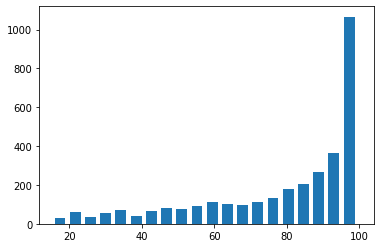

In [11]:
plt.hist(df_test["max_ident"].loc[~pd.isnull(df_test["max_ident"])], bins = 20, width= 3)
plt.show()

## 3.Sampling negative data points:

Sampling procedure: 
- For every positive transporter-substrate pair, we sample three negative transporter-molecule pairs. 
- We randomly sample the negative data points. We want to exclude those molecules that are substrates for molecules with sequence identities >60%.

#### (a) We cluster all sequences from the training and the test set using the cd-hit algorithm such that we can easily find all proteins with sequence identities >60%

In [12]:
all_sequences = list(set(list(df_train["Sequence"]) + list(df_test["Sequence"])))

df_Uniprot = pd.DataFrame({"Sequence" : all_sequences})
df_Uniprot.drop_duplicates(inplace = True)
df_Uniprot.reset_index(inplace = True, drop = True)
df_Uniprot

,Sequence
0,MPTYNDDDDSSRPPSVHSERNQKPSSSQFLGVPSSNYNQRENSSRS...
1,MMFLFENSINMIKYSIYLVPLIIMILLSISIKEDSNRMMLLFKSLK...
2,MFTINILLLVIPILLAVAFLTLVERKVLGYMQLRKGPNIVGPYGLL...
3,MIPATPFLQATALACERDGRMLFENLDLHLHTGDMLQISGPNGCGK...
4,MPTVDDILEQVGESGWFQKQAFLILCLLSAAFAPICVGIVFLGFTP...
...,...
12801,MEAKGKVVGVIGNLVTIEMVGTVSMNEIVFIKTGGQSLKAEIIRIR...
12802,MNMILTLFINITLSLCLISIAFWLPQLNAYTEKASPYECGFDPMSS...
12803,MIEPLHTAPPLLAAHDLAFSRNEEPVFGPLDFHVDAGEALLVQGDN...
12804,MQQQEQQQGGMKVKVQRFGSYLSGMIMPNIGAFIAWGIITALFIPA...


In [13]:
try:
    os.mkdir(join("..", "..", "data", "proteins", 'clusters_SPOT'))
except FileExistsError:
    pass

ofile = open(join("..", "..", "data", "proteins", 'clusters_SPOT', "all_sequences_SPOT.fasta"), "w")
for ind in df_Uniprot.index:
    seq = df_Uniprot["Sequence"][ind]
    if not pd.isnull(seq):
        seq_end = seq.find("#")
        seq = seq[:seq_end]
        ofile.write(">" + str(ind) + "\n" + seq  + "\n")
ofile.close()


df_Uniprot

# cluster the fasta files
cluster_folder = join("..", "..", "data", "proteins", 'clusters_SPOT')
start_folder = cluster_folder
cluster_all_levels_60(start_folder, 
                   cluster_folder, 
                   filename='all_sequences_SPOT')

cd-hit -i ..\..\data\proteins\clusters_SPOT\all_sequences_SPOT.fasta -o ..\..\data\proteins\clusters_SPOT\all_sequences_SPOT_clustered_sequences_100.fasta -c 1.0 -n 5 -T 1 -M 2000 -d 0
cd-hit -i ..\..\data\proteins\clusters_SPOT\all_sequences_SPOT_clustered_sequences_100.fasta -o ..\..\data\proteins\clusters_SPOT\all_sequences_SPOT_clustered_sequences_90.fasta -c 0.9 -n 5 -T 1 -M 2000 -d 0
cd-hit -i ..\..\data\proteins\clusters_SPOT\all_sequences_SPOT_clustered_sequences_90.fasta -o ..\..\data\proteins\clusters_SPOT\all_sequences_SPOT_clustered_sequences_80.fasta -c 0.8 -n 5 -T 1 -M 2000 -d 0
cd-hit -i ..\..\data\proteins\clusters_SPOT\all_sequences_SPOT_clustered_sequences_80.fasta -o ..\..\data\proteins\clusters_SPOT\all_sequences_SPOT_clustered_sequences_70.fasta -c 0.7 -n 5 -T 1 -M 2000 -d 0
cd-hit -i ..\..\data\proteins\clusters_SPOT\all_sequences_SPOT_clustered_sequences_70.fasta -o ..\..\data\proteins\clusters_SPOT\all_sequences_SPOT_clustered_sequences_60.fasta -c 0.6 -n 4 -T 1

In [14]:
###We first cluster in such a way that two different clusters do not contain two enzymes
###with a sequence identity higher than 80%:

# collect cluster members
df_90 = find_cluster_members_90(folder=cluster_folder, 
                          filename='all_sequences_SPOT')

# collect cluster members
df_80 = find_cluster_members_80(folder=cluster_folder, 
                          filename='all_sequences_SPOT')

# collect cluster members
df_70 = find_cluster_members_70(folder=cluster_folder, 
                          filename='all_sequences_SPOT')

# collect cluster members
df_60 = find_cluster_members_60(folder=cluster_folder, 
                          filename='all_sequences_SPOT')


display(df_60.describe())
display(df_60.head())
display(df_60.tail())

,cluster
count,12806.000000
mean,1816.165001
std,1034.323518
min,0.000000
25%,901.000000
50%,1813.000000
75%,2790.000000
max,3545.000000


,cluster,member
0,0,2305
1,1,5853
2,1,1302
3,1,9060
4,1,9846


,cluster,member
12801,3541,5211
12802,3542,9559
12803,3543,7198
12804,3544,361
12805,3545,8286


In [16]:
df_train = pd.read_pickle(join("..", "..", "data", "transporter_substrate_pairs",  "df_train.pkl"))
df_test = pd.read_pickle(join("..", "..", "data", "transporter_substrate_pairs",  "df_test.pkl"))

In [17]:
charge = ["/q+1","/q+2", "/q+3", "/q+4", "/q+5",
         "/q-1","/q-2", "/q-3", "/q-4", "/q-5",
         "/p+1","/p+2", "/p+3", "/p+4", "/p+5",
         "/p-1","/p-2", "/p-3", "/p-4", "/p-5"]

all_InChIs = list(set(list(df_train["InChI"]) + list(df_test["InChI"])))
def remove_charge(inchi):
    ending = inchi[-4:]
    if ending in charge:
        short_inchi = inchi[:-4]
        if short_inchi in all_InChIs:
            return(short_inchi)
        
    return(inchi)

df_train["InChI"] = [remove_charge(inchi) for inchi in list(df_train["InChI"])]
df_test["InChI"] = [remove_charge(inchi) for inchi in list(df_test["InChI"])]
df_train.head()

,Sequence,ChEBI,GOA,TCDB,SWISS,Uniprot ID,Substrate,InChI,ECFP,SMILES,ChemBERTa
0,ACPKGASYEAGIVCRITKPALLVLNQETAKVVQTAFQRAGYPDVSG...,CHEBI:3659,1.0,0.0,0.0,P22687,cholesterol,InChI=1S/C27H46O/c1-18(2)7-6-8-19(3)23-11-12-2...,0100000110000000100000000000000001001000010000...,CC(C)CCC[C@@H](C)[C@H]1CC[C@H]2[C@@H]3CC=C4C[C...,"[-2.65946888923645, -2.193105936050415, -2.509..."
1,ACPKGASYEAGIVCRITKPALLVLNQETAKVVQTAFQRAGYPDVSG...,CHEBI:41509,0.0,0.0,1.0,P22687,cholesteryl linoleate,InChI=1S/C45H76O2/c1-7-8-9-10-11-12-13-14-15-1...,0100000110000000100000000000100001011000010000...,CCCCC/C=C\C/C=C\CCCCCCCC(=O)O[C@H]1CC[C@@]2(C)...,"[-2.5698935985565186, -2.2278573513031006, -2...."
2,ACPKGASYEAGIVCRITKPALLVLNQETAKVVQTAFQRAGYPDVSG...,CHEBI:46898,0.0,0.0,1.0,P22687,cholesteryl oleate,InChI=1S/C45H78O2/c1-7-8-9-10-11-12-13-14-15-1...,0100000110000000100000000000100001011000010000...,CCCCCCCC/C=C\CCCCCCCC(=O)O[C@H]1CC[C@@]2(C)C(=...,"[-2.645322799682617, -2.1791882514953613, -2.5..."
3,ACPKGASYEAGIVCRITKPALLVLNQETAKVVQTAFQRAGYPDVSG...,CHEBI:53753,0.0,0.0,1.0,P22687,triolein,InChI=1S/C57H104O6/c1-4-7-10-13-16-19-22-25-28...,0100000000000000000000000000010001000000000000...,CCCCCCCC/C=C\CCCCCCCC(=O)OCC(COC(=O)CCCCCCC/C=...,"[-2.449126958847046, -2.3380744457244873, -2.6..."
4,ADNQHPTVYQKVASQMHLSSSLSQDVHARYGGIQRPALSQRRFPYG...,CHEBI:30616,0.0,0.0,1.0,P27081,ATP(4-),InChI=1S/C10H16N5O13P3/c11-8-5-9(13-2-12-8)15(...,0000000001000000000000000000000000000000000100...,Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)([O-])OP(=O...,"[-2.4719278812408447, -2.1134302616119385, -2...."


#### For every sequence, we creat a list of forbidden negative molecules:

In [18]:
df_train["member"] = [str(list(df_Uniprot.loc[df_Uniprot["Sequence"] == seq].index)[0]) for seq in df_train["Sequence"]]
df_train["cluster"] = [list(df_60["cluster"].loc[df_60["member"] == member])[0] for member in df_train["member"]]

df_test["member"] = [str(list(df_Uniprot.loc[df_Uniprot["Sequence"] == seq].index)[0]) for seq in df_test["Sequence"]]
df_test["cluster"] = [list(df_60["cluster"].loc[df_60["member"] == member])[0] for member in df_test["member"]]




df_train["forbidden_inchis"] = ""
df_test["forbidden_inchis"] = ""

for ind in df_train.index:
    cluster = df_train["cluster"][ind]
    df_train["forbidden_inchis"][ind] = list(set(list(df_train["InChI"].loc[df_train["cluster"] == cluster]) +
                                 list(df_test["InChI"].loc[df_test["cluster"] == cluster])))    

for ind in df_test.index:
    cluster = df_test["cluster"][ind]
    df_test["forbidden_inchis"][ind] = list(set(list(df_train["InChI"].loc[df_train["cluster"] == cluster]) +
                                 list(df_test["InChI"].loc[df_test["cluster"] == cluster])))
    

C:\Users\alexk\anaconda3\envs\Transport\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
C:\Users\alexk\anaconda3\envs\Transport\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [19]:
df_train.to_pickle(join("..", "..", "data", "transporter_substrate_pairs",  "df_train.pkl"))
df_test.to_pickle(join("..", "..", "data", "transporter_substrate_pairs",  "df_test.pkl"))

### Find all small molcules (mostly ions):

In [3]:
df_train = pd.read_pickle(join("..", "..", "data", "transporter_substrate_pairs",  "df_train.pkl"))
df_test = pd.read_pickle(join("..", "..", "data", "transporter_substrate_pairs",  "df_test.pkl"))
df_transporter = pd.read_pickle(join("..", "..", "data", "Transporter_Substrate_Pairs.pkl"))

In [4]:
small_molecules = []
small_ecfps = []

for ind in df_transporter.index:
    ecfp = df_transporter["ECFP"][ind]
    if sum(np.array(list(ecfp)).astype(int)) <=2:
        if not pd.isnull(df_transporter["InChI"][ind]):
            print(df_transporter["InChI"][ind])
            small_molecules.append(df_transporter["InChI"][ind])
            small_ecfps.append(ecfp)
        else:
            print(df_transporter["KEGG ID"][ind])
            small_molecules.append(df_transporter["KEGG ID"][ind])
            small_ecfps.append(ecfp)
small_molecules = list(set(small_molecules))

InChI=1S/p+1
InChI=1S/Na/q+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/Na/q+1
InChI=1S/Na/q+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/ClH/h1H/p-1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/K
InChI=1S/Ca
InChI=1S/p+1
InChI=1S/Mn/q+2
InChI=1S/H2O/h1H2
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/ClH/h1H/p-1
InChI=1S/ClH/h1H/p-1
InChI=1S/ClH/h1H/p-1
InChI=1S/p+1
InChI=1S/H2O/h1H2
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/K
InChI=1S/Ca
InChI=1S/Na/q+1
InChI=1S/Na/q+1
InChI=1S/Na/q+1
InChI=1S/Na/q+1
InChI=1S/Na/q+1
InChI=1S/Na/q+1
InChI=1S/Na/q+1
InChI=1S/Na/q+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/Na
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/ClH/h1H/p-

InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/Zn/q+2
InChI=1S/Zn/q+2
InChI=1S/Cd/q+2
InChI=1S/Ca
InChI=1S/K
InChI=1S/Na
InChI=1S/Na/q+1
InChI=1S/K/q+1
InChI=1S/K/q+1
InChI=1S/Fe/q+3
InChI=1S/p+1
InChI=1S/Fe/q+3
InChI=1S/Fe/q+3
InChI=1S/Fe/q+3
InChI=1S/p+1
InChI=1S/Mg
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/Fe/q+3
InChI=1S/Fe/q+3
InChI=1S/Fe/q+3
InChI=1S/Fe/q+3
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/Na
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/Ca
InChI=1S/p+1
InChI=1S/ClH/h1H/p-1
InChI=1S/ClH/h1H/p-1
InChI=1S/p+1
InChI=1S/ClH/h1H/p-1
InChI=1S/p+1
InChI=1S/ClH/h1H/p-1
InChI=1S/p+1
InChI=1S/ClH/h1H/p-1
InChI=1S/p+1
InChI=1S/ClH/h1H/p-1
InChI=1S/p+1
InChI=1S/ClH/h1H/p-1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/Na/q+1
InChI=1S/Na

InChI=1S/Na
InChI=1S/Ca
InChI=1S/Na
InChI=1S/4ClH.Fe/h4*1H;/q;;;;+3/p-4
InChI=1S/4ClH.Fe/h4*1H;/q;;;;+3/p-4
InChI=1S/4ClH.Fe/h4*1H;/q;;;;+3/p-4
InChI=1S/K
InChI=1S/Na
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/Ca
InChI=1S/K
InChI=1S/p+1
InChI=1S/Na/q+1
InChI=1S/p+1
InChI=1S/Zn/q+2
InChI=1S/p+1
InChI=1S/Cu/q+2
InChI=1S/p+1
InChI=1S/Na/q+1
InChI=1S/p+1
InChI=1S/Na/q+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/K/q+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/K/q+1
InChI=1S/p+1
InChI=1S/K/q+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/K/q+1
InChI=1S/p+1
InChI=1S/K/q+1
InChI=1S/p+1
InChI=1S/K/q+1
InChI=1S/p+1
InChI=1S/K/q+1
InChI=1S/p+1
InChI=1S/K/q+1
InChI=1S/p+1
InChI=1S/K/q+1
InChI=1S/p+1
InChI=1S/K/q+1
InChI=1S/p+1
InChI=1S/K/q+1
InChI=1S/p+1
InChI=1S/Na/q+1
InChI=1S/p+1
InChI=1S/K/q+1
InChI=1S/K
InChI=1S/p+1
InChI=1S/K/q+1
InChI=1S/p+1
InChI=1S/K/q+1
InChI=1S/p+1
InChI=1S/K/q+1
InChI=1S/p+1
InChI=1S/Zn/q+2
InChI=1

InChI=1S/K
InChI=1S/p+1
InChI=1S/Mn/q+2
InChI=1S/Cd/q+2
InChI=1S/Al/q+3
InChI=1S/p+1
InChI=1S/Pb/q+2
InChI=1S/Fe/q+3
InChI=1S/Fe/q+3
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/Na/q+1
InChI=1S/p+1
InChI=1S/Cu/q+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/Na/q+1
InChI=1S/Na/q+1
InChI=1S/Na/q+1
InChI=1S/Na
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/ClH/h1H/p-1
InChI=1S/ClH/h1H/p-1
InChI=1S/ClH/h1H/p-1
InChI=1S/Na/q+1
InChI=1S/Na/q+1
InChI=1S/Na/q+1
InChI=1S/Na/q+1
InChI=1S/Na

InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/K
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/K
InChI=1S/K/q+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
I

InChI=1S/Mn/q+2
InChI=1S/ClH/h1H/p-1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/4ClH.Fe/h4*1H;/q;;;;+3/p-4
InChI=1S/Mg
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/Ca
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/Fe/q+3
InChI=1S/K
InChI=1S/Mg
InChI=1S/Mg
InChI=1S/p+1
InChI=1S/K/q+1
InChI=1S/p+1
InChI=1S/Zn/q+2
InChI=1S/Na
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/Na/q+1
InChI=1S/p+1
InChI=1S/Na/q+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/ClH/h1H/p-1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/Na/q+1
InChI=1S/p+1
InChI=1S/Na/q+1
InChI=1S/K/q+1
InChI=1S/p+1
InChI=1S/Mg/q+2
InChI=1S/Mg/q+2
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/Ca
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/Mg
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InC

InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/Fe/q+3
InChI=1S/p+1
InChI=1S/Na/q+1
InChI=1S/HI/h1H/p-1
InChI=1S/ClH/h1H/p-1
InChI=1S/HI/h1H/p-1
InChI=1S/ClH/h1H/p-1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/Na/q+1
InChI=1S/p+1
InChI=1S/Na/q+1
InChI=1S/p+1
InChI=1S/Na/q+1
InChI=1S/p+1
InChI=1S/Na/q+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/Fe/q+3
InChI=1S/Fe/q+3
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/Ca
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/Ca
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/Ca
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1


InChI=1S/p+1
InChI=1S/p+1
InChI=1S/Ca
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/Ca
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/Na/q+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/Zn/q+2
InChI=1S/Mg
InChI=1S/Zn/q+2
InChI=1S/p+1
InChI=1S/H2O/h1H2
InChI=1S/Zn/q+2
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/Ca
InChI=1S/p+1
InChI=1S/H2O/h1H2
InChI=1S/Zn/q+2
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/Na/q+1
InChI=1S/Na/q+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+

InChI=1S/Na/q+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/H2O/h1H2
InChI=1S/4ClH.Fe/h4*1H;/q;;;;+3/p-4
InChI=1S/H2O/h1H2
InChI=1S/4ClH.Fe/h4*1H;/q;;;;+3/p-4
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/Na/q+1
InChI=1S/Ca
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/K/q+1
InChI=1S/K/q+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/H2O/h1H2
InChI=1S/Zn/q+2
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/Na/q+1
InChI=1S/Ca
InChI=1S/Ca/q+2
InChI=1S/p+1
InChI=1S/Na/q+1
InChI=1S/p+1
InChI=1S/Na/q+1
InChI=1S/p+1
InChI=1S/Na/q+1
InChI=1S/p+1
InChI=1S/Na/q+1
InChI=1S/p+1
InChI=1S/Na/q+1
InChI=1S/K/q+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/Ca
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/

InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/Ca
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/Na
InChI=1S/ClH/h1H/p-1
InChI=1S/Cu/q+2
InChI=1S/Cu/q+1
InChI=1S/Ca
InChI=1S/p+1
InChI=1S/Na
InChI=1S/Na
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/K
InChI=1S/K
InChI=1S/K
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/Ca
InChI=1S/p+1
InChI=1S/Na/q+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/Na/q+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/Na/q+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
I

InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/Na/q+1
InChI=1S/Mg
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/Na/q+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/Na
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/Ca
InChI=1S/Ca/q+2
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/Cu/q+2
InChI=1S/Cu/q+1
InChI=1S/K
InChI=1S/4ClH.Fe/h4*1H;/q;;;;+3/p-4
InChI=1S/p+1
InChI=1S/Na/q+1
InChI=1S/K
InChI=1S/K
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/Na/q+1
InChI=1S/p+1
InChI=1S/4ClH.Fe/h4*1H;/q;;;;+3/p-4
InChI=1S/Mg
InChI=1S/K
InChI=1S/Fe/q+3
InChI=1S/p+1
InChI=1S/K
InChI=1S/p+1
InChI=1S/Ca
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/

InChI=1S/p+1
InChI=1S/Cu/q+1
InChI=1S/p+1
InChI=1S/Cd/q+2
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/Ca
InChI=1S/Ca
InChI=1S/Ca
InChI=1S/Ca
InChI=1S/Ca
InChI=1S/Ca
InChI=1S/Mn/q+2
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/ClH/h1H/p-1
InChI=1S/p+1
InChI=1S/Na/q+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/Ca
InChI=1S/p+1
InChI=1S/Ca
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/Cu/q+2
InChI=1S/Ca/q+2
InChI=1S/p+1
InChI=1S/Fe/q+3
InChI=1S/p+1
InChI=1S/ClH/h1H/p-1
InChI=1S/K
InChI=1S/ClH/h1H/p-1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/4ClH.Fe/h4*1H;/q;;;;+3/p-4
InChI=1S/4ClH.Fe/h4*1H;/q;;;;+3/p-4
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/H2O/h1H2
InChI=1S/H2O/h1H2
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1

InChI=1S/K/q+1
InChI=1S/K/q+1
InChI=1S/K/q+1
InChI=1S/K/q+1
InChI=1S/K/q+1
InChI=1S/K/q+1
InChI=1S/K/q+1
InChI=1S/K/q+1
InChI=1S/K/q+1
InChI=1S/K/q+1
InChI=1S/K/q+1
InChI=1S/K/q+1
InChI=1S/K/q+1
InChI=1S/K/q+1
InChI=1S/K/q+1
InChI=1S/K/q+1
InChI=1S/K/q+1
InChI=1S/K/q+1
InChI=1S/K/q+1
InChI=1S/K/q+1
InChI=1S/K/q+1
InChI=1S/K/q+1
InChI=1S/K/q+1
InChI=1S/K/q+1
InChI=1S/K/q+1
InChI=1S/K/q+1
InChI=1S/K
InChI=1S/K
InChI=1S/K
InChI=1S/K
InChI=1S/K
InChI=1S/Zn/q+2
InChI=1S/Ca/q+2
InChI=1S/K/q+1
InChI=1S/Ca
InChI=1S/p+1
InChI=1S/Na/q+1
InChI=1S/p+1
InChI=1S/Ca
InChI=1S/Ca/q+2
InChI=1S/Ca
InChI=1S/K
InChI=1S/4ClH.Fe/h4*1H;/q;;;;+3/p-4
InChI=1S/ClH/h1H/p-1
InChI=1S/ClH/h1H/p-1
InChI=1S/ClH/h1H/p-1
InChI=1S/Ca
InChI=1S/p+1
InChI=1S/Na/q+1
InChI=1S/p+1
InChI=1S/Na/q+1
InChI=1S/p+1
InChI=1S/Na/q+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/Na/q+1
InChI=1S/Na/q+1
InChI=1S/Na
InChI=1S/Na/q+1
InChI=1S/p+1
InChI=1S/K
InChI=1S/ClH/h1H/p-1
InChI=1S/Na/q+1
InChI=1S/Na/q+1
InChI=1S/Na/q+1
InChI=1S/Na/q+1
InChI=1S/N

InChI=1S/p+1
InChI=1S/Na/q+1
InChI=1S/p+1
InChI=1S/Na/q+1
InChI=1S/p+1
InChI=1S/Na/q+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/Na/q+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/Na/q+1
InChI=1S/p+1
InChI=1S/Na/q+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/Na
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/Ca
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/Na/q+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/Cu/q+1
InChI=1S/p+1
InChI=1S/Na/q+1


InChI=1S/Ca
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/H2O/h1H2
InChI=1S/Zn/q+2
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/K
InChI=1S/Na
InChI=1S/Na/q+1
InChI=1S/K/q+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/Na/q+1
InChI=1S/K
InChI=1S/K
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/Na/q+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/Na/q+1
InChI=1S/p+1
InChI=1S/Na/q+1
InChI=1S/K
InChI=1S/K
InChI=1S/K
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/Na/q+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/Na/q+1
InChI=1S

InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/O
InChI=1S/p+1
InChI=1S/Ca
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/H3N/h1H3/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/Na
InChI=1S/Na
InChI=1S/O
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/Ca
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/Ca
InChI=1S/O
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/Ca
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/p+1
InChI=1S/Ca/q+2


In [5]:
df_molecules = pd.DataFrame(columns = ["InChI", "count", "ECFP"])

InChIs = list(set(df_transporter["InChI"]))

for inchi in InChIs:
    df_molecules = df_molecules.append({"InChI" : inchi,
                                        "count" : len(df_transporter.loc[df_transporter["InChI"] == inchi]),
                                       "ECFP" : list(df_transporter["ECFP"].loc[df_transporter["InChI"] == inchi])[0]},
                                      ignore_index = True)
    
df_molecules = df_molecules.sort_values("count", ascending=False)
df_molecules.reset_index(inplace = True, drop = True)
df_molecules

,InChI,count,ECFP
0,InChI=1S/p+1,7535,0000000000000000000000000000000000000000000000...
1,InChI=1S/Na/q+1,978,0000000000000000000000000000000000000000000000...
2,InChI=1S/Ca,319,0000000000000000000000000000000000000000000000...
3,"InChI=1S/H3O4P/c1-5(2,3)4/h(H3,1,2,3,4)/p-2",316,0000000000000000000000000000000000000000000000...
4,InChI=1S/K,288,0000000000000000000000000000000000000000000000...
...,...,...,...
375,InChI=1S/C6H12O6/c7-1-2-3(8)4(9)5(10)6(11)12-2...,1,0000000000000100000000000000000000000000000010...
376,InChI=1S/C26H28Cl2N4O4/c1-19(33)31-10-12-32(13...,1,0000000000000000000000000000000001001100001000...
377,InChI=1S/Cr,1,0000000000000000000000000000000000000000000000...
378,InChI=1S/C16H28N2O11/c1-5(21)17-9-13(25)14(8(4...,1,0100000000000000000000001000010001000000000000...


In [6]:
len(df_train.loc[df_train["InChI"] == "InChI=1S/p+1"]), len(df_test.loc[df_test["InChI"] == "InChI=1S/p+1"])

(6140, 1382)

We remove all data poins with hydrogen as a substrate:

In [7]:
h_indices = list(df_train.loc[df_train["InChI"] == "InChI=1S/p+1"].index)
df_train.drop(h_indices, inplace = True)
df_train.reset_index(inplace = True, drop= True)
df_train

,Sequence,ChEBI,GOA,TCDB,SWISS,Uniprot ID,Substrate,InChI,ECFP,SMILES,ChemBERTa,member,cluster,forbidden_inchis
0,ACPKGASYEAGIVCRITKPALLVLNQETAKVVQTAFQRAGYPDVSG...,CHEBI:3659,1.0,0.0,0.0,P22687,cholesterol,InChI=1S/C27H46O/c1-18(2)7-6-8-19(3)23-11-12-2...,0100000110000000100000000000000001001000010000...,CC(C)CCC[C@@H](C)[C@H]1CC[C@H]2[C@@H]3CC=C4C[C...,"[-2.65946888923645, -2.193105936050415, -2.509...",5666,899,[InChI=1S/C45H78O2/c1-7-8-9-10-11-12-13-14-15-...
1,ACPKGASYEAGIVCRITKPALLVLNQETAKVVQTAFQRAGYPDVSG...,CHEBI:41509,0.0,0.0,1.0,P22687,cholesteryl linoleate,InChI=1S/C45H76O2/c1-7-8-9-10-11-12-13-14-15-1...,0100000110000000100000000000100001011000010000...,CCCCC/C=C\C/C=C\CCCCCCCC(=O)O[C@H]1CC[C@@]2(C)...,"[-2.5698935985565186, -2.2278573513031006, -2....",5666,899,[InChI=1S/C45H78O2/c1-7-8-9-10-11-12-13-14-15-...
2,ACPKGASYEAGIVCRITKPALLVLNQETAKVVQTAFQRAGYPDVSG...,CHEBI:46898,0.0,0.0,1.0,P22687,cholesteryl oleate,InChI=1S/C45H78O2/c1-7-8-9-10-11-12-13-14-15-1...,0100000110000000100000000000100001011000010000...,CCCCCCCC/C=C\CCCCCCCC(=O)O[C@H]1CC[C@@]2(C)C(=...,"[-2.645322799682617, -2.1791882514953613, -2.5...",5666,899,[InChI=1S/C45H78O2/c1-7-8-9-10-11-12-13-14-15-...
3,ACPKGASYEAGIVCRITKPALLVLNQETAKVVQTAFQRAGYPDVSG...,CHEBI:53753,0.0,0.0,1.0,P22687,triolein,InChI=1S/C57H104O6/c1-4-7-10-13-16-19-22-25-28...,0100000000000000000000000000010001000000000000...,CCCCCCCC/C=C\CCCCCCCC(=O)OCC(COC(=O)CCCCCCC/C=...,"[-2.449126958847046, -2.3380744457244873, -2.6...",5666,899,[InChI=1S/C45H78O2/c1-7-8-9-10-11-12-13-14-15-...
4,AGGIAEMAELGPEVRKKTDKLDAVGNTTAAVAKGFAIGSAALTALA...,CHEBI:29101,0.0,0.0,1.0,Q8VNJ8,sodium(1+),InChI=1S/Na,0000000000000000000000000000000000000000000000...,[Na+],"[-1.8654876947402954, -1.4297412633895874, -2....",1897,3136,[InChI=1S/C9H14N4O3/c10-2-1-8(14)13-7(9(15)16)...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6986,VLHIPEENRSVDILELTEQEELLQFHYHTLRLYSAVCALGNHRVAH...,CHEBI:22984,1.0,0.0,0.0,Q99M98,calcium atom,InChI=1S/Ca,0000000000000000000000000000000000000000000000...,[Ca],"[-1.317147135734558, -1.4327999353408813, -2.5...",4000,1136,"[InChI=1S/K, InChI=1S/Na, InChI=1S/Ni/q+2, InC..."
6987,VRAENGPTCIVMRPSADDPNKTKFTWLLSIDLKGWIPKTIINKVLS...,CHEBI:16113,0.0,0.0,1.0,P58864,cholesterol,InChI=1S/C27H46O/c1-18(2)7-6-8-19(3)23-11-12-2...,0100000110000000100000000000000001001000010000...,CC(C)CCC[C@@H](C)[C@H]1CC[C@H]2[C@@H]3CC=C4C[C...,"[-2.65946888923645, -2.193105936050415, -2.509...",9364,2012,[InChI=1S/C34H68NO6P/c1-3-5-7-9-11-13-15-17-19...
6988,VSYLAGCGLQSCPMLVAKGYPDIGWNPCGGERYLDFLRFAVFVNGE...,CHEBI:22984,1.0,0.0,0.0,O75591,calcium atom,InChI=1S/Ca,0000000000000000000000000000000000000000000000...,[Ca],"[-1.317147135734558, -1.4327999353408813, -2.5...",3364,1813,[InChI=1S/Ca]
6989,VVWTNEERSIISSIFSNLDYDDIGPKALCRCLIVYPWTQRHFTTFG...,CHEBI:25805,1.0,0.0,0.0,P83624,oxygen atom,InChI=1S/O,0000000000000000000000000000000000000000000000...,[O],"[-1.9637330770492554, -1.4230247735977173, -2....",11065,515,"[InChI=1S/O, InChI=1S/p+1, InChI=1S/Mn, InChI=..."


In [8]:
h_indices = list(df_test.loc[df_test["InChI"] == "InChI=1S/p+1"].index)
df_test.drop(h_indices, inplace = True)
df_test.reset_index(inplace = True, drop= True)
df_test

,Sequence,ChEBI,GOA,TCDB,SWISS,Uniprot ID,Substrate,InChI,ECFP,SMILES,ChemBERTa,member,cluster,max_ident,max_ind,forbidden_inchis
0,ADNQHPTVYQKVASQMHLSSSLSQDVHARYGGIQRPALSQRRFPYG...,CHEBI:30616,0.0,0.0,1.0,P27081,ATP(4-),InChI=1S/C10H16N5O13P3/c11-8-5-9(13-2-12-8)15(...,0000000001000000000000000000000000000000000100...,Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)([O-])OP(=O...,"[-2.4719278812408447, -2.1134302616119385, -2....",2883,3143,88.1,292.0,[InChI=1S/C10H16N5O13P3/c11-8-5-9(13-2-12-8)15...
1,ADNQHPTVYQKVASQMHLSSSLSQDVHARYGGIQRPALSQRRFPYG...,CHEBI:456216,0.0,0.0,1.0,P27081,ADP(3-),InChI=1S/C10H15N5O10P2/c11-8-5-9(13-2-12-8)15(...,0000000001000000000000000000000000000000000000...,Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)([O-])OP(=O...,"[-2.478724241256714, -2.096115827560425, -2.81...",2883,3143,88.1,292.0,[InChI=1S/C10H16N5O13P3/c11-8-5-9(13-2-12-8)15...
2,ARVCEERGGPAAIMQRRVFVVGVGMTKFAKPSENSVDYPDLAKEAG...,CHEBI:17759,0.0,0.0,1.0,Q07598,"cholesta-5,7-dien-3beta-ol",InChI=1S/C27H44O/c1-18(2)7-6-8-19(3)23-11-12-2...,0100100010000000000000000000000001001100010000...,CC(C)CCC[C@@H](C)[C@H]1CC[C@H]2C3=CC=C4C[C@@H]...,"[-2.676461696624756, -2.2211854457855225, -2.4...",1656,1607,76.8,10786.0,"[InChI=1S/C3H7NO3/c4-2(1-5)3(6)7/h2,5H,1,4H2,(..."
3,EIVKYIAHLWRRFKRRMLKKYRLYKYQRQQRKEGLLPNADNLTFSP...,CHEBI:22984,1.0,0.0,0.0,Q963J1,calcium atom,InChI=1S/Ca,0000000000000000000000000000000000000000000000...,[Ca],"[-1.317147135734558, -1.4327999353408813, -2.5...",11591,3181,18.8,6480.0,"[InChI=1S/p+1, InChI=1S/Ca]"
4,FDESSSDKEILDLLLEKKRYDKRLLPPVNDEDFCCGLQSPDMATNQ...,CHEBI:3731,1.0,0.0,0.0,Q5D6W0,chloride,InChI=1S/ClH/h1H/p-1,0000000000000000000000000000000000000000000000...,[Cl-],"[-1.5440824031829834, -1.5209712982177734, -2....",3377,890,96.2,26.0,"[InChI=1S/H3O3P/c1-4(2)3/h4H,(H2,1,2,3)/p-2, I..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1637,MYTTTLSVQGMTCTSCVASIQSMLEGVEGIEQFTISLLLERAIAVH...,CHEBI:49552,0.0,0.0,1.0,O59666,copper(1+),InChI=1S/Cu/q+1,0000000000000000000000000000000000000000000000...,[Cu+],"[-1.356805682182312, -1.566771149635315, -2.27...",10603,2513,32.9,1628.0,"[InChI=1S/H2O/h1H2, InChI=1S/Na, InChI=1S/C10H..."
1638,NSADRLEKQVEEMIAFLISFLAALLCESVHSDNSAVAWCYNNPLCN...,CHEBI:26708,1.0,0.0,0.0,Q502E2,sodium atom,InChI=1S/Na,0000000000000000000000000000000000000000000000...,[Na],"[-1.5495914220809937, -1.1587504148483276, -2....",3157,3125,98.5,13058.0,"[InChI=1S/C5H9NO4/c6-3(5(9)10)1-2-4(7)8/h3H,1-..."
1639,QQAVSEEIHCRFFDHVKTGIEDVCGHWGHNFWRDKFKKFDDKYLRK...,CHEBI:26708,1.0,0.0,0.0,Q9WUJ4,sodium atom,InChI=1S/Na,0000000000000000000000000000000000000000000000...,[Na],"[-1.5495914220809937, -1.1587504148483276, -2....",7102,2820,20.6,8407.0,"[InChI=1S/C6H13O9P/c7-3-2(1-14-16(11,12)13)15-..."
1640,TARYTALVAKDAKRAAADMGKVLHVEIDPEDAKVERMAKDESNQFG...,CHEBI:28938,0.0,0.0,1.0,B2CPI4,ammonium,InChI=1S/H3N/h1H3/p+1,0000000000000000000000000000000000000000000000...,[NH4+],"[-2.1090593338012695, -1.8530315160751343, -2....",10126,981,20.0,291.0,"[InChI=1S/Mo.4O/q;;;2*-1, InChI=1S/C19H19N7O6/..."


In [21]:
def get_mol(met_ID):
    is_InChI = (met_ID[0:5] == "InChI") 
    if is_InChI:
        try:
            mol = Chem.inchi.MolFromInchi(met_ID)
        except:
            mol = None
    return(mol)

def drop_samples_without_mol_file(df):
    droplist = []
    for ind in df.index:
        if get_mol(met_ID = df["molecule ID"][ind]) is None:
            droplist.append(ind)
    df.drop(droplist, inplace = True)
    return(df)

def get_metabolites_and_similarities(df):
    df_metabolites = pd.DataFrame(data = {"ECFP": df["ECFP"], "ID": df["molecule ID"]})
    df_metabolites = df_metabolites.drop_duplicates()
    df_metabolites.reset_index(inplace = True, drop = True)


    ms = [get_mol(met_ID = df_metabolites["ID"][ind]) for ind in df_metabolites.index]
    fps = [Chem.RDKFingerprint(x) for x in ms]

    similarity_matrix = np.zeros((len(ms), len(ms)))
    for i in range(len(ms)):
        for j in range(len(ms)):
            similarity_matrix[i,j] = DataStructs.FingerprintSimilarity(fps[i],fps[j])
            
    return(df_metabolites, similarity_matrix)


def get_valid_list(forbidden_inchis, 
                   met_ID,
                   df_metabolites,
                   lower_bound =0.7,
                   upper_bound =0.9):
    
    #make sure that every time this molecule is allowed to be selected, it will be selected. Otherwise it
    #will be underrepresented:
    df_metabolites["similarity"].loc[df_metabolites["ID"] == "InChI=1S/p+1"] = 0.94
    
    df_metabolites["similarity"].loc[df_metabolites["neg_count"] < 1] = -1000
    
    
    indices = list(df_metabolites.loc[df_metabolites["neg_count"] == 0].loc[df_metabolites["count"] > 30].index)
    df_metabolites["similarity"].loc[indices] = 0
    indices = list(df_metabolites.loc[df_metabolites["neg_count"] == -1].loc[df_metabolites["count"] > 30].index)
    df_metabolites["similarity"].loc[indices] = -0.5
    indices = list(df_metabolites.loc[df_metabolites["neg_count"] == -2].loc[df_metabolites["count"] > 60].index)
    df_metabolites["similarity"].loc[indices] = -1
    indices = list(df_metabolites.loc[df_metabolites["neg_count"] == -3].loc[df_metabolites["count"] > 100].index)
    df_metabolites["similarity"].loc[indices] = -1.2
    
    df_metabolites["similarity"].loc[df_metabolites["ID"].isin(forbidden_inchis)] = -1000
    
    
    #lower bar, otherwise all small molecules will be too similar to be selected:
    if met_ID in small_molecules:
        df_metabolites["similarity"] = np.array(df_metabolites["similarity"]) - 0.06
    
    metabolites = list(df_metabolites["ID"].loc[df_metabolites["similarity"] > lower_bound].loc[df_metabolites["similarity"] < upper_bound])
    counts = np.array(list(df_metabolites["neg_count"].loc[df_metabolites["similarity"] > lower_bound].loc[df_metabolites["similarity"] < upper_bound]))
    
    
    if len(counts) > 0:
        counts = counts - min(counts) + 1
        counts = counts/sum(counts)
        
    
    return(metabolites, counts)


def get_valid_list(forbidden_inchis, 
                   met_ID,
                   df_metabolites,
                   lower_bound =0.7,
                   upper_bound =0.9):
    
    #make sure that every time this molecule is allowed to be selected, it will be selected. Otherwise it
    #will be underrepresented:
    if "InChI=1S/Na" not in forbidden_inchis:
        df_metabolites["similarity"].loc[df_metabolites["ID"] == "InChI=1S/Na"] = 0.94
    df_metabolites["similarity"].loc[df_metabolites["neg_count"] < 1] = -1000
    
    
    indices = list(df_metabolites.loc[df_metabolites["neg_count"] == 0].loc[df_metabolites["count"] > 2].index)
    df_metabolites["similarity"].loc[indices] = 0
    indices = list(df_metabolites.loc[df_metabolites["neg_count"] == -1].loc[df_metabolites["count"] > 4].index)
    df_metabolites["similarity"].loc[indices] = -0.5
    indices = list(df_metabolites.loc[df_metabolites["neg_count"] == -2].loc[df_metabolites["count"] > 5].index)
    df_metabolites["similarity"].loc[indices] = -1
    indices = list(df_metabolites.loc[df_metabolites["neg_count"] == -3].loc[df_metabolites["count"] > 5].index)
    df_metabolites["similarity"].loc[indices] = -1.2
    indices = list(df_metabolites.loc[df_metabolites["neg_count"] == -4].loc[df_metabolites["count"] > 5].index)
    df_metabolites["similarity"].loc[indices] = -1.2
    indices = list(df_metabolites.loc[df_metabolites["neg_count"] == -5].loc[df_metabolites["count"] > 10].index)
    df_metabolites["similarity"].loc[indices] = -1.2
    indices = list(df_metabolites.loc[df_metabolites["neg_count"] == -6].loc[df_metabolites["count"] > 10].index)
    df_metabolites["similarity"].loc[indices] = -1.2
    
    df_metabolites["similarity"].loc[df_metabolites["ID"].isin(forbidden_inchis)] = -2000
    
    
    #lower bar, otherwise all small molecules will be too similar to be selected:
    if met_ID in small_molecules:
        df_metabolites["similarity"] = np.array(df_metabolites["similarity"]) - 0.06
    
    metabolites = list(df_metabolites["ID"].loc[df_metabolites["similarity"] > lower_bound].loc[df_metabolites["similarity"] < upper_bound])
    counts = np.array(list(df_metabolites["neg_count"].loc[df_metabolites["similarity"] > lower_bound].loc[df_metabolites["similarity"] < upper_bound]))
    
    
    if len(counts) > 0:
        counts = counts - min(counts) + 1
        counts = counts/sum(counts)
        
    
    return(metabolites, counts)

def create_negative_samples_V2(df, df_metabolites, similarity_matrix):
    start = time.time()
    UID_list = []
    MID_list = []
    forbidden_mets = []

    for ind in df.index:
        if ind % 500 ==0:
            print(ind)
            print("Time: %s [min]" % np.round(float((time.time()-start)/60),2))

            df2 = pd.DataFrame(data = {"Uniprot ID": UID_list, "molecule ID" : MID_list})
            df2["outcome"] = 0
            df = pd.concat([df, df2], ignore_index=True)

            UID_list, MID_list = [], []

            forbidden_mets_old = forbidden_mets.copy()
            all_mets = list(set(df["molecule ID"]))
            all_mets = [met for met in all_mets if not met in forbidden_mets_old]
            forbidden_mets = list(set([met for met in all_mets if 
                                       (np.mean(df["outcome"].loc[df["molecule ID"] == met]) <= 0.25)]))
            forbidden_mets = list(set(forbidden_mets + forbidden_mets_old))
            print(len(forbidden_mets))

        UID = df["Uniprot ID"][ind]
        met_ID = df["molecule ID"][ind]
        forbidden_inchis = df["forbidden_inchis"][ind]
        k = list(df_metabolites.loc[df_metabolites["ID"] == met_ID].index)[0]
        df_metabolites["similarity"] = similarity_matrix[k,:]
        
        lower_bound = 0.75
        metabolites, counts = get_valid_list(forbidden_inchis, met_ID, df_metabolites = df_metabolites,
                           lower_bound =lower_bound,
                           upper_bound =0.95)
        
        
        while len(metabolites) < 3:
            lower_bound = lower_bound - 0.2
            metabolites, counts = get_valid_list(forbidden_inchis = forbidden_inchis, met_ID = met_ID,
                                     df_metabolites = df_metabolites, 
                                     lower_bound = lower_bound, upper_bound = 1)
            if lower_bound <-1.5:
                metabolites, counts = get_valid_list(forbidden_inchis = [], met_ID = met_ID,
                                     df_metabolites = df_metabolites, 
                                     lower_bound = -500, upper_bound = 0.95)
                print(ind)
                break
                
        try:
            n_sample = np.random.choice([1,2,3,4], p=[0.1, 0.2, 0.4, 0.3])
            new_metabolites = np.random.choice(metabolites, size=min(n_sample,len(metabolites)), replace=False, p=counts)
        except:
            print(ind)
            
        for met in new_metabolites:
            UID_list.append(UID), MID_list.append(met)
            
            df_metabolites["neg_count"].loc[df_metabolites["ID"]  == met] = np.array(df_metabolites["neg_count"].loc[df_metabolites["ID"]  == met]) - 1

    df2 = pd.DataFrame(data = {"Uniprot ID": UID_list, "molecule ID" : MID_list})
    df2["outcome"] = 0

    df = pd.concat([df, df2], ignore_index = True)
    return(df)

In [22]:
df_UID_MID_train = df_train.copy()
df_UID_MID_test = df_test.copy()
len(df_UID_MID_test), len(df_UID_MID_train)

(1642, 6991)

In [23]:
df_UID_MID_train["molecule ID"] = [df_UID_MID_train["InChI"][ind] for ind in df_UID_MID_train.index]

df_UID_MID_train = pd.DataFrame({"Uniprot ID" : df_UID_MID_train["Uniprot ID"],
                   "Sequence" : df_UID_MID_train["Sequence"],
                  "molecule ID" : df_UID_MID_train["molecule ID"],
                  "ECFP" : df_UID_MID_train["ECFP"],
                  "forbidden_inchis" : df_UID_MID_train["forbidden_inchis"],
                  "outcome" : 1})

for ind in df_UID_MID_train.index:
    mol = Chem.inchi.MolFromInchi(df_UID_MID_train["molecule ID"][ind])
    ecfp = AllChem.GetMorganFingerprintAsBitVect(mol, 3, nBits=1024).ToBitString()
    df_UID_MID_train["ECFP"][ind] = ecfp

C:\Users\alexk\anaconda3\envs\Transport\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


#### Creating negative data points for the training set:

In [24]:
df_UID_MID_train = drop_samples_without_mol_file(df = df_UID_MID_train)
#calculating similarity matrix for all metabolites in the set:
df_metabolites_train, similarity_matrix_train = get_metabolites_and_similarities(df = df_UID_MID_train)
print(len(df_metabolites_train))

df_metabolites_train["count"], df_metabolites_train["neg_count"] = np.nan, np.nan

for ind in df_metabolites_train.index:
    inchi = df_metabolites_train["ID"][ind]
    n = len(df_UID_MID_train.loc[df_UID_MID_train["molecule ID"] == inchi])
    df_metabolites_train["count"][ind], df_metabolites_train["neg_count"][ind] = n, 3*n


df_UID_MID_train.reset_index(inplace = True, drop = True)

df_UID_MID_train = create_negative_samples_V2(df = df_UID_MID_train, df_metabolites = df_metabolites_train,
                                          similarity_matrix = similarity_matrix_train)
df_UID_MID_train

358


C:\Users\alexk\anaconda3\envs\Transport\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


0
Time: 0.0 [min]
0


C:\Users\alexk\anaconda3\envs\Transport\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


500
Time: 0.18 [min]
13
1000
Time: 0.38 [min]
18
1500
Time: 0.53 [min]
24
2000
Time: 0.69 [min]
49
2500
Time: 0.88 [min]
88
3000
Time: 1.1 [min]
120
3500
Time: 1.36 [min]
135
4000
Time: 1.63 [min]
150
4500
Time: 1.9 [min]
181
5000
Time: 2.22 [min]
211
5500
Time: 2.57 [min]
259
6000
Time: 2.94 [min]
287
6500
Time: 3.33 [min]
328


,Uniprot ID,Sequence,molecule ID,ECFP,forbidden_inchis,outcome
0,P22687,ACPKGASYEAGIVCRITKPALLVLNQETAKVVQTAFQRAGYPDVSG...,InChI=1S/C27H46O/c1-18(2)7-6-8-19(3)23-11-12-2...,0100000110000000100000000000000001001000010000...,[InChI=1S/C45H78O2/c1-7-8-9-10-11-12-13-14-15-...,1
1,P22687,ACPKGASYEAGIVCRITKPALLVLNQETAKVVQTAFQRAGYPDVSG...,InChI=1S/C45H76O2/c1-7-8-9-10-11-12-13-14-15-1...,0100000110000000100000000000100001011000010000...,[InChI=1S/C45H78O2/c1-7-8-9-10-11-12-13-14-15-...,1
2,P22687,ACPKGASYEAGIVCRITKPALLVLNQETAKVVQTAFQRAGYPDVSG...,InChI=1S/C45H78O2/c1-7-8-9-10-11-12-13-14-15-1...,0100000110000000100000000000100001011000010000...,[InChI=1S/C45H78O2/c1-7-8-9-10-11-12-13-14-15-...,1
3,P22687,ACPKGASYEAGIVCRITKPALLVLNQETAKVVQTAFQRAGYPDVSG...,InChI=1S/C57H104O6/c1-4-7-10-13-16-19-22-25-28...,0100000000000000000000000000010001000000000000...,[InChI=1S/C45H78O2/c1-7-8-9-10-11-12-13-14-15-...,1
4,Q8VNJ8,AGGIAEMAELGPEVRKKTDKLDAVGNTTAAVAKGFAIGSAALTALA...,InChI=1S/Na,0000000000000000000000000000000000000000000000...,[InChI=1S/C9H14N4O3/c10-2-1-8(14)13-7(9(15)16)...,1
...,...,...,...,...,...,...
26857,P83624,NaN,InChI=1S/K,NaN,NaN,0
26858,P83624,NaN,InChI=1S/Ca,NaN,NaN,0
26859,F6RT95,NaN,InChI=1S/K,NaN,NaN,0
26860,F6RT95,NaN,InChI=1S/Na,NaN,NaN,0


In [26]:
for ind in df_metabolites_train.index:
    inchi = df_metabolites_train["ID"][ind]
    df_metabolites_train["count"][ind] = len(df_UID_MID_train.loc[df_UID_MID_train["molecule ID"] == inchi].loc[df_UID_MID_train["outcome"] == 1])
    df_metabolites_train["neg_count"][ind] = len(df_UID_MID_train.loc[df_UID_MID_train["molecule ID"] == inchi].loc[df_UID_MID_train["outcome"] == 0])
df_metabolites_train

C:\Users\alexk\anaconda3\envs\Transport\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\alexk\anaconda3\envs\Transport\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,ECFP,ID,count,neg_count,similarity
0,0100000110000000100000000000000001001000010000...,InChI=1S/C27H46O/c1-18(2)7-6-8-19(3)23-11-12-2...,114.0,343.0,-0.56
1,0100000110000000100000000000100001011000010000...,InChI=1S/C45H76O2/c1-7-8-9-10-11-12-13-14-15-1...,6.0,20.0,-1.06
2,0100000110000000100000000000100001011000010000...,InChI=1S/C45H78O2/c1-7-8-9-10-11-12-13-14-15-1...,6.0,20.0,-1.06
3,0100000000000000000000000000010001000000000000...,InChI=1S/C57H104O6/c1-4-7-10-13-16-19-22-25-28...,6.0,19.0,-0.56
4,0000000000000000000000000000000000000000000000...,InChI=1S/Na,935.0,2274.0,0.88
...,...,...,...,...,...
353,0100000000100100000000000000000001000000000000...,InChI=1S/C39H79N2O6P/c1-6-8-10-12-14-16-18-20-...,1.0,3.0,-1000.06
354,0100000000001000001000000000000001000000000000...,InChI=1S/C20H25N7O6/c1-27-12(9-23-16-15(27)18(...,4.0,13.0,-1000.06
355,0000000000000000000001000000000000000000000000...,InChI=1S/C9H15N4O8P/c10-7-4(8(11)16)12-2-13(7)...,4.0,13.0,-1000.06
356,0001001001000000000000000000000000000000000000...,InChI=1S/C20H24N10O13P2/c21-14-8-15(24-3-23-14...,1.0,3.0,-1000.06


#### Creating negative data points for the test set

In [27]:
def get_valid_list(forbidden_inchis, 
                   met_ID,
                   df_metabolites,
                   lower_bound =0.7,
                   upper_bound =0.9):
    
    #make sure that every time this molecule is allowed to be selected, it will be selected. Otherwise it
    #will be underrepresented:
    if "InChI=1S/Na" not in forbidden_inchis:
        df_metabolites["similarity"].loc[df_metabolites["ID"] == "InChI=1S/Na"] = 0.94
    
    df_metabolites["similarity"].loc[df_metabolites["neg_count"] < 1] = -1000
    
    
    indices = list(df_metabolites.loc[df_metabolites["neg_count"] == 0].loc[df_metabolites["count"] > 3].index)
    df_metabolites["similarity"].loc[indices] = 0
    indices = list(df_metabolites.loc[df_metabolites["neg_count"] == -1].loc[df_metabolites["count"] > 4].index)
    df_metabolites["similarity"].loc[indices] = -0.5
    indices = list(df_metabolites.loc[df_metabolites["neg_count"] == -2].loc[df_metabolites["count"] > 4].index)
    df_metabolites["similarity"].loc[indices] = -1
    indices = list(df_metabolites.loc[df_metabolites["neg_count"] == -3].loc[df_metabolites["count"] > 4].index)
    df_metabolites["similarity"].loc[indices] = -1.2
    indices = list(df_metabolites.loc[df_metabolites["neg_count"] == -4].loc[df_metabolites["count"] > 4].index)
    df_metabolites["similarity"].loc[indices] = -1.2
    indices = list(df_metabolites.loc[df_metabolites["neg_count"] == -5].loc[df_metabolites["count"] > 4].index)
    df_metabolites["similarity"].loc[indices] = -1.2
    indices = list(df_metabolites.loc[df_metabolites["neg_count"] == -6].loc[df_metabolites["count"] > 5].index)
    df_metabolites["similarity"].loc[indices] = -1.2
    
    df_metabolites["similarity"].loc[df_metabolites["ID"].isin(forbidden_inchis)] = -1000
    
    
    #lower bar, otherwise all small molecules will be too similar to be selected:
    if met_ID in small_molecules:
        df_metabolites["similarity"] = np.array(df_metabolites["similarity"]) - 0.06
    
    metabolites = list(df_metabolites["ID"].loc[df_metabolites["similarity"] > lower_bound].loc[df_metabolites["similarity"] < upper_bound])
    counts = np.array(list(df_metabolites["neg_count"].loc[df_metabolites["similarity"] > lower_bound].loc[df_metabolites["similarity"] < upper_bound]))
    
    
    if len(counts) > 0:
        counts = counts - min(counts) + 1
        counts = counts/sum(counts)
        
    
    return(metabolites, counts)

def create_negative_samples_V2(df, df_metabolites, similarity_matrix):
    start = time.time()
    UID_list = []
    MID_list = []
    forbidden_mets = []

    for ind in df.index:
        if ind % 500 ==0:
            print(ind)
            print("Time: %s [min]" % np.round(float((time.time()-start)/60),2))

            df2 = pd.DataFrame(data = {"Uniprot ID": UID_list, "molecule ID" : MID_list})
            df2["outcome"] = 0
            df = pd.concat([df, df2], ignore_index=True)

            UID_list, MID_list = [], []

            forbidden_mets_old = forbidden_mets.copy()
            all_mets = list(set(df["molecule ID"]))
            all_mets = [met for met in all_mets if not met in forbidden_mets_old]
            forbidden_mets = list(set([met for met in all_mets if 
                                       (np.mean(df["outcome"].loc[df["molecule ID"] == met]) <= 0.25)]))
            forbidden_mets = list(set(forbidden_mets + forbidden_mets_old))
            print(len(forbidden_mets))

        UID = df["Uniprot ID"][ind]
        met_ID = df["molecule ID"][ind]
        forbidden_inchis = df["forbidden_inchis"][ind]
        k = list(df_metabolites.loc[df_metabolites["ID"] == met_ID].index)[0]
        df_metabolites["similarity"] = similarity_matrix[k,:]
        
        lower_bound = 0.85
        metabolites, counts = get_valid_list(forbidden_inchis, met_ID, df_metabolites = df_metabolites,
                           lower_bound =lower_bound,
                           upper_bound =0.95)
        
        
        while len(metabolites) < 3:
            lower_bound = lower_bound - 0.2
            metabolites, counts = get_valid_list(forbidden_inchis = forbidden_inchis, met_ID = met_ID,
                                     df_metabolites = df_metabolites, 
                                     lower_bound = lower_bound, upper_bound = 1)
            if lower_bound <-1.5:
                metabolites, counts = get_valid_list(forbidden_inchis = [], met_ID = met_ID,
                                     df_metabolites = df_metabolites, 
                                     lower_bound = -500, upper_bound = 0.95)
                print(ind)
                break
                
        n_sample = np.random.choice([1,2,3,4], p=[0.1, 0.2, 0.4, 0.3])
        new_metabolites = np.random.choice(metabolites, size=min(n_sample,len(metabolites)), replace=False, p=counts)

        for met in new_metabolites:
            UID_list.append(UID), MID_list.append(met)
            
            df_metabolites["neg_count"].loc[df_metabolites["ID"]  == met] = np.array(df_metabolites["neg_count"].loc[df_metabolites["ID"]  == met]) - 1

    df2 = pd.DataFrame(data = {"Uniprot ID": UID_list, "molecule ID" : MID_list})
    df2["outcome"] = 0

    df = pd.concat([df, df2], ignore_index = True)
    return(df)

In [28]:
df_UID_MID_test = df_test.copy()

In [29]:
df_UID_MID_test["molecule ID"] = [df_UID_MID_test["InChI"][ind] for ind in df_UID_MID_test.index]

df_UID_MID_test = pd.DataFrame({"Uniprot ID" : df_UID_MID_test["Uniprot ID"],
                   "Sequence" : df_UID_MID_test["Sequence"],
                  "molecule ID" : df_UID_MID_test["molecule ID"],
                  "ECFP" : df_UID_MID_test["ECFP"],
                  "forbidden_inchis" : df_UID_MID_test["forbidden_inchis"],
                  "outcome" : 1})

for ind in df_UID_MID_test.index:
    mol = Chem.inchi.MolFromInchi(df_UID_MID_test["molecule ID"][ind])
    ecfp = AllChem.GetMorganFingerprintAsBitVect(mol, 3, nBits=1024).ToBitString()
    df_UID_MID_test["ECFP"][ind] = ecfp

C:\Users\alexk\anaconda3\envs\Transport\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [30]:
df_UID_MID_test = drop_samples_without_mol_file(df = df_UID_MID_test)
#calculating similarity matrix for all metabolites in the set:
df_metabolites_test, similarity_matrix_test = get_metabolites_and_similarities(df = df_UID_MID_test)
print(len(df_metabolites_test))

df_metabolites_test["count"], df_metabolites_test["neg_count"] = np.nan, np.nan

for ind in df_metabolites_test.index:
    inchi = df_metabolites_test["ID"][ind]
    n = len(df_UID_MID_test.loc[df_UID_MID_test["molecule ID"] == inchi])
    df_metabolites_test["count"][ind], df_metabolites_test["neg_count"][ind] = n, 3*n


df_UID_MID_test.reset_index(inplace = True, drop = True)

df_UID_MID_test = create_negative_samples_V2(df = df_UID_MID_test, df_metabolites = df_metabolites_test,
                                          similarity_matrix = similarity_matrix_test)
df_UID_MID_test

254
0
Time: 0.0 [min]


C:\Users\alexk\anaconda3\envs\Transport\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


0


C:\Users\alexk\anaconda3\envs\Transport\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


500
Time: 0.2 [min]
47
1000
Time: 0.46 [min]
122
1500
Time: 0.87 [min]
227


,Uniprot ID,Sequence,molecule ID,ECFP,forbidden_inchis,outcome
0,P27081,ADNQHPTVYQKVASQMHLSSSLSQDVHARYGGIQRPALSQRRFPYG...,InChI=1S/C10H16N5O13P3/c11-8-5-9(13-2-12-8)15(...,0000000001000000000000000000000000000000000100...,[InChI=1S/C10H16N5O13P3/c11-8-5-9(13-2-12-8)15...,1
1,P27081,ADNQHPTVYQKVASQMHLSSSLSQDVHARYGGIQRPALSQRRFPYG...,InChI=1S/C10H15N5O10P2/c11-8-5-9(13-2-12-8)15(...,0000000001000000000000000000000000000000000000...,[InChI=1S/C10H16N5O13P3/c11-8-5-9(13-2-12-8)15...,1
2,Q07598,ARVCEERGGPAAIMQRRVFVVGVGMTKFAKPSENSVDYPDLAKEAG...,InChI=1S/C27H44O/c1-18(2)7-6-8-19(3)23-11-12-2...,0100100010000000000000000000000001001100010000...,"[InChI=1S/C3H7NO3/c4-2(1-5)3(6)7/h2,5H,1,4H2,(...",1
3,Q963J1,EIVKYIAHLWRRFKRRMLKKYRLYKYQRQQRKEGLLPNADNLTFSP...,InChI=1S/Ca,0000000000000000000000000000000000000000000000...,"[InChI=1S/p+1, InChI=1S/Ca]",1
4,Q5D6W0,FDESSSDKEILDLLLEKKRYDKRLLPPVNDEDFCCGLQSPDMATNQ...,InChI=1S/ClH/h1H/p-1,0000000000000000000000000000000000000000000000...,"[InChI=1S/H3O3P/c1-4(2)3/h4H,(H2,1,2,3)/p-2, I...",1
...,...,...,...,...,...,...
6295,B2CPI4,NaN,InChI=1S/C16H25N5O16P2/c17-16-19-12-6(13(28)20...,NaN,NaN,0
6296,B2CPI4,NaN,"InChI=1S/H3O3P/c1-4(2)3/h4H,(H2,1,2,3)/p-2",NaN,NaN,0
6297,P86911,NaN,InChI=1S/K,NaN,NaN,0
6298,P86911,NaN,InChI=1S/Na,NaN,NaN,0


##### Adding ECFPs and Sequence for all newly added data points:

In [31]:
df_UID_MID_train["ChemBERTa"] = ""

for ind in df_UID_MID_train.index:
    UID, met_ID = df_UID_MID_train["Uniprot ID"][ind], df_UID_MID_train["molecule ID"][ind]
    if df_UID_MID_train["outcome"][ind] == 0:
        df_UID_MID_train["Sequence"][ind] = list(df_transporter["Sequence"].loc[df_transporter["Uniprot ID"] == UID])[0]
        df_UID_MID_train["ECFP"][ind] = list(df_transporter["ECFP"].loc[df_transporter["InChI"] == met_ID])[0]
    df_UID_MID_train["ChemBERTa"][ind] = list(df_transporter["ChemBERTa"].loc[df_transporter["InChI"] == met_ID])[0]
df_UID_MID_train

C:\Users\alexk\anaconda3\envs\Transport\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\alexk\anaconda3\envs\Transport\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\alexk\anaconda3\envs\Transport\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,Uniprot ID,Sequence,molecule ID,ECFP,forbidden_inchis,outcome,ChemBERTa
0,P22687,ACPKGASYEAGIVCRITKPALLVLNQETAKVVQTAFQRAGYPDVSG...,InChI=1S/C27H46O/c1-18(2)7-6-8-19(3)23-11-12-2...,0100000110000000100000000000000001001000010000...,[InChI=1S/C45H78O2/c1-7-8-9-10-11-12-13-14-15-...,1,"[-2.65946888923645, -2.193105936050415, -2.509..."
1,P22687,ACPKGASYEAGIVCRITKPALLVLNQETAKVVQTAFQRAGYPDVSG...,InChI=1S/C45H76O2/c1-7-8-9-10-11-12-13-14-15-1...,0100000110000000100000000000100001011000010000...,[InChI=1S/C45H78O2/c1-7-8-9-10-11-12-13-14-15-...,1,"[-2.5698935985565186, -2.2278573513031006, -2...."
2,P22687,ACPKGASYEAGIVCRITKPALLVLNQETAKVVQTAFQRAGYPDVSG...,InChI=1S/C45H78O2/c1-7-8-9-10-11-12-13-14-15-1...,0100000110000000100000000000100001011000010000...,[InChI=1S/C45H78O2/c1-7-8-9-10-11-12-13-14-15-...,1,"[-2.645322799682617, -2.1791882514953613, -2.5..."
3,P22687,ACPKGASYEAGIVCRITKPALLVLNQETAKVVQTAFQRAGYPDVSG...,InChI=1S/C57H104O6/c1-4-7-10-13-16-19-22-25-28...,0100000000000000000000000000010001000000000000...,[InChI=1S/C45H78O2/c1-7-8-9-10-11-12-13-14-15-...,1,"[-2.449126958847046, -2.3380744457244873, -2.6..."
4,Q8VNJ8,AGGIAEMAELGPEVRKKTDKLDAVGNTTAAVAKGFAIGSAALTALA...,InChI=1S/Na,0000000000000000000000000000000000000000000000...,[InChI=1S/C9H14N4O3/c10-2-1-8(14)13-7(9(15)16)...,1,"[-1.5495914220809937, -1.1587504148483276, -2...."
...,...,...,...,...,...,...,...
26857,P83624,VVWTNEERSIISSIFSNLDYDDIGPKALCRCLIVYPWTQRHFTTFG...,InChI=1S/K,0000000000000000000000000000000000000000000000...,NaN,0,"[-1.6988823413848877, -2.054469585418701, -2.5..."
26858,P83624,VVWTNEERSIISSIFSNLDYDDIGPKALCRCLIVYPWTQRHFTTFG...,InChI=1S/Ca,0000000000000000000000000000000000000000000000...,NaN,0,"[-1.317147135734558, -1.4327999353408813, -2.5..."
26859,F6RT95,XDPDCQSLCFEVYPETARHGSCITNVNGEPLKEKTQNSCMEESPTA...,InChI=1S/K,0000000000000000000000000000000000000000000000...,NaN,0,"[-1.6988823413848877, -2.054469585418701, -2.5..."
26860,F6RT95,XDPDCQSLCFEVYPETARHGSCITNVNGEPLKEKTQNSCMEESPTA...,InChI=1S/Na,0000000000000000000000000000000000000000000000...,NaN,0,"[-1.5495914220809937, -1.1587504148483276, -2...."


In [32]:
df_UID_MID_test["ChemBERTa"] = ""

for ind in df_UID_MID_test.index:
    UID, met_ID = df_UID_MID_test["Uniprot ID"][ind], df_UID_MID_test["molecule ID"][ind]
    if df_UID_MID_test["outcome"][ind] == 0:
        df_UID_MID_test["Sequence"][ind] = list(df_transporter["Sequence"].loc[df_transporter["Uniprot ID"] == UID])[0]
        df_UID_MID_test["ECFP"][ind] = list(df_transporter["ECFP"].loc[df_transporter["InChI"] == met_ID])[0]
    df_UID_MID_test["ChemBERTa"][ind] = list(df_transporter["ChemBERTa"].loc[df_transporter["InChI"] == met_ID])[0]
df_UID_MID_test

C:\Users\alexk\anaconda3\envs\Transport\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\alexk\anaconda3\envs\Transport\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\alexk\anaconda3\envs\Transport\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,Uniprot ID,Sequence,molecule ID,ECFP,forbidden_inchis,outcome,ChemBERTa
0,P27081,ADNQHPTVYQKVASQMHLSSSLSQDVHARYGGIQRPALSQRRFPYG...,InChI=1S/C10H16N5O13P3/c11-8-5-9(13-2-12-8)15(...,0000000001000000000000000000000000000000000100...,[InChI=1S/C10H16N5O13P3/c11-8-5-9(13-2-12-8)15...,1,"[-2.4719278812408447, -2.1134302616119385, -2...."
1,P27081,ADNQHPTVYQKVASQMHLSSSLSQDVHARYGGIQRPALSQRRFPYG...,InChI=1S/C10H15N5O10P2/c11-8-5-9(13-2-12-8)15(...,0000000001000000000000000000000000000000000000...,[InChI=1S/C10H16N5O13P3/c11-8-5-9(13-2-12-8)15...,1,"[-2.478724241256714, -2.096115827560425, -2.81..."
2,Q07598,ARVCEERGGPAAIMQRRVFVVGVGMTKFAKPSENSVDYPDLAKEAG...,InChI=1S/C27H44O/c1-18(2)7-6-8-19(3)23-11-12-2...,0100100010000000000000000000000001001100010000...,"[InChI=1S/C3H7NO3/c4-2(1-5)3(6)7/h2,5H,1,4H2,(...",1,"[-2.676461696624756, -2.2211854457855225, -2.4..."
3,Q963J1,EIVKYIAHLWRRFKRRMLKKYRLYKYQRQQRKEGLLPNADNLTFSP...,InChI=1S/Ca,0000000000000000000000000000000000000000000000...,"[InChI=1S/p+1, InChI=1S/Ca]",1,"[-1.317147135734558, -1.4327999353408813, -2.5..."
4,Q5D6W0,FDESSSDKEILDLLLEKKRYDKRLLPPVNDEDFCCGLQSPDMATNQ...,InChI=1S/ClH/h1H/p-1,0000000000000000000000000000000000000000000000...,"[InChI=1S/H3O3P/c1-4(2)3/h4H,(H2,1,2,3)/p-2, I...",1,"[-1.5440824031829834, -1.5209712982177734, -2...."
...,...,...,...,...,...,...,...
6295,B2CPI4,TARYTALVAKDAKRAAADMGKVLHVEIDPEDAKVERMAKDESNQFG...,InChI=1S/C16H25N5O16P2/c17-16-19-12-6(13(28)20...,0000000000000100000000000000000000000000000000...,NaN,0,"[-2.680332899093628, -2.1504106521606445, -2.4..."
6296,B2CPI4,TARYTALVAKDAKRAAADMGKVLHVEIDPEDAKVERMAKDESNQFG...,"InChI=1S/H3O3P/c1-4(2)3/h4H,(H2,1,2,3)/p-2",0000000000000000000000000000000000000000000000...,NaN,0,"[-2.015889883041382, -1.8417659997940063, -2.8..."
6297,P86911,YGPNELPAEEGKNAESAIEALKEYEPEMGKEIVPGDLVEISVGDKI...,InChI=1S/K,0000000000000000000000000000000000000000000000...,NaN,0,"[-1.6988823413848877, -2.054469585418701, -2.5..."
6298,P86911,YGPNELPAEEGKNAESAIEALKEYEPEMGKEIVPGDLVEISVGDKI...,InChI=1S/Na,0000000000000000000000000000000000000000000000...,NaN,0,"[-1.5495914220809937, -1.1587504148483276, -2...."


In [33]:
df_UID_MID_train.to_pickle(join("..", "..", "data", "transporter_substrate_pairs", "df_UID_MID_train.pkl"))
df_UID_MID_test.to_pickle(join("..", "..", "data", "transporter_substrate_pairs", "df_UID_MID_test.pkl"))

In [1]:
26862 +6300

33162

## 4.Calculating enzyme representations for all Sequences:

In [30]:
df_UID_MID_train = pd.read_pickle(join("..", "..", "data", "transporter_substrate_pairs",  "df_UID_MID_train.pkl"))
df_UID_MID_test = pd.read_pickle(join("..", "..", "data", "transporter_substrate_pairs",  "df_UID_MID_test.pkl"))
df_transporter = pd.read_pickle(join("..", "..", "data", "Transporter_Substrate_Pairs.pkl"))

Creating FASTA file will all sequences as input for ESM1b model

In [32]:
ofile = open(join("..", "..", "data", "proteins",  "all_transporter_sequences_TSP.fasta"), "w")
for ind in df_Uniprot.index:
    seq = df_Uniprot["Sequence"][ind]
    if not pd.isnull(seq):
        seq_end = seq.find("#")
        seq = seq[:seq_end]
        ofile.write(">" + str(ind) + "\n" + seq[:1018]  + "\n")
ofile.close()

In [33]:
import torch 

df_Uniprot["ESM1b"] = ""
rep_dict = torch.load(join("..", "..", "data", "proteins", "all_transporter_sequences_TSP.pt"))

for ind in df_Uniprot.index:
    try:
        df_Uniprot["ESM1b"][ind] = rep_dict[str(ind) +".pt"]
    except:
        print(ind)
df_Uniprot

,Uniprot ID,Sequence,ESM1b
0,Q93AS1,AAIFFAGTPILESAMVYPLAICGACILTSIAGTFFVKLGTNNSIMG...,"[0.11742191, 0.03617902, 0.12970069, 0.1066238..."
1,P22687,ACPKGASYEAGIVCRITKPALLVLNQETAKVVQTAFQRAGYPDVSG...,"[-0.12117738, 0.26806024, 0.09586262, 0.202550..."
2,P27081,ADNQHPTVYQKVASQMHLSSSLSQDVHARYGGIQRPALSQRRFPYG...,"[-0.03586754, 0.109046906, 0.023026276, 0.0229..."
3,P80652,AEKLEPVLPLIV,"[0.09634989, 0.04513239, 0.0011855256, 0.21496..."
4,Q04236,AEVLMDFPQLTMTLPDGREESVMKLTTLVA,"[0.10052207, 0.1349428, 0.044972803, 0.1729081..."
...,...,...,...
17839,P80730,XSGKVLSEEEKAAANVYIKKME,"[0.029132316, 0.117055416, -0.028016612, 0.101..."
17840,P80263,XSNATDETXLKDVSA,"[-0.00706834, 0.07775431, -0.097076654, 0.1602..."
17841,A0A140LJ55,XYARQMMFSTTLLIVFFTVWVFGGGTTAMLSCLHIRYYARLWGYRD...,"[0.024597568, 0.17639516, 0.03693423, 0.025202..."
17842,P86911,YGPNELPAEEGKNAESAIEALKEYEPEMGKEIVPGDLVEISVGDKI...,"[0.11319703, 0.16834064, -0.09670459, 0.121843..."


In [34]:
df_Uniprot.to_pickle(join("..", "..", "data", "proteins", "df_Uniprot_with_ESM1b.pkl"))

#### Mapping ESM-1b vectors to test and training set:

In [34]:
df_Uniprot = pd.read_pickle(join("..", "..", "data", "proteins", "df_Uniprot_with_ESM1b.pkl"))

In [35]:
df_UID_MID_train["ESM1b"] = ""
for ind in df_UID_MID_train.index:
    try:
        UID = df_UID_MID_train["Uniprot ID"][ind]
        help_df = df_Uniprot.loc[df_Uniprot["Uniprot ID"] == UID]
        df_UID_MID_train["ESM1b"][ind] = list(help_df["ESM1b"])[0]
    except IndexError:
        print(ind)
    
df_UID_MID_train = df_UID_MID_train.loc[df_UID_MID_train["ESM1b"] != ""]
df_UID_MID_train

C:\Users\alexk\anaconda3\envs\Transport\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


132
629
1120
1133
1492
1493
1692
1693
1694
1797
1942
1958
3154
3155
3722
3820
3910
3911
4064
4065
4104
4681
4960
4961
4962
5159
5160
5320
5321
5635
5636
6504
6505
6506
6532
7359
7360
7361
8780
8781
8782
8783
10188
10189
10190
10224
10225
10226
10227
11263
11264
11265
11843
11844
11845
11846
11847
11848
11849
11850
11851
11852
11853
11854
12152
12153
12154
12569
12570
12571
12615
12616
12617
12618
16007
16008
16009
16010
16011
16012
16013
17610
17893
17894
17895
18158
18159
18160
18161
18162
18163
18597
18598
18599
18600
18601
18602
18714
18715
18716
18717
20377
20378
21162
21163
21164
21165
21166
21167
21168
21718
21719
21720
21721
22157
22158
22159
22160
22161
22162
23064
23065
23066
23067
25511
25512
25513
25514
25515
25516
25517
25518
25586
25587
25588


C:\Users\alexk\anaconda3\envs\Transport\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = libops.scalar_compare(x.ravel(), y, op)


,Uniprot ID,Sequence,molecule ID,ECFP,forbidden_inchis,outcome,ChemBERTa,ESM1b
0,P22687,ACPKGASYEAGIVCRITKPALLVLNQETAKVVQTAFQRAGYPDVSG...,InChI=1S/C27H46O/c1-18(2)7-6-8-19(3)23-11-12-2...,0100000110000000100000000000000001001000010000...,[InChI=1S/C45H78O2/c1-7-8-9-10-11-12-13-14-15-...,1,"[-2.65946888923645, -2.193105936050415, -2.509...","[-0.12117738, 0.26806024, 0.09586262, 0.202550..."
1,P22687,ACPKGASYEAGIVCRITKPALLVLNQETAKVVQTAFQRAGYPDVSG...,InChI=1S/C45H76O2/c1-7-8-9-10-11-12-13-14-15-1...,0100000110000000100000000000100001011000010000...,[InChI=1S/C45H78O2/c1-7-8-9-10-11-12-13-14-15-...,1,"[-2.5698935985565186, -2.2278573513031006, -2....","[-0.12117738, 0.26806024, 0.09586262, 0.202550..."
2,P22687,ACPKGASYEAGIVCRITKPALLVLNQETAKVVQTAFQRAGYPDVSG...,InChI=1S/C45H78O2/c1-7-8-9-10-11-12-13-14-15-1...,0100000110000000100000000000100001011000010000...,[InChI=1S/C45H78O2/c1-7-8-9-10-11-12-13-14-15-...,1,"[-2.645322799682617, -2.1791882514953613, -2.5...","[-0.12117738, 0.26806024, 0.09586262, 0.202550..."
3,P22687,ACPKGASYEAGIVCRITKPALLVLNQETAKVVQTAFQRAGYPDVSG...,InChI=1S/C57H104O6/c1-4-7-10-13-16-19-22-25-28...,0100000000000000000000000000010001000000000000...,[InChI=1S/C45H78O2/c1-7-8-9-10-11-12-13-14-15-...,1,"[-2.449126958847046, -2.3380744457244873, -2.6...","[-0.12117738, 0.26806024, 0.09586262, 0.202550..."
4,Q8VNJ8,AGGIAEMAELGPEVRKKTDKLDAVGNTTAAVAKGFAIGSAALTALA...,InChI=1S/Na,0000000000000000000000000000000000000000000000...,[InChI=1S/C9H14N4O3/c10-2-1-8(14)13-7(9(15)16)...,1,"[-1.5495914220809937, -1.1587504148483276, -2....","[0.18846853, 0.021025904, 0.15278327, 0.096030..."
...,...,...,...,...,...,...,...,...
26857,P83624,VVWTNEERSIISSIFSNLDYDDIGPKALCRCLIVYPWTQRHFTTFG...,InChI=1S/K,0000000000000000000000000000000000000000000000...,NaN,0,"[-1.6988823413848877, -2.054469585418701, -2.5...","[0.04314419, 0.103943475, 0.03652573, 0.088096..."
26858,P83624,VVWTNEERSIISSIFSNLDYDDIGPKALCRCLIVYPWTQRHFTTFG...,InChI=1S/Ca,0000000000000000000000000000000000000000000000...,NaN,0,"[-1.317147135734558, -1.4327999353408813, -2.5...","[0.04314419, 0.103943475, 0.03652573, 0.088096..."
26859,F6RT95,XDPDCQSLCFEVYPETARHGSCITNVNGEPLKEKTQNSCMEESPTA...,InChI=1S/K,0000000000000000000000000000000000000000000000...,NaN,0,"[-1.6988823413848877, -2.054469585418701, -2.5...","[0.02459435, 0.16242298, -0.05622962, 0.081984..."
26860,F6RT95,XDPDCQSLCFEVYPETARHGSCITNVNGEPLKEKTQNSCMEESPTA...,InChI=1S/Na,0000000000000000000000000000000000000000000000...,NaN,0,"[-1.5495914220809937, -1.1587504148483276, -2....","[0.02459435, 0.16242298, -0.05622962, 0.081984..."


In [36]:
df_UID_MID_test["ESM1b"] = ""
for ind in df_UID_MID_test.index:
    try:
        UID = df_UID_MID_test["Uniprot ID"][ind]
        help_df = df_Uniprot.loc[df_Uniprot["Uniprot ID"] == UID]
        df_UID_MID_test["ESM1b"][ind] = list(help_df["ESM1b"])[0]
    except IndexError:
        print(ind)
    
df_UID_MID_test = df_UID_MID_test.loc[df_UID_MID_test["ESM1b"] != ""]
df_UID_MID_test

C:\Users\alexk\anaconda3\envs\Transport\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


286
287
1045
1303
1409
2439
2440
2441
2442
2443
2444
4602
5326
5327
5328
5639
5640
5641


C:\Users\alexk\anaconda3\envs\Transport\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = libops.scalar_compare(x.ravel(), y, op)


,Uniprot ID,Sequence,molecule ID,ECFP,forbidden_inchis,outcome,ChemBERTa,ESM1b
0,P27081,ADNQHPTVYQKVASQMHLSSSLSQDVHARYGGIQRPALSQRRFPYG...,InChI=1S/C10H16N5O13P3/c11-8-5-9(13-2-12-8)15(...,0000000001000000000000000000000000000000000100...,[InChI=1S/C10H16N5O13P3/c11-8-5-9(13-2-12-8)15...,1,"[-2.4719278812408447, -2.1134302616119385, -2....","[-0.03586754, 0.109046906, 0.023026276, 0.0229..."
1,P27081,ADNQHPTVYQKVASQMHLSSSLSQDVHARYGGIQRPALSQRRFPYG...,InChI=1S/C10H15N5O10P2/c11-8-5-9(13-2-12-8)15(...,0000000001000000000000000000000000000000000000...,[InChI=1S/C10H16N5O13P3/c11-8-5-9(13-2-12-8)15...,1,"[-2.478724241256714, -2.096115827560425, -2.81...","[-0.03586754, 0.109046906, 0.023026276, 0.0229..."
2,Q07598,ARVCEERGGPAAIMQRRVFVVGVGMTKFAKPSENSVDYPDLAKEAG...,InChI=1S/C27H44O/c1-18(2)7-6-8-19(3)23-11-12-2...,0100100010000000000000000000000001001100010000...,"[InChI=1S/C3H7NO3/c4-2(1-5)3(6)7/h2,5H,1,4H2,(...",1,"[-2.676461696624756, -2.2211854457855225, -2.4...","[-0.05300015, 0.27514377, 0.23174773, -0.07599..."
3,Q963J1,EIVKYIAHLWRRFKRRMLKKYRLYKYQRQQRKEGLLPNADNLTFSP...,InChI=1S/Ca,0000000000000000000000000000000000000000000000...,"[InChI=1S/p+1, InChI=1S/Ca]",1,"[-1.317147135734558, -1.4327999353408813, -2.5...","[0.027722232, 0.22445068, 0.028319076, 0.00928..."
4,Q5D6W0,FDESSSDKEILDLLLEKKRYDKRLLPPVNDEDFCCGLQSPDMATNQ...,InChI=1S/ClH/h1H/p-1,0000000000000000000000000000000000000000000000...,"[InChI=1S/H3O3P/c1-4(2)3/h4H,(H2,1,2,3)/p-2, I...",1,"[-1.5440824031829834, -1.5209712982177734, -2....","[-0.124094985, 0.1709933, 0.05947756, -0.16553..."
...,...,...,...,...,...,...,...,...
6295,B2CPI4,TARYTALVAKDAKRAAADMGKVLHVEIDPEDAKVERMAKDESNQFG...,InChI=1S/C16H25N5O16P2/c17-16-19-12-6(13(28)20...,0000000000000100000000000000000000000000000000...,NaN,0,"[-2.680332899093628, -2.1504106521606445, -2.4...","[0.17249477, 0.20887941, -0.04866665, -0.02476..."
6296,B2CPI4,TARYTALVAKDAKRAAADMGKVLHVEIDPEDAKVERMAKDESNQFG...,"InChI=1S/H3O3P/c1-4(2)3/h4H,(H2,1,2,3)/p-2",0000000000000000000000000000000000000000000000...,NaN,0,"[-2.015889883041382, -1.8417659997940063, -2.8...","[0.17249477, 0.20887941, -0.04866665, -0.02476..."
6297,P86911,YGPNELPAEEGKNAESAIEALKEYEPEMGKEIVPGDLVEISVGDKI...,InChI=1S/K,0000000000000000000000000000000000000000000000...,NaN,0,"[-1.6988823413848877, -2.054469585418701, -2.5...","[0.11319703, 0.16834064, -0.09670459, 0.121843..."
6298,P86911,YGPNELPAEEGKNAESAIEALKEYEPEMGKEIVPGDLVEISVGDKI...,InChI=1S/Na,0000000000000000000000000000000000000000000000...,NaN,0,"[-1.5495914220809937, -1.1587504148483276, -2....","[0.11319703, 0.16834064, -0.09670459, 0.121843..."


In [37]:
df_UID_MID_train.to_pickle(join("..", "..", "data", "transporter_substrate_pairs", "df_UID_MID_train.pkl"))
df_UID_MID_test.to_pickle(join("..", "..", "data", "transporter_substrate_pairs", "df_UID_MID_test.pkl"))

## Splitting training set into 5 folds using the cd-hit algorithm

In [58]:
df_UID_MID_train = pd.read_pickle(join("..", "..", "data", "transporter_substrate_pairs", "df_UID_MID_train.pkl"))
df_UID_MID_test = pd.read_pickle(join("..", "..", "data", "transporter_substrate_pairs", "df_UID_MID_test.pkl"))

In [59]:
df_train = pd.read_pickle(join("..", "..", "data", "transporter_substrate_pairs",  "df_train.pkl"))
df_seq = pd.DataFrame({"Sequence" : df_train["Sequence"], "cluster" : df_train["cluster"]})
df_seq.drop_duplicates(inplace = True)
df_UID_MID_train = df_UID_MID_train.merge(df_seq, on = "Sequence", how = "left")
df_UID_MID_train.head()

,Uniprot ID,Sequence,molecule ID,ECFP,forbidden_inchis,outcome,ChemBERTa,ESM1b,cluster
0,P22687,ACPKGASYEAGIVCRITKPALLVLNQETAKVVQTAFQRAGYPDVSG...,InChI=1S/C27H46O/c1-18(2)7-6-8-19(3)23-11-12-2...,0100000110000000100000000000000001001000010000...,[InChI=1S/C45H76O2/c1-7-8-9-10-11-12-13-14-15-...,1,"[-2.65946888923645, -2.193105936050415, -2.509...","[-0.12117738, 0.26806024, 0.09586262, 0.202550...",1293
1,P22687,ACPKGASYEAGIVCRITKPALLVLNQETAKVVQTAFQRAGYPDVSG...,InChI=1S/C45H76O2/c1-7-8-9-10-11-12-13-14-15-1...,0100000110000000100000000000100001011000010000...,[InChI=1S/C45H76O2/c1-7-8-9-10-11-12-13-14-15-...,1,"[-2.5698935985565186, -2.2278573513031006, -2....","[-0.12117738, 0.26806024, 0.09586262, 0.202550...",1293
2,P22687,ACPKGASYEAGIVCRITKPALLVLNQETAKVVQTAFQRAGYPDVSG...,InChI=1S/C45H78O2/c1-7-8-9-10-11-12-13-14-15-1...,0100000110000000100000000000100001011000010000...,[InChI=1S/C45H76O2/c1-7-8-9-10-11-12-13-14-15-...,1,"[-2.645322799682617, -2.1791882514953613, -2.5...","[-0.12117738, 0.26806024, 0.09586262, 0.202550...",1293
3,P22687,ACPKGASYEAGIVCRITKPALLVLNQETAKVVQTAFQRAGYPDVSG...,InChI=1S/C57H104O6/c1-4-7-10-13-16-19-22-25-28...,0100000000000000000000000000010001000000000000...,[InChI=1S/C45H76O2/c1-7-8-9-10-11-12-13-14-15-...,1,"[-2.449126958847046, -2.3380744457244873, -2.6...","[-0.12117738, 0.26806024, 0.09586262, 0.202550...",1293
4,P27081,ADNQHPTVYQKVASQMHLSSSLSQDVHARYGGIQRPALSQRRFPYG...,InChI=1S/C10H16N5O13P3/c11-8-5-9(13-2-12-8)15(...,0000000001000000000000000000000000000000000100...,[InChI=1S/C10H15N5O10P2/c11-8-5-9(13-2-12-8)15...,1,"[-2.4719278812408447, -2.1134302616119385, -2....","[-0.03586754, 0.109046906, 0.023026276, 0.0229...",1965


#### (b) Splitting the training set into 5 folds in such a way that no sequence pair (from two different folds) has a pairwise seqeunce identity >60%

In [60]:
all_clusters_train = list(set(df_UID_MID_train["cluster"]))
random.shuffle(all_clusters_train)
n = len(all_clusters_train)
k = int(n/5)
clusters_fold1, clusters_fold2, clusters_fold3 = all_clusters_train[:k], all_clusters_train[k:k*2], all_clusters_train[k*2:k*3]
clusters_fold4, clusters_fold5= all_clusters_train[k*3:4*k], all_clusters_train[4*k:]

fold_indices = [list(df_UID_MID_train.loc[df_UID_MID_train["cluster"].isin(clusters_fold1)].index),
                list(df_UID_MID_train.loc[df_UID_MID_train["cluster"].isin(clusters_fold2)].index),
                list(df_UID_MID_train.loc[df_UID_MID_train["cluster"].isin(clusters_fold3)].index),
                list(df_UID_MID_train.loc[df_UID_MID_train["cluster"].isin(clusters_fold4)].index),
                list(df_UID_MID_train.loc[df_UID_MID_train["cluster"].isin(clusters_fold5)].index)]



train_indices = [[], [], [], [], []]
test_indices = [[], [], [], [], []]

for i in range(5):
    for j in range(5):
        if i != j:
            train_indices[i] = train_indices[i] + fold_indices[j]
            
    test_indices[i] = fold_indices[i]
    
    
np.save(join("..", "..", "data", "transporter_substrate_pairs", "splits", "CV_train_indices_SPOT.npy"), train_indices)
np.save(join("..", "..", "data", "transporter_substrate_pairs", "splits", "CV_test_indices_SPOT.npy"), test_indices)

C:\Users\alexk\anaconda3\envs\Transport\lib\site-packages\numpy\lib\npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [61]:
df_UID_MID_train.to_pickle(join("..", "..", "data", "transporter_substrate_pairs", "df_UID_MID_train.pkl"))

### Calculating maximal pairwise sequence identity for all sequences in the test set compared to all sequences in the training set

In [63]:
df_UID_MID_train.head(2)

,Uniprot ID,Sequence,molecule ID,ECFP,forbidden_inchis,outcome,ChemBERTa,ESM1b,cluster
0,P22687,ACPKGASYEAGIVCRITKPALLVLNQETAKVVQTAFQRAGYPDVSG...,InChI=1S/C27H46O/c1-18(2)7-6-8-19(3)23-11-12-2...,0100000110000000100000000000000001001000010000...,[InChI=1S/C45H76O2/c1-7-8-9-10-11-12-13-14-15-...,1,"[-2.65946888923645, -2.193105936050415, -2.509...","[-0.12117738, 0.26806024, 0.09586262, 0.202550...",1293
1,P22687,ACPKGASYEAGIVCRITKPALLVLNQETAKVVQTAFQRAGYPDVSG...,InChI=1S/C45H76O2/c1-7-8-9-10-11-12-13-14-15-1...,0100000110000000100000000000100001011000010000...,[InChI=1S/C45H76O2/c1-7-8-9-10-11-12-13-14-15-...,1,"[-2.5698935985565186, -2.2278573513031006, -2....","[-0.12117738, 0.26806024, 0.09586262, 0.202550...",1293


In [38]:
df_train = pd.read_pickle(join("..", "..", "data", "transporter_substrate_pairs",  "df_train.pkl"))
df_test = pd.read_pickle(join("..", "..", "data", "transporter_substrate_pairs",  "df_test.pkl"))

In [39]:
df_UID_MID_test.head()

,Uniprot ID,Sequence,molecule ID,ECFP,forbidden_inchis,outcome,ChemBERTa,ESM1b
0,P27081,ADNQHPTVYQKVASQMHLSSSLSQDVHARYGGIQRPALSQRRFPYG...,InChI=1S/C10H16N5O13P3/c11-8-5-9(13-2-12-8)15(...,0000000001000000000000000000000000000000000100...,[InChI=1S/C10H16N5O13P3/c11-8-5-9(13-2-12-8)15...,1,"[-2.4719278812408447, -2.1134302616119385, -2....","[-0.03586754, 0.109046906, 0.023026276, 0.0229..."
1,P27081,ADNQHPTVYQKVASQMHLSSSLSQDVHARYGGIQRPALSQRRFPYG...,InChI=1S/C10H15N5O10P2/c11-8-5-9(13-2-12-8)15(...,0000000001000000000000000000000000000000000000...,[InChI=1S/C10H16N5O13P3/c11-8-5-9(13-2-12-8)15...,1,"[-2.478724241256714, -2.096115827560425, -2.81...","[-0.03586754, 0.109046906, 0.023026276, 0.0229..."
2,Q07598,ARVCEERGGPAAIMQRRVFVVGVGMTKFAKPSENSVDYPDLAKEAG...,InChI=1S/C27H44O/c1-18(2)7-6-8-19(3)23-11-12-2...,0100100010000000000000000000000001001100010000...,"[InChI=1S/C3H7NO3/c4-2(1-5)3(6)7/h2,5H,1,4H2,(...",1,"[-2.676461696624756, -2.2211854457855225, -2.4...","[-0.05300015, 0.27514377, 0.23174773, -0.07599..."
3,Q963J1,EIVKYIAHLWRRFKRRMLKKYRLYKYQRQQRKEGLLPNADNLTFSP...,InChI=1S/Ca,0000000000000000000000000000000000000000000000...,"[InChI=1S/p+1, InChI=1S/Ca]",1,"[-1.317147135734558, -1.4327999353408813, -2.5...","[0.027722232, 0.22445068, 0.028319076, 0.00928..."
4,Q5D6W0,FDESSSDKEILDLLLEKKRYDKRLLPPVNDEDFCCGLQSPDMATNQ...,InChI=1S/ClH/h1H/p-1,0000000000000000000000000000000000000000000000...,"[InChI=1S/H3O3P/c1-4(2)3/h4H,(H2,1,2,3)/p-2, I...",1,"[-1.5440824031829834, -1.5209712982177734, -2....","[-0.124094985, 0.1709933, 0.05947756, -0.16553..."


In [40]:
df_UID_MID_test["max_ident"] = [list(df_test["max_ident"].loc[df_test["Sequence"] == seq])[0] for seq in df_UID_MID_test["Sequence"]]
df_UID_MID_test["max_ind"] = [list(df_test["max_ind"].loc[df_test["Sequence"] == seq])[0] for seq in df_UID_MID_test["Sequence"]]
df_UID_MID_test["max_ident_train_seq"] = [df_train["Sequence"][int(ind)] for ind in list(df_UID_MID_test["max_ind"])]



C:\Users\alexk\anaconda3\envs\Transport\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\alexk\anaconda3\envs\Transport\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\alexk\anaconda3\envs\Transport\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

In [41]:
df_UID_MID_test.to_pickle(join("..", "..", "data", "transporter_substrate_pairs", "df_UID_MID_test.pkl"))

In [75]:
df_test

,Sequence,ChEBI,GOA,TCDB,SWISS,Uniprot ID,Substrate,InChI,ECFP,SMILES,ChemBERTa,max_ident,max_ind,member,cluster,forbidden_inchis
0,AAIFFAGTPILESAMVYPLAICGACILTSIAGTFFVKLGTNNSIMG...,CHEBI:15378,0.0,0.0,1.0,Q93AS1,hydron,InChI=1S/p+1,0000000000000000000000000000000000000000000000...,[H+],"[-1.2719299793243408, -1.6004031896591187, -2....",79.4,12355.0,6753,475,[InChI=1S/p+1]
1,AFENKLMKNYRFLGISTSSEGYITQIIGPVLDVAFPVGKMPNIFNS...,CHEBI:15378,0.0,0.0,1.0,O03069,hydron,InChI=1S/p+1,0000000000000000000000000000000000000000000000...,[H+],"[-1.2719299793243408, -1.6004031896591187, -2....",84.9,5895.0,3954,616,"[InChI=1S/p+1, InChI=1S/Na]"
2,AGGIAEMSGLPEDVRKTTDALDAVGNTTKAVTKGYAIGSAGLAALV...,CHEBI:15378,0.0,0.0,1.0,Q8VNU8,hydron,InChI=1S/p+1,0000000000000000000000000000000000000000000000...,[H+],"[-1.2719299793243408, -1.6004031896591187, -2....",54.6,9.0,7439,465,[InChI=1S/p+1]
3,AIGSAGLGALVLFAAYSNDLSYFAANGDKYPYFANIGEISFDLSNP...,CHEBI:15378,0.0,0.0,1.0,Q93AR8,hydron,InChI=1S/p+1,0000000000000000000000000000000000000000000000...,[H+],"[-1.2719299793243408, -1.6004031896591187, -2....",62.2,42.0,3181,475,[InChI=1S/p+1]
4,DPHSPRFMCYLSILTFFMPMLVTGDNSLQLFLGWEGVGLASYLLIH...,CHEBI:15378,0.0,0.0,1.0,Q35639,hydron,InChI=1S/p+1,0000000000000000000000000000000000000000000000...,[H+],"[-1.2719299793243408, -1.6004031896591187, -2....",25.5,12798.0,6872,566,[InChI=1S/p+1]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3229,TVDSRSSGFTGNSCDPGTAQEHVQAVTRNYITHPRVTYRTVCSVNG...,CHEBI:15378,1.0,0.0,0.0,A0A0U1RNU9,hydron,InChI=1S/p+1,0000000000000000000000000000000000000000000000...,[H+],"[-1.2719299793243408, -1.6004031896591187, -2....",38.7,1714.0,5985,1150,[InChI=1S/p+1]
3230,VLHIPEENRSVDILELTEQEELLQFHYHTLRLYSAVCALGNHRVAH...,CHEBI:22984,1.0,0.0,0.0,Q99M98,calcium atom,InChI=1S/Ca,0000000000000000000000000000000000000000000000...,[Ca],"[-1.317147135734558, -1.4327999353408813, -2.5...",21.7,2165.0,10382,3,"[InChI=1S/Mn, InChI=1S/Ca]"
3231,VLIMELINNVAKAHGGYTVFAGVGERTREGNDLYHEMIESGVISLK...,CHEBI:15378,0.0,0.0,1.0,Q07233,hydron,InChI=1S/p+1,0000000000000000000000000000000000000000000000...,[H+],"[-1.2719299793243408, -1.6004031896591187, -2....",42.5,47.0,4972,897,[InChI=1S/p+1]
3232,VLNTGSPITVPVGRVGLTGLTVAEHFRFTQANSEVSALLGRIPSAV...,CHEBI:15378,0.0,0.0,1.0,P85088,hydron,InChI=1S/p+1,0000000000000000000000000000000000000000000000...,[H+],"[-1.2719299793243408, -1.6004031896591187, -2....",38.9,5451.0,2690,616,"[InChI=1S/p+1, InChI=1S/Na]"


In [66]:
df_train = pd.read_pickle(join("..", "..", "data", "transporter_substrate_pairs", "df_UID_MID_train.pkl"))
df_test = pd.read_pickle(join("..", "..", "data", "transporter_substrate_pairs", "df_UID_MID_test.pkl"))

In [3]:
df_train_seq = pd.DataFrame({"Sequence" : list(set(df_train["Sequence"]))})
df_test_seq = pd.DataFrame({"Sequence" : list(set(df_test["Sequence"]))})

df_train_seq.drop_duplicates(inplace = True, ignore_index = True)
df_test_seq.drop_duplicates(inplace = True, ignore_index = True)

In [4]:
len(df_train_seq), len(df_test_seq)

(8242, 2060)

#### (a) Calculating the maximal pairwise sequence similarity for all test sequences compared to all sequences in the training set

In [5]:
from Bio import pairwise2
from Bio.Emboss.Applications import NeedleCommandline

def calculate_identity(fasta_file_1, fasta_file_2):
    needle_cline = NeedleCommandline(asequence = fasta_file_1, bsequence = fasta_file_2,
                                     gapopen=10, gapextend=0.5,  filter = True)

    out = needle_cline()[0]
    out = out[out.find("Identity"):]
    out = out[:out.find("\n")]
    percent = float(out[out.find("(")+1 :out.find(")")-1].replace(" ", ""))
    return(percent)

##### (a)(i) Creating Fasta files for all training and test sequences:

In [6]:
try:
    os.mkdir(join("..", "..", "data", "transporter_substrate_pairs", "Fasta_files_TSP"))
except:
    pass

for ind in df_test_seq.index:
    ofile = open(join("..", "..", "data", "transporter_substrate_pairs", "Fasta_files_TSP", "test_seq_" +str(ind) + ".fasta"), "w")
    ofile.write("> seq_" + str(ind) + "\n" + df_test_seq["Sequence"][ind] + "\n")
    ofile.close()
    
for ind in df_train_seq.index:
    ofile = open(join("..", "..", "data", "transporter_substrate_pairs", "Fasta_files_TSP", "train_seq_" +str(ind) + ".fasta"), "w")
    ofile.write("> seq_train_" + str(ind) + "\n" + df_train_seq["Sequence"][ind] + "\n")
    ofile.close()

In [7]:
len(df_test_seq), len(df_train_seq)

(2060, 8242)

##### (a)(ii) Calculating the maximal pairwise sequence identity:

In [7]:
'''from Bio.Emboss.Applications import NeedleCommandline
import os
from os.path import join
import pandas as pd
import sys
import time
import numpy as np


arg = int(sys.argv[1])

CURRENT_DIR = join("..", "..", "data", "transporter_substrate_pairs", "Fasta_files_TSP")
    
def calculate_identity(fasta_file_1, fasta_file_2):
    needle_cline = NeedleCommandline(asequence = fasta_file_1, bsequence = fasta_file_2,
                                     gapopen=10, gapextend=0.5,  filter = True)

    out = needle_cline()[0]
    out = out[out.find("Identity"):]
    out = out[:out.find("\n")]
    percent = float(out[out.find("(")+1 :out.find(")")-1].replace(" ", ""))
    return(percent)

finished_files = os.listdir(join("..", "..", "data", "transporter_substrate_pairs", "Transporter_TSP_ident"))
if not "test_seq" + str(arg) + ".txt" in finished_files:

    identities = []
    for i in range(13710):
        print(arg, i)
        ident = calculate_identity(fasta_file_1 = join(CURRENT_DIR, "test_seq_" + str(arg) + ".fasta"),
                   fasta_file_2 = join(CURRENT_DIR, "train_seq_" + str(i) + ".fasta"))
        identities.append(ident)


    ofile = open(join("/gpfs/scratch/alkro105/", "Transporter_TSP_ident", "test_seq" + str(arg) + ".txt"), "w")
    ofile.write(str(np.argmax(identities)) + " " + str(max(identities)))
    ofile.close()
''';

Loading results:

In [8]:
from Bio import SeqIO

In [9]:
def read_sequence(filename):
    for seq in SeqIO.parse(join("..", "..", "data", "transporter_substrate_pairs", "Fasta_files_TSP", filename), "fasta"):
        return(str(seq.seq))
    
def get_max_ident(i):
    with open(join("..", "..", "data", "transporter_substrate_pairs", "Transporter_TSP_ident",
                   "test_seq" + str(i) + ".txt")) as f:
        ident = f.readlines()
        max_ind, ident = ident[0].split(" ")
        
    return(max_ind, ident)

In [10]:
df_test["max_ident"] = np.nan
df_test["max_ident_train_seq"] = ""    


for i in range(len(df_test_seq)):
    sequence = read_sequence(filename = "test_seq_" + str(i) +".fasta")
    max_ind, ident = get_max_ident(i)
    max_ident_train_seq = df_train_seq["Sequence"].loc[int(max_ind)]
    df_test["max_ident"].loc[df_test["Sequence"] == sequence] = float(ident)
    df_test["max_ident_train_seq"].loc[df_test["Sequence"] == sequence] = max_ident_train_seq

C:\Users\alexk\anaconda3\envs\Transport\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


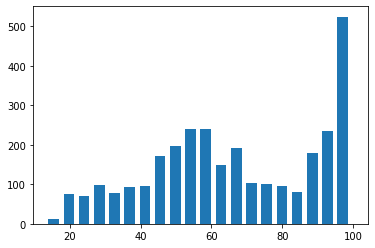

In [42]:
import matplotlib.pyplot as plt
plt.hist(np.array(df_test["max_ident"]), bins = 20, width= 3)
plt.show()

In [12]:
df_test.to_pickle(join("..", "..", "data", "transporter_substrate_pairs", "df_UID_MID_test.pkl"))

## Adding task-specific transporter representations

In [3]:
df_Uniprot = pd.read_pickle(join("..", "..", "data", "proteins", "df_Uniprot_with_ESM1b.pkl"))
df_train = pd.read_pickle(join("..", "..", "data", "transporter_substrate_pairs", "df_UID_MID_train.pkl"))
df_test = pd.read_pickle(join("..", "..", "data", "transporter_substrate_pairs", "df_UID_MID_test.pkl"))

In [61]:
ofile = open(join("..", "..", "data", "proteins",  "all_transporter_sequences_TSP.fasta"), "w")
for ind in df_Uniprot.index:
    seq = df_Uniprot["Sequence"][ind]
    if not pd.isnull(seq):
        seq_end = seq.find("#")
        seq = seq[:seq_end]
        ofile.write(">" + str(ind) + "\n" + seq[:1018]  + "\n")
ofile.close()

In [4]:
import torch 

df_Uniprot["ESM1b_ts"] = ""
rep_dict = torch.load(join("..", "..", "data", "proteins", "all_transporter_sequences_TSP_esm1b_ts.pt"))

for ind in df_Uniprot.index:
    try:
        df_Uniprot["ESM1b_ts"][ind] = rep_dict[str(ind) +".pt"]
    except:
        print(ind)
df_Uniprot

,Uniprot ID,Sequence,ESM1b,ESM1b_ts
0,Q93AS1,AAIFFAGTPILESAMVYPLAICGACILTSIAGTFFVKLGTNNSIMG...,"[0.11742191, 0.03617902, 0.12970069, 0.1066238...","[-0.016634343, 0.18292814, 0.2628353, 0.029832..."
1,P22687,ACPKGASYEAGIVCRITKPALLVLNQETAKVVQTAFQRAGYPDVSG...,"[-0.12117738, 0.26806024, 0.09586262, 0.202550...","[0.046347678, 0.28469172, 0.504908, -0.0900926..."
2,P27081,ADNQHPTVYQKVASQMHLSSSLSQDVHARYGGIQRPALSQRRFPYG...,"[-0.03586754, 0.109046906, 0.023026276, 0.0229...","[-0.21089841, 0.25332168, 0.29078317, 0.157432..."
3,P80652,AEKLEPVLPLIV,"[0.09634989, 0.04513239, 0.0011855256, 0.21496...","[-0.17413804, 0.17294985, 0.115228765, 0.14004..."
4,Q04236,AEVLMDFPQLTMTLPDGREESVMKLTTLVA,"[0.10052207, 0.1349428, 0.044972803, 0.1729081...","[-0.13603084, 0.114811234, 0.14787005, 0.14868..."
...,...,...,...,...
17839,P80730,XSGKVLSEEEKAAANVYIKKME,"[0.029132316, 0.117055416, -0.028016612, 0.101...","[-0.16792904, 0.2215103, 0.06666383, 0.1239057..."
17840,P80263,XSNATDETXLKDVSA,"[-0.00706834, 0.07775431, -0.097076654, 0.1602...","[-0.20746464, 0.17222255, 0.12559846, 0.189439..."
17841,A0A140LJ55,XYARQMMFSTTLLIVFFTVWVFGGGTTAMLSCLHIRYYARLWGYRD...,"[0.024597568, 0.17639516, 0.03693423, 0.025202...","[-0.16736814, 0.24859925, 0.19806978, 0.103181..."
17842,P86911,YGPNELPAEEGKNAESAIEALKEYEPEMGKEIVPGDLVEISVGDKI...,"[0.11319703, 0.16834064, -0.09670459, 0.121843...","[-0.14268504, 0.21442162, 0.076324865, 0.16876..."


In [5]:
df_train["ESM1b_ts"] = ""
for ind in df_train.index:
    UID = df_train["Uniprot ID"][ind]
    help_df = df_Uniprot.loc[df_Uniprot["Uniprot ID"] == UID]
    df_train["ESM1b_ts"][ind] = list(help_df["ESM1b_ts"])[0]
    
df_train = df_train.loc[df_train["ESM1b_ts"] != ""]
df_train

C:\Users\alexk\anaconda3\envs\Transport\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\alexk\anaconda3\envs\Transport\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = libops.scalar_compare(x.ravel(), y, op)


,Uniprot ID,Sequence,molecule ID,ECFP,forbidden_inchis,outcome,ChemBERTa,ESM1b,ESM1b_ts
0,P22687,ACPKGASYEAGIVCRITKPALLVLNQETAKVVQTAFQRAGYPDVSG...,InChI=1S/C27H46O/c1-18(2)7-6-8-19(3)23-11-12-2...,0100000110000000100000000000000001001000010000...,[InChI=1S/C45H78O2/c1-7-8-9-10-11-12-13-14-15-...,1,"[-2.65946888923645, -2.193105936050415, -2.509...","[-0.12117738, 0.26806024, 0.09586262, 0.202550...","[0.046347678, 0.28469172, 0.504908, -0.0900926..."
1,P22687,ACPKGASYEAGIVCRITKPALLVLNQETAKVVQTAFQRAGYPDVSG...,InChI=1S/C45H76O2/c1-7-8-9-10-11-12-13-14-15-1...,0100000110000000100000000000100001011000010000...,[InChI=1S/C45H78O2/c1-7-8-9-10-11-12-13-14-15-...,1,"[-2.5698935985565186, -2.2278573513031006, -2....","[-0.12117738, 0.26806024, 0.09586262, 0.202550...","[0.046347678, 0.28469172, 0.504908, -0.0900926..."
2,P22687,ACPKGASYEAGIVCRITKPALLVLNQETAKVVQTAFQRAGYPDVSG...,InChI=1S/C45H78O2/c1-7-8-9-10-11-12-13-14-15-1...,0100000110000000100000000000100001011000010000...,[InChI=1S/C45H78O2/c1-7-8-9-10-11-12-13-14-15-...,1,"[-2.645322799682617, -2.1791882514953613, -2.5...","[-0.12117738, 0.26806024, 0.09586262, 0.202550...","[0.046347678, 0.28469172, 0.504908, -0.0900926..."
3,P22687,ACPKGASYEAGIVCRITKPALLVLNQETAKVVQTAFQRAGYPDVSG...,InChI=1S/C57H104O6/c1-4-7-10-13-16-19-22-25-28...,0100000000000000000000000000010001000000000000...,[InChI=1S/C45H78O2/c1-7-8-9-10-11-12-13-14-15-...,1,"[-2.449126958847046, -2.3380744457244873, -2.6...","[-0.12117738, 0.26806024, 0.09586262, 0.202550...","[0.046347678, 0.28469172, 0.504908, -0.0900926..."
4,Q8VNJ8,AGGIAEMAELGPEVRKKTDKLDAVGNTTAAVAKGFAIGSAALTALA...,InChI=1S/Na,0000000000000000000000000000000000000000000000...,[InChI=1S/C9H14N4O3/c10-2-1-8(14)13-7(9(15)16)...,1,"[-1.5495914220809937, -1.1587504148483276, -2....","[0.18846853, 0.021025904, 0.15278327, 0.096030...","[-0.0179174, 0.13904388, 0.2926922, 0.05819841..."
...,...,...,...,...,...,...,...,...,...
26857,P83624,VVWTNEERSIISSIFSNLDYDDIGPKALCRCLIVYPWTQRHFTTFG...,InChI=1S/K,0000000000000000000000000000000000000000000000...,NaN,0,"[-1.6988823413848877, -2.054469585418701, -2.5...","[0.04314419, 0.103943475, 0.03652573, 0.088096...","[-0.12705676, 0.2803696, 0.23343748, 0.1223082..."
26858,P83624,VVWTNEERSIISSIFSNLDYDDIGPKALCRCLIVYPWTQRHFTTFG...,InChI=1S/Ca,0000000000000000000000000000000000000000000000...,NaN,0,"[-1.317147135734558, -1.4327999353408813, -2.5...","[0.04314419, 0.103943475, 0.03652573, 0.088096...","[-0.12705676, 0.2803696, 0.23343748, 0.1223082..."
26859,F6RT95,XDPDCQSLCFEVYPETARHGSCITNVNGEPLKEKTQNSCMEESPTA...,InChI=1S/K,0000000000000000000000000000000000000000000000...,NaN,0,"[-1.6988823413848877, -2.054469585418701, -2.5...","[0.02459435, 0.16242298, -0.05622962, 0.081984...","[-0.2401027, 0.1937631, 0.16807695, 0.13970037..."
26860,F6RT95,XDPDCQSLCFEVYPETARHGSCITNVNGEPLKEKTQNSCMEESPTA...,InChI=1S/Na,0000000000000000000000000000000000000000000000...,NaN,0,"[-1.5495914220809937, -1.1587504148483276, -2....","[0.02459435, 0.16242298, -0.05622962, 0.081984...","[-0.2401027, 0.1937631, 0.16807695, 0.13970037..."


In [6]:
df_test["ESM1b_ts"] = ""
for ind in df_test.index:
    UID = df_test["Uniprot ID"][ind]
    help_df = df_Uniprot.loc[df_Uniprot["Uniprot ID"] == UID]
    df_test["ESM1b_ts"][ind] = list(help_df["ESM1b_ts"])[0]
    
df_test = df_test.loc[df_test["ESM1b_ts"] != ""]
df_test

C:\Users\alexk\anaconda3\envs\Transport\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\alexk\anaconda3\envs\Transport\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = libops.scalar_compare(x.ravel(), y, op)


,Uniprot ID,Sequence,molecule ID,ECFP,forbidden_inchis,outcome,ChemBERTa,ESM1b,max_ident,max_ind,max_ident_train_seq,ESM1b_ts
0,P27081,ADNQHPTVYQKVASQMHLSSSLSQDVHARYGGIQRPALSQRRFPYG...,InChI=1S/C10H16N5O13P3/c11-8-5-9(13-2-12-8)15(...,0000000001000000000000000000000000000000000100...,[InChI=1S/C10H16N5O13P3/c11-8-5-9(13-2-12-8)15...,1,"[-2.4719278812408447, -2.1134302616119385, -2....","[-0.03586754, 0.109046906, 0.023026276, 0.0229...",88.1,292.0,MADMNQHPTVFQKAANQLDLRSSLSQDVHARYGGVQPAIYQRHFAY...,"[-0.21089841, 0.25332168, 0.29078317, 0.157432..."
1,P27081,ADNQHPTVYQKVASQMHLSSSLSQDVHARYGGIQRPALSQRRFPYG...,InChI=1S/C10H15N5O10P2/c11-8-5-9(13-2-12-8)15(...,0000000001000000000000000000000000000000000000...,[InChI=1S/C10H16N5O13P3/c11-8-5-9(13-2-12-8)15...,1,"[-2.478724241256714, -2.096115827560425, -2.81...","[-0.03586754, 0.109046906, 0.023026276, 0.0229...",88.1,292.0,MADMNQHPTVFQKAANQLDLRSSLSQDVHARYGGVQPAIYQRHFAY...,"[-0.21089841, 0.25332168, 0.29078317, 0.157432..."
2,Q07598,ARVCEERGGPAAIMQRRVFVVGVGMTKFAKPSENSVDYPDLAKEAG...,InChI=1S/C27H44O/c1-18(2)7-6-8-19(3)23-11-12-2...,0100100010000000000000000000000001001100010000...,"[InChI=1S/C3H7NO3/c4-2(1-5)3(6)7/h2,5H,1,4H2,(...",1,"[-2.676461696624756, -2.2211854457855225, -2.4...","[-0.05300015, 0.27514377, 0.23174773, -0.07599...",76.8,10786.0,MSSSPWEPATLRRVFVVGVGMTKFVKPGAENSRDYPDLAEEAGKKA...,"[-0.06614882, 0.25127164, 0.3795529, -0.269309..."
3,Q963J1,EIVKYIAHLWRRFKRRMLKKYRLYKYQRQQRKEGLLPNADNLTFSP...,InChI=1S/Ca,0000000000000000000000000000000000000000000000...,"[InChI=1S/p+1, InChI=1S/Ca]",1,"[-1.317147135734558, -1.4327999353408813, -2.5...","[0.027722232, 0.22445068, 0.028319076, 0.00928...",18.8,6480.0,MLPQPAAAVATATTTTTQSATSATSTAATSAAAAAARNGQRRRVAA...,"[-0.090943225, 0.19478253, 0.1820414, 0.147179..."
4,Q5D6W0,FDESSSDKEILDLLLEKKRYDKRLLPPVNDEDFCCGLQSPDMATNQ...,InChI=1S/ClH/h1H/p-1,0000000000000000000000000000000000000000000000...,"[InChI=1S/H3O3P/c1-4(2)3/h4H,(H2,1,2,3)/p-2, I...",1,"[-1.5440824031829834, -1.5209712982177734, -2....","[-0.124094985, 0.1709933, 0.05947756, -0.16553...",96.2,26.0,FDESSSDKEILDLLLEKKRYDKRLLPPVNDEDFCCGLQSPDMATNQ...,"[-0.09816852, 0.2530695, 0.18257187, 0.0956020..."
...,...,...,...,...,...,...,...,...,...,...,...,...
6295,B2CPI4,TARYTALVAKDAKRAAADMGKVLHVEIDPEDAKVERMAKDESNQFG...,InChI=1S/C16H25N5O16P2/c17-16-19-12-6(13(28)20...,0000000000000100000000000000000000000000000000...,NaN,0,"[-2.680332899093628, -2.1504106521606445, -2.4...","[0.17249477, 0.20887941, -0.04866665, -0.02476...",20.0,291.0,MADMAENNRAVIKLREKFASSILEVKEFRGEVTVIVRKEDIVALCK...,"[-0.17221491, 0.21029918, 0.22855827, 0.135962..."
6296,B2CPI4,TARYTALVAKDAKRAAADMGKVLHVEIDPEDAKVERMAKDESNQFG...,"InChI=1S/H3O3P/c1-4(2)3/h4H,(H2,1,2,3)/p-2",0000000000000000000000000000000000000000000000...,NaN,0,"[-2.015889883041382, -1.8417659997940063, -2.8...","[0.17249477, 0.20887941, -0.04866665, -0.02476...",20.0,291.0,MADMAENNRAVIKLREKFASSILEVKEFRGEVTVIVRKEDIVALCK...,"[-0.17221491, 0.21029918, 0.22855827, 0.135962..."
6297,P86911,YGPNELPAEEGKNAESAIEALKEYEPEMGKEIVPGDLVEISVGDKI...,InChI=1S/K,0000000000000000000000000000000000000000000000...,NaN,0,"[-1.6988823413848877, -2.054469585418701, -2.5...","[0.11319703, 0.16834064, -0.09670459, 0.121843...",21.6,13125.0,WGEQEASILVPGDIVSIKLGDIVPADARIDQSGLTGESLPVTKNPG...,"[-0.14268504, 0.21442162, 0.076324865, 0.16876..."
6298,P86911,YGPNELPAEEGKNAESAIEALKEYEPEMGKEIVPGDLVEISVGDKI...,InChI=1S/Na,0000000000000000000000000000000000000000000000...,NaN,0,"[-1.5495914220809937, -1.1587504148483276, -2....","[0.11319703, 0.16834064, -0.09670459, 0.121843...",21.6,13125.0,WGEQEASILVPGDIVSIKLGDIVPADARIDQSGLTGESLPVTKNPG...,"[-0.14268504, 0.21442162, 0.076324865, 0.16876..."


In [7]:
df_test.to_pickle(join("..", "..", "data", "transporter_substrate_pairs", "df_UID_MID_test.pkl"))
df_train.to_pickle(join("..", "..", "data", "transporter_substrate_pairs", "df_UID_MID_train.pkl"))

In [48]:
df_test.drop(columns = ["ESM1b", "ESM1b_ts", "ChemBERTa"], inplace = True)
df_train.drop(columns = ["ESM1b", "ESM1b_ts", "ChemBERTa"], inplace = True)

In [49]:
df_test.to_csv(join("..", "..", "data", "transporter_substrate_pairs", "df_UID_MID_test.csv"))
df_train.to_csv(join("..", "..", "data", "transporter_substrate_pairs", "df_UID_MID_train.csv"))